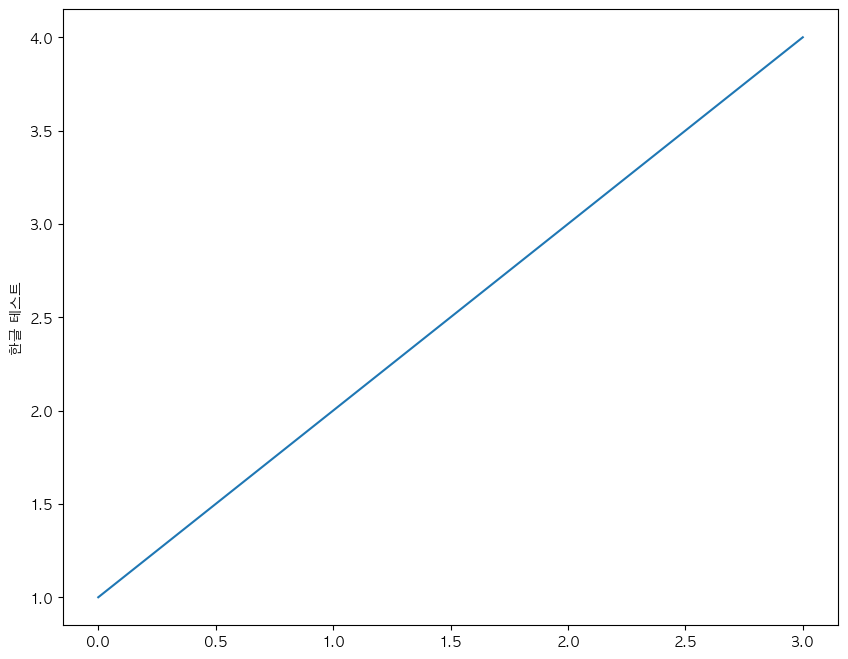

In [30]:
## import library
import trino
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable


plt.rcParams['figure.figsize'] = [10, 8]

conn = trino.dbapi.connect(
    host='kakaoent-presto-adhoc.kakaoent.io',
    port=8443,
    user='samuel-ch',
    catalog='hadoop_kent',
    schema='default',                          # 사용할 Database 지정
    http_scheme='https',
    auth=trino.auth.BasicAuthentication("samuel-ch", "melon!Q2w3e"),  # 카카오 LDAP이 아닌 하둡 LDAP 입력
    http_headers={
        'X-Presto-User': 'samuel-ch',
        'X-Presto-Time-Zone': 'Asia/Seoul'
    },
)
cur = conn.cursor()

# Set CSS properties for th elements in dataframe
th_props = [
  ('font-size', '11px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', '#6d6d6d'),
  ('background-color', '#f7f7f9')
  ]

# Set CSS properties for td elements in dataframe
td_props = [
  ('font-size', '11px')
  ]

# Set table styles
styles = [
  dict(selector="th", props=th_props),
  dict(selector="td", props=td_props)
  ]

cm = sns.light_palette("green", as_cmap=True)

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# AppleGothic 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'

# 테스트 플롯
plt.plot([1, 2, 3, 4])
plt.ylabel('한글 테스트')
plt.show()

In [33]:
# 3개월 100원 프로모션 데이터 쿼리
promo_retention_query = '''
SELECT
    FST_DT AS YM
  , PROMO_GRP_NM
  , FST_PROD_CNT
  , IF(M1_PROD_CNT = 0, NULL, cast(M1_PROD_CNT  as double)/FST_PROD_CNT*100) AS M1_PROD_RATE
  , IF(M2_PROD_CNT = 0, NULL, cast(M2_PROD_CNT  as double)/FST_PROD_CNT*100) AS M2_PROD_RATE
  , IF(M3_PROD_CNT = 0, NULL, cast(M3_PROD_CNT  as double)/FST_PROD_CNT*100) AS M3_PROD_RATE
  , IF(M4_PROD_CNT = 0, NULL, cast(M4_PROD_CNT  as double)/FST_PROD_CNT*100) AS M4_PROD_RATE
  , IF(M5_PROD_CNT = 0, NULL, cast(M5_PROD_CNT  as double)/FST_PROD_CNT*100) AS M5_PROD_RATE
  , IF(M6_PROD_CNT = 0, NULL, cast(M6_PROD_CNT  as double)/FST_PROD_CNT*100) AS M6_PROD_RATE
  --, IF(M7_PROD_CNT = 0, NULL, cast(M7_PROD_CNT  as double)/FST_PROD_CNT*100) AS M7_PROD_RATE
  --, IF(M8_PROD_CNT = 0, NULL, cast(M8_PROD_CNT  as double)/FST_PROD_CNT*100) AS M8_PROD_RATE
  --, IF(M9_PROD_CNT = 0, NULL, cast(M9_PROD_CNT  as double)/FST_PROD_CNT*100) AS M9_PROD_RATE
  --, IF(M10_PROD_CNT= 0, NULL, cast(M10_PROD_CNT as double)/FST_PROD_CNT*100) AS M10_PROD_RATE
  --, IF(M11_PROD_CNT= 0, NULL, cast(M11_PROD_CNT as double)/FST_PROD_CNT*100) AS M11_PROD_RATE
  --, IF(M12_PROD_CNT= 0, NULL, cast(M12_PROD_CNT as double)/FST_PROD_CNT*100) AS M12_PROD_RATE
FROM (
    SELECT
        FST_DT
      , PROMO_GRP_NM
      , COUNT(DISTINCT FIRST_BUY_NO) AS FST_PROD_CNT
      , COUNT(DISTINCT IF(TERM = 1, BUY_NO, NULL))  AS M1_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 2, BUY_NO, NULL))  AS M2_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 3, BUY_NO, NULL))  AS M3_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 4, BUY_NO, NULL))  AS M4_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 5, BUY_NO, NULL))  AS M5_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 6, BUY_NO, NULL))  AS M6_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 7, BUY_NO, NULL))  AS M7_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 8, BUY_NO, NULL))  AS M8_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 9, BUY_NO, NULL))  AS M9_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 10, BUY_NO, NULL)) AS M10_PROD_CNT
      , COUNT(DISTINCT IF(TERM = 11, BUY_NO, NULL)) AS M11_PROD_CNT
      , COUNT(DISTINCT IF(TERM = 12, BUY_NO, NULL)) AS M12_PROD_CNT
    FROM (
        SELECT
            DATE_FORMAT(FST_DT, '%Y-%m') AS FST_DT
          , FIRST_BUY_NO
          , PROMO_GRP_NM
          , DT
          , BUY_NO
          , IF(NEW_TERM = LAG(NEW_TERM) OVER (PARTITION BY FST_DT, FIRST_BUY_NO, MEMBER_KEY ORDER BY DT), NEW_TERM+1, NEW_TERM) AS TERM
--          , DATE_DIFF('MONTH', DATE(DATE_FORMAT(FST_DT, '%Y-%m-01')), DATE(DATE(DATE_FORMAT(CURRENT_DATE, '%Y-%m-01')))) AS TEMP
        FROM (
            SELECT 
                FST_DT
              , FIRST_BUY_NO
              , PROMO_GRP_NM
              , MEMBER_KEY
              , DT
              , BUY_NO
              , CASE
                    WHEN (BF_TERM + 1) = TERM THEN TERM
                    WHEN (BF_TERM + 1) <> TERM AND (MONTH(BF_DT) = MONTH(DT)) THEN (TERM + 1)
                    ELSE TERM
                END AS NEW_TERM
            FROM (
                SELECT
                    FST_DT
                  , FIRST_BUY_NO
                  , PROMO_GRP_NM
                  , MEMBER_KEY
                  , DT
                  , BUY_NO
                  , TERM
                  , COALESCE(LAG(DT)     OVER (PARTITION BY FST_DT, FIRST_BUY_NO, MEMBER_KEY ORDER BY DT), FST_DT) AS BF_DT
                  , COALESCE(LAG(BUY_NO) OVER (PARTITION BY FST_DT, FIRST_BUY_NO, MEMBER_KEY ORDER BY DT), FIRST_BUY_NO) AS BF_BUY_NO
                  , COALESCE(LAG(TERM)   OVER (PARTITION BY FST_DT, FIRST_BUY_NO, MEMBER_KEY ORDER BY DT), 0) AS BF_TERM
                FROM (
                    SELECT F1.DT AS FST_DT
                         , F1.FIRST_BUY_NO
                         , F1.PROMO_GRP_NM
                         , F1.MEMBER_KEY
                         , F2.BUY_NO
                         , F2.DT
                         , DATE_DIFF('MONTH', F1.DT, F2.DT) AS TERM
                    FROM (
                        SELECT T1.DT
                             , T1.FIRST_BUY_NO
                             , T1.BUY_NO
                             , T1.USER_MKEY AS MEMBER_KEY
                             , T5.PROMO_DC_GRP
                             , T3.PROMO_GRP_CD
                             , T6.PROMO_GRP_NM
                        FROM HADOOP_KENT.MELON_MA_STAT_PRODUCTION.F_PROD_USER_FXMT_DT T1
                        JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROD T2  ON (T1.PROD_ID = T2.PROD_ID)
                        JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROMO T3 ON (T1.PROMO_ID = T3.PROMO_ID)
                        JOIN HADOOP_KENT.MELON_ODS_COMMERCE_PRODUCTION.CPT_PROD_TB_RO T4 ON (T1.PROD_ID = T4.PROD_ID)
                        JOIN(
                            SELECT PROMO_DC_GRP_CD
                                 , PROMO_DC_GRP_NM
                                 , CASE
                                    WHEN PROMO_DC_GRP_CD IN (2,3,4) THEN '1개월 0원 + 장기할인'
                                    WHEN PROMO_DC_GRP_CD IN (5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,83,86,87,88,91,93,94,98,109) THEN '1개월 100원 + 할인'
                                    WHEN PROMO_DC_GRP_CD IN (95,101,102) THEN '1개월 할인'
                                    WHEN PROMO_DC_GRP_CD IN (28,29,30,31,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51) THEN '2개월 할인'
                                    WHEN PROMO_DC_GRP_CD IN (33,103) THEN '2개월 100원 + 할인'
                                    WHEN PROMO_DC_GRP_CD IN (54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,70,71,72,73,74,75,76,77,78,81,82,84,85,89,90,92,96,97,99,100,104,110,107,108) THEN '장기할인(3개월이상)'
                                    ELSE PROMO_DC_GRP_NM
                                   END AS PROMO_DC_GRP
                            FROM HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROMO_DC_GRP
                        ) T5 ON T3.PROMO_DC_GRP_CD = T5.PROMO_DC_GRP_CD
                        left join hadoop_kent.melon_ma_stat_production.d_promo_grp t6 on t3.promo_grp_cd = t6.promo_grp_cd
                        WHERE T1.LOG_DATE BETWEEN '20231201' AND '20241231'
                          AND DATE_FORMAT(T1.DT, '%Y%m%d') BETWEEN '20231201' AND '20241231'
                          AND PF_YN = 1
                          AND T2.PROD_ATTR_CD NOT IN (10040, 10050)
                          AND T1.PROD_JOIN_PRT_CD = 1100 --IN (1100, 1200, 1201, 1205, 1203,1206,1207) /*신규 로직에서 1206 제외*/ 
                          AND T2.PROD_SELL_PRT_CD IN (60000) /*B2C*/
                          AND PROD_PRT_CD = 20000  /*클럽 상품*/
                          AND T5.PROMO_DC_GRP = '3개월 100원'
                          AND T3.PROMO_GRP_CD <> 49
                        GROUP BY 1, 2, 3, 4,5, 6, 7

                    ) F1
                    LEFT OUTER JOIN (
                        SELECT DT
                             , FIRST_BUY_NO
                             , BUY_NO
                             , USER_MKEY AS MEMBER_KEY
                        FROM HADOOP_KENT.MELON_MA_STAT_PRODUCTION.F_PROD_USER_FXMT_DT  T1
                        JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROD               T2 ON (T1.PROD_ID = T2.PROD_ID)
                        JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROMO              T3 ON (T1.PROMO_ID = T3.PROMO_ID)
                        JOIN HADOOP_KENT.MELON_ODS_COMMERCE_PRODUCTION.CPT_PROD_TB_RO     T4 ON (T1.PROD_ID = T4.PROD_ID)
                        WHERE T1.LOG_DATE >= '20231201'
                          AND DATE_FORMAT(T1.DT, '%Y%m%d') >= '20231201'
                          AND PF_YN = 1
                          AND T2.PROD_ATTR_CD NOT IN (10040, 10050)
                          AND T1.PROD_JOIN_PRT_CD IN (1202) /*자결*/
                          AND T2.PROD_SELL_PRT_CD IN (60000) /*B2C*/
                          AND SELL_TYPE_CODE = 'ON1300'
                        GROUP BY 1, 2, 3, 4
                    ) F2 ON (F1.FIRST_BUY_NO = F2.FIRST_BUY_NO AND F1.MEMBER_KEY = F2.MEMBER_KEY AND F2.BUY_NO > F1.BUY_NO)
                ) F3
            ) DF1
        ) DF2
    ) DF3
--    WHERE TERM < TEMP
    GROUP BY 1,2
)
ORDER BY 1,2


'''

cur.execute(promo_retention_query)

results = cur.fetchall()
colnames = [part[0] for part in cur.description]

promo_retention_df = pd.DataFrame(results, columns=colnames)

cur.cancel()
conn.close()
promo_retention_df.head()

,YM,PROMO_GRP_NM,FST_PROD_CNT,M1_PROD_RATE,M2_PROD_RATE,M3_PROD_RATE,M4_PROD_RATE,M5_PROD_RATE,M6_PROD_RATE
0,2023-12,3개월 100원 프로모션,993,92.648540,87.311178,60.422961,46.324270,40.483384,36.656596
1,2023-12,TMS 프로모션,124,94.354839,91.129032,55.645161,37.903226,35.483871,33.064516
2,2024-01,3개월 100원 프로모션,9844,90.674523,85.666396,60.412434,48.730191,43.041447,39.374238
3,2024-01,TMS 프로모션,937,94.343650,89.861259,62.966916,47.598719,40.875133,37.673426
4,2024-02,3개월 100원 프로모션,8079,91.013739,86.768164,60.836737,48.161901,42.666172,38.779552


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [114]:

# 1. 평균 잔존율 비교
mean_retention = promo_retention_df.groupby("PROMO_GRP_NM")[["M1_PROD_RATE", "M2_PROD_RATE", "M3_PROD_RATE", "M4_PROD_RATE", "M5_PROD_RATE", "M6_PROD_RATE"]].mean()
print("평균 잔존율 비교:")
print(mean_retention)

# 2. M3 이후 잔존율 감소율 계산
promo_retention_df["M3_to_M6_Drop"] = promo_retention_df["M3_PROD_RATE"] - promo_retention_df["M6_PROD_RATE"]
drop_rate = promo_retention_df.groupby("PROMO_GRP_NM")["M3_to_M6_Drop"].mean()
print("\nM3 이후 잔존율 감소율:")
print(drop_rate)



평균 잔존율 비교:
               M1_PROD_RATE  M2_PROD_RATE  M3_PROD_RATE  M4_PROD_RATE  \
PROMO_GRP_NM                                                            
3개월 100원 프로모션     90.949525     86.058410     56.230740     43.042644   
TMS 프로모션          94.731449     91.555123     60.317123     43.301254   

               M5_PROD_RATE  M6_PROD_RATE  
PROMO_GRP_NM                               
3개월 100원 프로모션     38.658551     34.742307  
TMS 프로모션          36.804760     32.927565  

M3 이후 잔존율 감소율:
PROMO_GRP_NM
3개월 100원 프로모션    25.671213
TMS 프로모션         30.573995
Name: M3_to_M6_Drop, dtype: float64


YM 단위 평균 잔존율:
                       M1_PROD_RATE  M2_PROD_RATE  M3_PROD_RATE  M4_PROD_RATE  \
YM      PROMO_GRP_NM                                                            
2023-12 3개월 100원 프로모션     92.648540     87.311178     60.422961     46.324270   
        TMS 프로모션          94.354839     91.129032     55.645161     37.903226   
2024-01 3개월 100원 프로모션     90.674523     85.666396     60.412434     48.730191   
        TMS 프로모션          94.343650     89.861259     62.966916     47.598719   
2024-02 3개월 100원 프로모션     91.013739     86.768164     60.836737     48.161901   
        TMS 프로모션          95.025510     92.346939     64.923469     47.321429   
2024-03 3개월 100원 프로모션     91.856134     87.694284     61.374438     48.503532   
        TMS 프로모션          95.512821     93.076923     66.282051     50.512821   
2024-04 3개월 100원 프로모션     91.321004     86.472919     60.343461     47.582563   
        TMS 프로모션          94.535519     92.167577     61.202186     46.448087   
2024-05 3개월 10

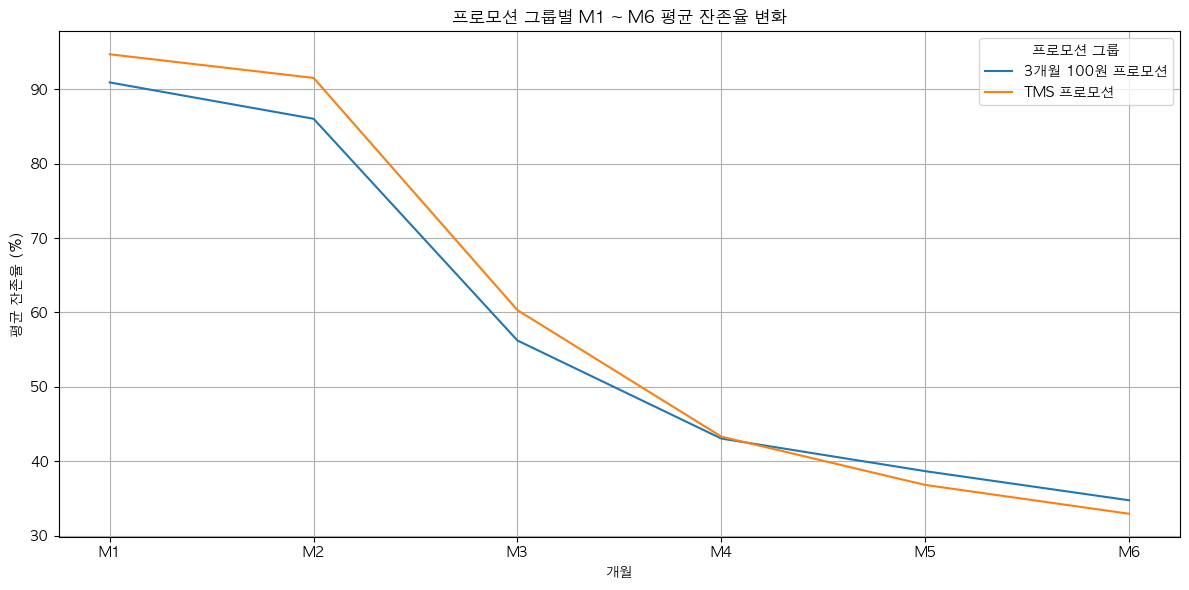

In [34]:
import matplotlib.pyplot as plt

# 1. YM 단위로 평균 잔존율 계산
ym_mean_retention = promo_retention_df.groupby(["YM", "PROMO_GRP_NM"])[["M1_PROD_RATE", "M2_PROD_RATE", "M3_PROD_RATE", "M4_PROD_RATE", "M5_PROD_RATE", "M6_PROD_RATE"]].mean()
print("YM 단위 평균 잔존율:")
print(ym_mean_retention)

# Reset index for easier manipulation
ym_mean_retention = ym_mean_retention.reset_index()

# 2. M1 ~ M6을 X축으로 설정하여 시각화
plt.figure(figsize=(12, 6))

# Plot each promotion group
for promo_grp in ym_mean_retention["PROMO_GRP_NM"].unique():
    # 프로모션 그룹별 평균 잔존율 추출
    promo_data = ym_mean_retention[ym_mean_retention["PROMO_GRP_NM"] == promo_grp]
    # M1 ~ M6 평균 잔존율 계산
    avg_retention = promo_data[["M1_PROD_RATE", "M2_PROD_RATE", "M3_PROD_RATE", "M4_PROD_RATE", "M5_PROD_RATE", "M6_PROD_RATE"]].mean()
    plt.plot(["M1", "M2", "M3", "M4", "M5", "M6"], avg_retention, label=promo_grp)

# 그래프 설정
plt.title("프로모션 그룹별 M1 ~ M6 평균 잔존율 변화")
plt.ylabel("평균 잔존율 (%)")
plt.xlabel("개월")
plt.legend(title="프로모션 그룹")
plt.grid(True)
plt.tight_layout()
plt.show()

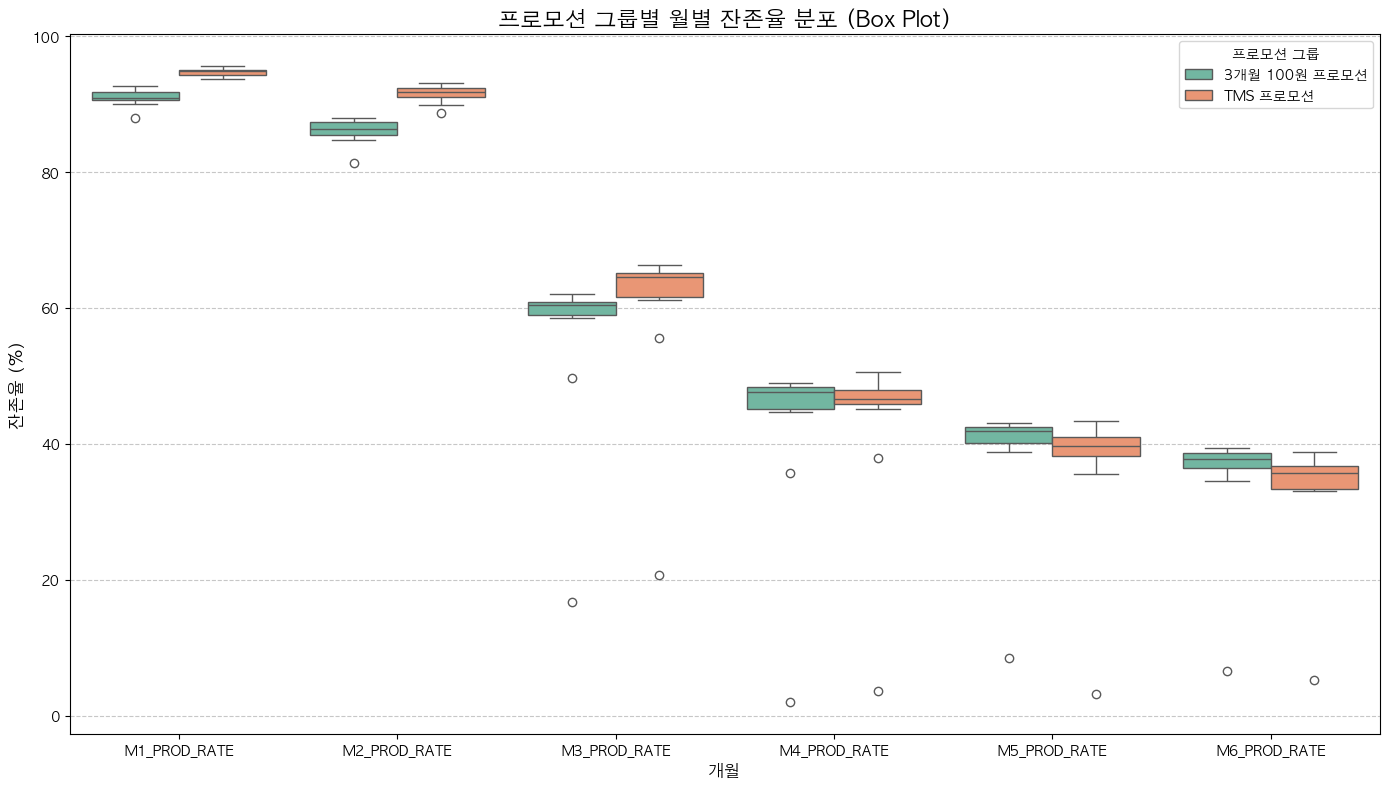

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 준비
# YM 단위 평균 잔존율 데이터에서 Box Plot을 그리기 위해 데이터 변환
boxplot_data = promo_retention_df.melt(
    id_vars=["YM", "PROMO_GRP_NM"], 
    value_vars=["M1_PROD_RATE", "M2_PROD_RATE", "M3_PROD_RATE", "M4_PROD_RATE", "M5_PROD_RATE", "M6_PROD_RATE"],
    var_name="Month", 
    value_name="Retention Rate"
)

# Month 열의 순서를 정렬
boxplot_data["Month"] = pd.Categorical(
    boxplot_data["Month"], 
    categories=["M1_PROD_RATE", "M2_PROD_RATE", "M3_PROD_RATE", "M4_PROD_RATE", "M5_PROD_RATE", "M6_PROD_RATE"], 
    ordered=True
)

# 2. Box Plot 그리기
plt.figure(figsize=(14, 8))
sns.boxplot(
    data=boxplot_data, 
    x="Month", 
    y="Retention Rate", 
    hue="PROMO_GRP_NM", 
    palette="Set2"
)

# 그래프 설정
plt.title("프로모션 그룹별 월별 잔존율 분포 (Box Plot)", fontsize=16)
plt.xlabel("개월", fontsize=12)
plt.ylabel("잔존율 (%)", fontsize=12)
plt.legend(title="프로모션 그룹", loc="upper right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

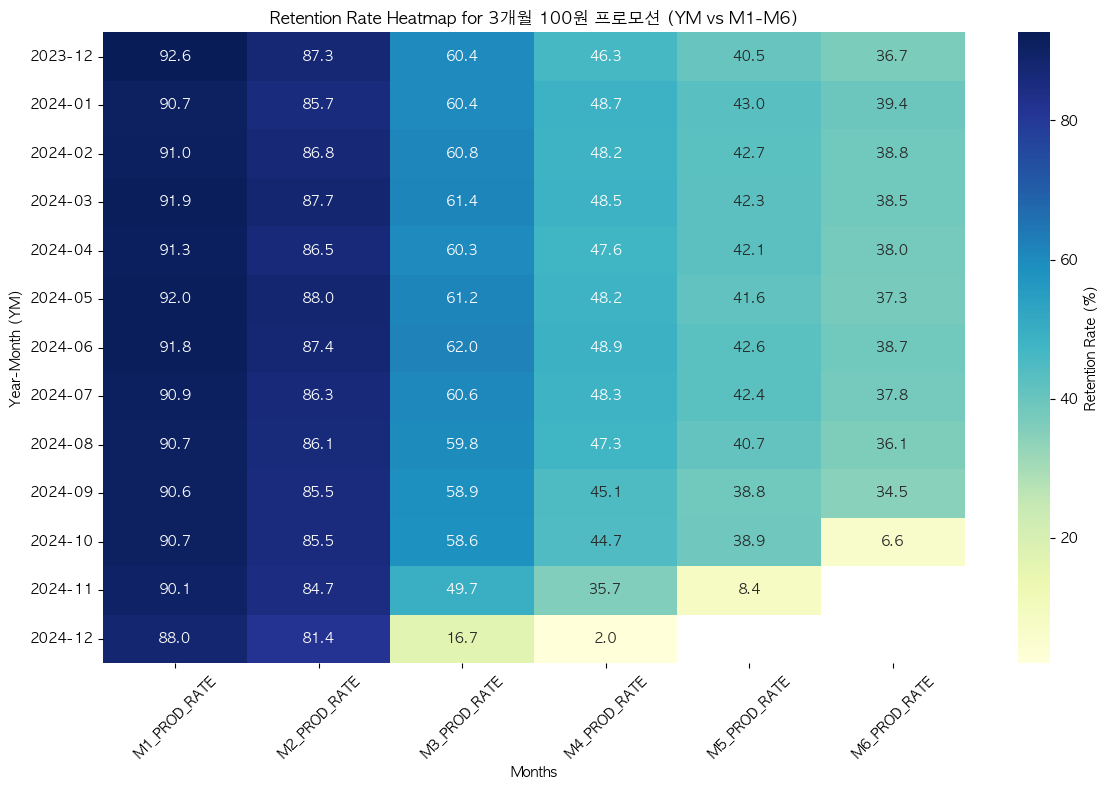

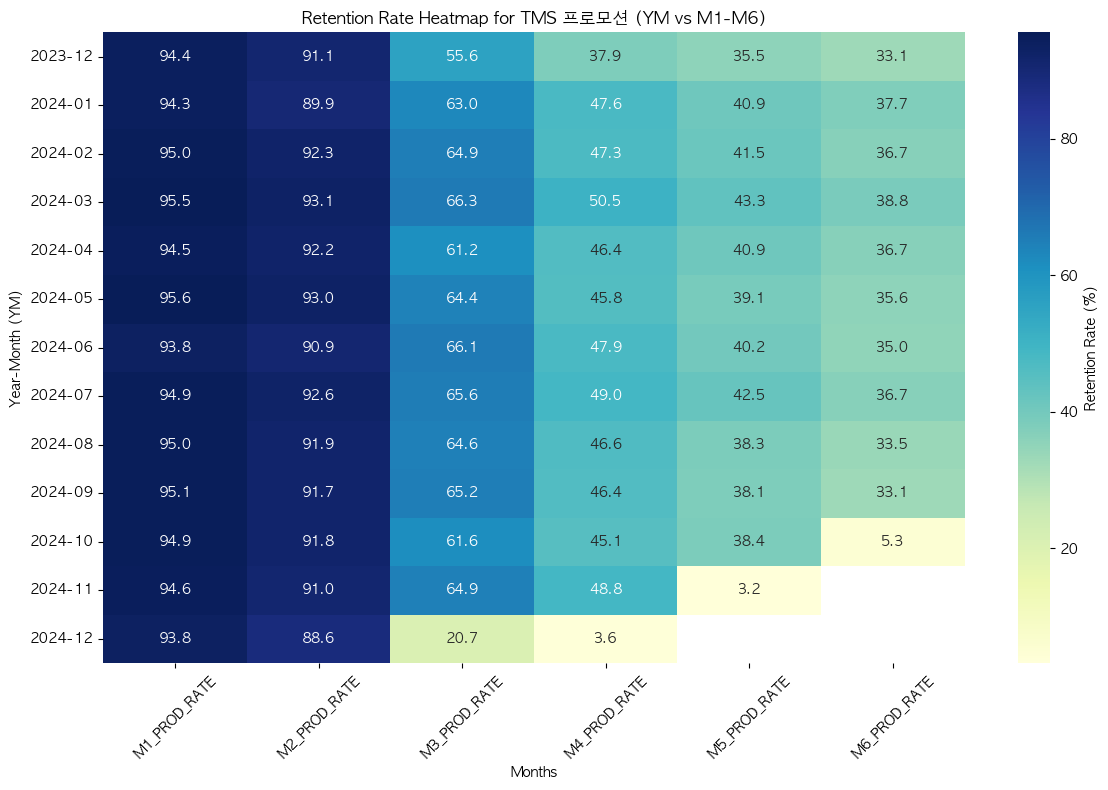

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 데이터 준비
# promo_retention_df에서 필요한 열만 선택
heatmap_data = promo_retention_df.melt(
    id_vars=["YM", "PROMO_GRP_NM"],  # PROMO_GRP_NM 추가
    value_vars=["M1_PROD_RATE", "M2_PROD_RATE", "M3_PROD_RATE", "M4_PROD_RATE", "M5_PROD_RATE", "M6_PROD_RATE"],
    var_name="Month", 
    value_name="Retention Rate"
)

# Month 열의 순서를 정렬
heatmap_data["Month"] = pd.Categorical(heatmap_data["Month"], categories=["M1_PROD_RATE", "M2_PROD_RATE", "M3_PROD_RATE", "M4_PROD_RATE", "M5_PROD_RATE", "M6_PROD_RATE"], ordered=True)

# 2. 프로모션 그룹별로 Heatmap 생성
promo_groups = heatmap_data["PROMO_GRP_NM"].unique()  # 프로모션 그룹 리스트

for promo_grp in promo_groups:
    # 특정 프로모션 그룹 데이터 필터링
    promo_data = heatmap_data[heatmap_data["PROMO_GRP_NM"] == promo_grp]
    
    # 피벗 테이블 생성 (YM을 Y축, Month를 X축으로 설정)
    heatmap_pivot = promo_data.pivot(index="YM", columns="Month", values="Retention Rate")
    
    # Heatmap 그리기
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_pivot, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Retention Rate (%)'})
    plt.title(f"Retention Rate Heatmap for {promo_grp} (YM vs M1-M6)")
    plt.xlabel("Months")
    plt.ylabel("Year-Month (YM)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

프로모션 그룹별 잔존율 표준편차:
               M1_PROD_RATE  M2_PROD_RATE  M3_PROD_RATE  M4_PROD_RATE  \
PROMO_GRP_NM                                                            
3개월 100원 프로모션      1.139524      1.707967     12.263112     12.819582   
TMS 프로모션           0.574824      1.258441     12.233917     12.304736   

               M5_PROD_RATE  M6_PROD_RATE  
PROMO_GRP_NM                               
3개월 100원 프로모션      9.638072      9.454775  
TMS 프로모션          10.811318      9.372211  


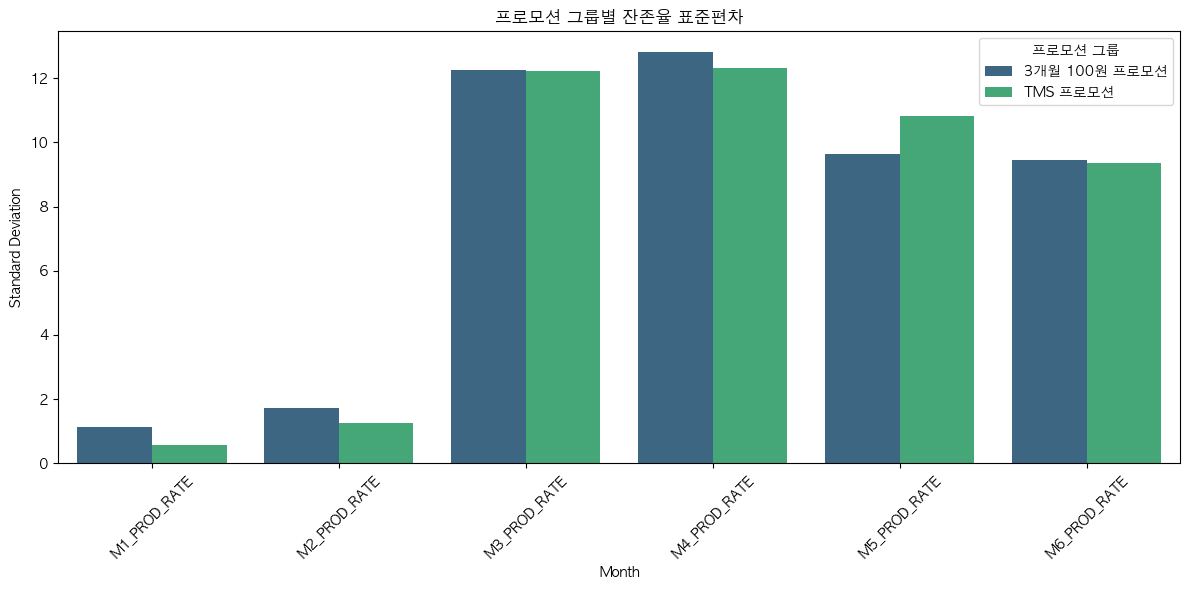

In [37]:
# 1. 프로모션 그룹별 잔존율 표준편차 계산
std_dev = promo_retention_df.groupby("PROMO_GRP_NM")[["M1_PROD_RATE", "M2_PROD_RATE", "M3_PROD_RATE", "M4_PROD_RATE", "M5_PROD_RATE", "M6_PROD_RATE"]].std()

# 표준편차 결과 출력
print("프로모션 그룹별 잔존율 표준편차:")
print(std_dev)

# 2. 시각화를 위해 데이터 변환
std_dev = std_dev.reset_index()  # 인덱스를 열로 변환
std_dev_melted = std_dev.melt(id_vars="PROMO_GRP_NM", var_name="Month", value_name="Standard Deviation")

# 3. 시각화: 프로모션 그룹별 잔존율 표준편차
plt.figure(figsize=(12, 6))
sns.barplot(data=std_dev_melted, x="Month", y="Standard Deviation", hue="PROMO_GRP_NM", palette="viridis")
plt.title("프로모션 그룹별 잔존율 표준편차")
plt.ylabel("Standard Deviation")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.legend(title="프로모션 그룹")
plt.tight_layout()
plt.show()

In [38]:
# 2개월 100원 프로모션 데이터 쿼리
promo_2month_retention_query = '''
SELECT
    FST_DT AS YM
  , PROMO_GRP_NM
  , FST_PROD_CNT
  , IF(M1_PROD_CNT = 0, NULL, cast(M1_PROD_CNT  as double)/FST_PROD_CNT*100) AS M1_PROD_RATE
  , IF(M2_PROD_CNT = 0, NULL, cast(M2_PROD_CNT  as double)/FST_PROD_CNT*100) AS M2_PROD_RATE
  , IF(M3_PROD_CNT = 0, NULL, cast(M3_PROD_CNT  as double)/FST_PROD_CNT*100) AS M3_PROD_RATE
  , IF(M4_PROD_CNT = 0, NULL, cast(M4_PROD_CNT  as double)/FST_PROD_CNT*100) AS M4_PROD_RATE
  , IF(M5_PROD_CNT = 0, NULL, cast(M5_PROD_CNT  as double)/FST_PROD_CNT*100) AS M5_PROD_RATE
  , IF(M6_PROD_CNT = 0, NULL, cast(M6_PROD_CNT  as double)/FST_PROD_CNT*100) AS M6_PROD_RATE
  --, IF(M7_PROD_CNT = 0, NULL, cast(M7_PROD_CNT  as double)/FST_PROD_CNT*100) AS M7_PROD_RATE
  --, IF(M8_PROD_CNT = 0, NULL, cast(M8_PROD_CNT  as double)/FST_PROD_CNT*100) AS M8_PROD_RATE
  --, IF(M9_PROD_CNT = 0, NULL, cast(M9_PROD_CNT  as double)/FST_PROD_CNT*100) AS M9_PROD_RATE
  --, IF(M10_PROD_CNT= 0, NULL, cast(M10_PROD_CNT as double)/FST_PROD_CNT*100) AS M10_PROD_RATE
  --, IF(M11_PROD_CNT= 0, NULL, cast(M11_PROD_CNT as double)/FST_PROD_CNT*100) AS M11_PROD_RATE
  --, IF(M12_PROD_CNT= 0, NULL, cast(M12_PROD_CNT as double)/FST_PROD_CNT*100) AS M12_PROD_RATE
FROM (
    SELECT
        FST_DT
      , PROMO_GRP_NM
      , COUNT(DISTINCT FIRST_BUY_NO) AS FST_PROD_CNT
      , COUNT(DISTINCT IF(TERM = 1, BUY_NO, NULL))  AS M1_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 2, BUY_NO, NULL))  AS M2_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 3, BUY_NO, NULL))  AS M3_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 4, BUY_NO, NULL))  AS M4_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 5, BUY_NO, NULL))  AS M5_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 6, BUY_NO, NULL))  AS M6_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 7, BUY_NO, NULL))  AS M7_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 8, BUY_NO, NULL))  AS M8_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 9, BUY_NO, NULL))  AS M9_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 10, BUY_NO, NULL)) AS M10_PROD_CNT
      , COUNT(DISTINCT IF(TERM = 11, BUY_NO, NULL)) AS M11_PROD_CNT
      , COUNT(DISTINCT IF(TERM = 12, BUY_NO, NULL)) AS M12_PROD_CNT
    FROM (
        SELECT
            DATE_FORMAT(FST_DT, '%Y-%m') AS FST_DT
          , FIRST_BUY_NO
          , PROMO_GRP_NM
          , DT
          , BUY_NO
          , IF(NEW_TERM = LAG(NEW_TERM) OVER (PARTITION BY FST_DT, FIRST_BUY_NO, MEMBER_KEY ORDER BY DT), NEW_TERM+1, NEW_TERM) AS TERM
--          , DATE_DIFF('MONTH', DATE(DATE_FORMAT(FST_DT, '%Y-%m-01')), DATE(DATE(DATE_FORMAT(CURRENT_DATE, '%Y-%m-01')))) AS TEMP
        FROM (
            SELECT 
                FST_DT
              , FIRST_BUY_NO
              , PROMO_GRP_NM
              , MEMBER_KEY
              , DT
              , BUY_NO
              , CASE
                    WHEN (BF_TERM + 1) = TERM THEN TERM
                    WHEN (BF_TERM + 1) <> TERM AND (MONTH(BF_DT) = MONTH(DT)) THEN (TERM + 1)
                    ELSE TERM
                END AS NEW_TERM
            FROM (
                SELECT
                    FST_DT
                  , FIRST_BUY_NO
                  , PROMO_GRP_NM
                  , MEMBER_KEY
                  , DT
                  , BUY_NO
                  , TERM
                  , COALESCE(LAG(DT)     OVER (PARTITION BY FST_DT, FIRST_BUY_NO, MEMBER_KEY ORDER BY DT), FST_DT) AS BF_DT
                  , COALESCE(LAG(BUY_NO) OVER (PARTITION BY FST_DT, FIRST_BUY_NO, MEMBER_KEY ORDER BY DT), FIRST_BUY_NO) AS BF_BUY_NO
                  , COALESCE(LAG(TERM)   OVER (PARTITION BY FST_DT, FIRST_BUY_NO, MEMBER_KEY ORDER BY DT), 0) AS BF_TERM
                FROM (
                    SELECT F1.DT AS FST_DT
                         , F1.FIRST_BUY_NO
                         , F1.PROMO_GRP_NM
                         , F1.MEMBER_KEY
                         , F2.BUY_NO
                         , F2.DT
                         , DATE_DIFF('MONTH', F1.DT, F2.DT) AS TERM
                    FROM (
                        SELECT T1.DT
                             , T1.FIRST_BUY_NO
                             , T1.BUY_NO
                             , T1.USER_MKEY AS MEMBER_KEY
                             , T5.PROMO_DC_GRP
                             , T3.PROMO_GRP_CD
                             , T6.PROMO_GRP_NM
                        FROM HADOOP_KENT.MELON_MA_STAT_PRODUCTION.F_PROD_USER_FXMT_DT T1
                        JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROD T2  ON (T1.PROD_ID = T2.PROD_ID)
                        JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROMO T3 ON (T1.PROMO_ID = T3.PROMO_ID)
                        JOIN HADOOP_KENT.MELON_ODS_COMMERCE_PRODUCTION.CPT_PROD_TB_RO T4 ON (T1.PROD_ID = T4.PROD_ID)
                        JOIN(
                            SELECT PROMO_DC_GRP_CD
                                 , PROMO_DC_GRP_NM
                                 , CASE
                                    WHEN PROMO_DC_GRP_CD IN (2,3,4) THEN '1개월 0원 + 장기할인'
                                    WHEN PROMO_DC_GRP_CD IN (5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,83,86,87,88,91,93,94,98,109) THEN '1개월 100원 + 할인'
                                    WHEN PROMO_DC_GRP_CD IN (95,101,102) THEN '1개월 할인'
                                    WHEN PROMO_DC_GRP_CD IN (28,29,30,31,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51) THEN '2개월 할인'
                                    WHEN PROMO_DC_GRP_CD IN (33,103) THEN '2개월 100원 + 할인'
                                    WHEN PROMO_DC_GRP_CD IN (54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,70,71,72,73,74,75,76,77,78,81,82,84,85,89,90,92,96,97,99,100,104,110,107,108) THEN '장기할인(3개월이상)'
                                    ELSE PROMO_DC_GRP_NM
                                   END AS PROMO_DC_GRP
                            FROM HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROMO_DC_GRP
                        ) T5 ON T3.PROMO_DC_GRP_CD = T5.PROMO_DC_GRP_CD
                        left join hadoop_kent.melon_ma_stat_production.d_promo_grp t6 on t3.promo_grp_cd = t6.promo_grp_cd
                        WHERE T1.LOG_DATE BETWEEN '20231201' AND '20241231'
                          AND DATE_FORMAT(T1.DT, '%Y%m%d') BETWEEN '20231201' AND '20241231'
                          AND PF_YN = 1
                          AND T2.PROD_ATTR_CD NOT IN (10040, 10050)
                          AND T1.PROD_JOIN_PRT_CD = 1100 --IN (1100, 1200, 1201, 1205, 1203,1206,1207) /*신규 로직에서 1206 제외*/ 
                          AND T2.PROD_SELL_PRT_CD IN (60000) /*B2C*/
                          AND PROD_PRT_CD = 20000  /*클럽 상품*/
                          AND T5.PROMO_DC_GRP = '2개월 100원'
                          AND T3.PROMO_GRP_CD <> 49
                        GROUP BY 1, 2, 3, 4,5, 6, 7

                    ) F1
                    LEFT OUTER JOIN (
                        SELECT DT
                             , FIRST_BUY_NO
                             , BUY_NO
                             , USER_MKEY AS MEMBER_KEY
                        FROM HADOOP_KENT.MELON_MA_STAT_PRODUCTION.F_PROD_USER_FXMT_DT  T1
                        JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROD               T2 ON (T1.PROD_ID = T2.PROD_ID)
                        JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROMO              T3 ON (T1.PROMO_ID = T3.PROMO_ID)
                        JOIN HADOOP_KENT.MELON_ODS_COMMERCE_PRODUCTION.CPT_PROD_TB_RO     T4 ON (T1.PROD_ID = T4.PROD_ID)
                        WHERE T1.LOG_DATE >= '20231201'
                          AND DATE_FORMAT(T1.DT, '%Y%m%d') >= '20231201'
                          AND PF_YN = 1
                          AND T2.PROD_ATTR_CD NOT IN (10040, 10050)
                          AND T1.PROD_JOIN_PRT_CD IN (1202) /*자결*/
                          AND T2.PROD_SELL_PRT_CD IN (60000) /*B2C*/
                          AND SELL_TYPE_CODE = 'ON1300'
                        GROUP BY 1, 2, 3, 4
                    ) F2 ON (F1.FIRST_BUY_NO = F2.FIRST_BUY_NO AND F1.MEMBER_KEY = F2.MEMBER_KEY AND F2.BUY_NO > F1.BUY_NO)
                ) F3
            ) DF1
        ) DF2
    ) DF3
--    WHERE TERM < TEMP
    GROUP BY 1,2
)
WHERE FST_PROD_CNT > 1000
ORDER BY 1,2
'''

cur.execute(promo_2month_retention_query)

results = cur.fetchall()
colnames = [part[0] for part in cur.description]

promo_2month_retention_df = pd.DataFrame(results, columns=colnames)

cur.cancel()
conn.close()
promo_2month_retention_df.head()

,YM,PROMO_GRP_NM,FST_PROD_CNT,M1_PROD_RATE,M2_PROD_RATE,M3_PROD_RATE,M4_PROD_RATE,M5_PROD_RATE,M6_PROD_RATE
0,2023-12,TMS 프로모션,4179,93.802345,40.392438,22.349844,17.564011,15.266810,13.400335
1,2023-12,두달 100원 프로모션,37508,89.047670,40.146102,25.733177,20.579610,17.865522,15.985923
2,2024-01,TMS 프로모션,3762,93.965976,52.737905,33.040936,26.794258,23.684211,21.132376
3,2024-01,두달 100원 프로모션,40196,88.640661,47.763459,32.480844,26.776296,23.611802,21.173749
4,2024-02,TMS 프로모션,3237,94.192153,51.282051,34.074761,27.587272,23.571208,21.099784


In [113]:

# 1. 평균 잔존율 비교
mean_retention = promo_2month_retention_df.groupby("PROMO_GRP_NM")[["M1_PROD_RATE", "M2_PROD_RATE", "M3_PROD_RATE", "M4_PROD_RATE", "M5_PROD_RATE", "M6_PROD_RATE"]].mean()
print("평균 잔존율 비교:")
print(mean_retention)

# 2. M3 이후 잔존율 감소율 계산
promo_2month_retention_df["M2_to_M6_Drop"] = promo_2month_retention_df["M2_PROD_RATE"] - promo_2month_retention_df["M6_PROD_RATE"]
drop_rate = promo_2month_retention_df.groupby("PROMO_GRP_NM")["M2_to_M6_Drop"].mean()
print("\nM2 이후 잔존율 감소율:")
print(drop_rate)


평균 잔존율 비교:
              M1_PROD_RATE  M2_PROD_RATE  M3_PROD_RATE  M4_PROD_RATE  \
PROMO_GRP_NM                                                           
TMS 프로모션         94.149657     46.761265     27.758550     20.667856   
두달 100원 프로모션     89.103995     42.687723     27.637758     21.369463   

              M5_PROD_RATE  M6_PROD_RATE  
PROMO_GRP_NM                              
TMS 프로모션         17.892303     15.976014  
두달 100원 프로모션     18.850247     16.916943  

M2 이후 잔존율 감소율:
PROMO_GRP_NM
TMS 프로모션        32.027010
두달 100원 프로모션    27.274787
Name: M2_to_M6_Drop, dtype: float64


YM 단위 평균 잔존율:
                      M1_PROD_RATE  M2_PROD_RATE  M3_PROD_RATE  M4_PROD_RATE  \
YM      PROMO_GRP_NM                                                           
2023-12 TMS 프로모션         93.802345     40.392438     22.349844     17.564011   
        두달 100원 프로모션     89.047670     40.146102     25.733177     20.579610   
2024-01 TMS 프로모션         93.965976     52.737905     33.040936     26.794258   
        두달 100원 프로모션     88.640661     47.763459     32.480844     26.776296   
2024-02 TMS 프로모션         94.192153     51.282051     34.074761     27.587272   
        두달 100원 프로모션     88.895034     47.618909     33.384759     27.816266   
2024-03 TMS 프로모션         93.891484     51.311534     33.560905     26.518146   
        두달 100원 프로모션     89.078034     47.052825     32.100269     26.500496   
2024-04 TMS 프로모션         94.929577     47.002012     29.698189     23.380282   
        두달 100원 프로모션     89.762235     45.974896     31.597369     25.985155   
2024-05 TMS 프로모션         9

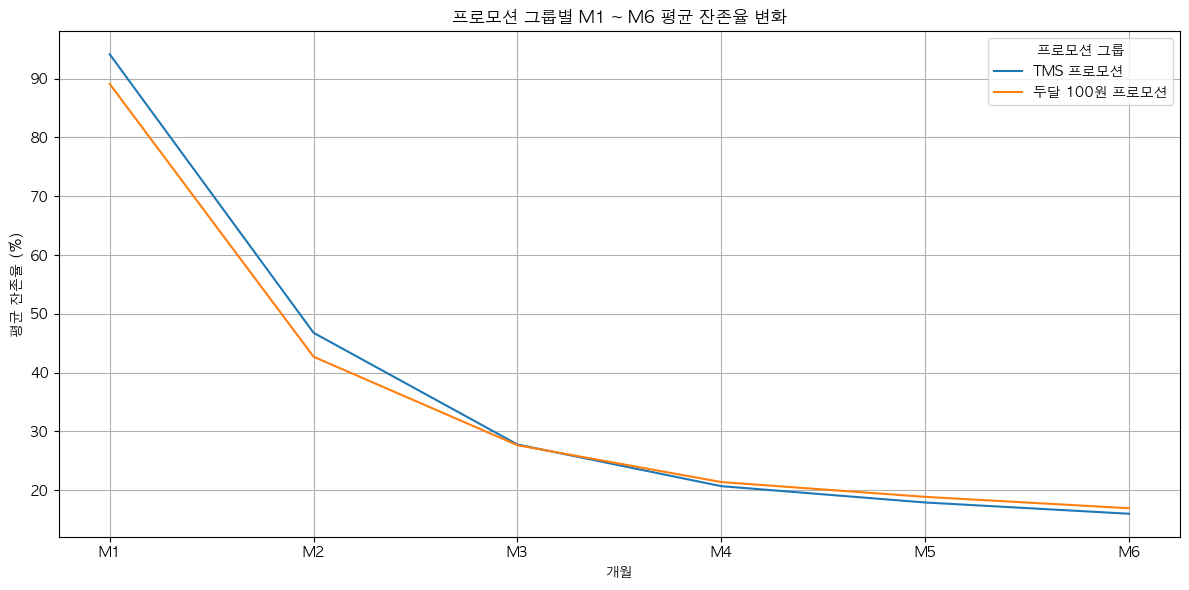

In [40]:
import matplotlib.pyplot as plt

# 1. YM 단위로 평균 잔존율 계산
ym_mean_retention = promo_2month_retention_df.groupby(["YM", "PROMO_GRP_NM"])[["M1_PROD_RATE", "M2_PROD_RATE", "M3_PROD_RATE", "M4_PROD_RATE", "M5_PROD_RATE", "M6_PROD_RATE"]].mean()
print("YM 단위 평균 잔존율:")
print(ym_mean_retention)

# Reset index for easier manipulation
ym_mean_retention = ym_mean_retention.reset_index()

# 2. M1 ~ M6을 X축으로 설정하여 시각화
plt.figure(figsize=(12, 6))

# Plot each promotion group
for promo_grp in ym_mean_retention["PROMO_GRP_NM"].unique():
    # 프로모션 그룹별 평균 잔존율 추출
    promo_data = ym_mean_retention[ym_mean_retention["PROMO_GRP_NM"] == promo_grp]
    # M1 ~ M6 평균 잔존율 계산
    avg_retention = promo_data[["M1_PROD_RATE", "M2_PROD_RATE", "M3_PROD_RATE", "M4_PROD_RATE", "M5_PROD_RATE", "M6_PROD_RATE"]].mean()
    plt.plot(["M1", "M2", "M3", "M4", "M5", "M6"], avg_retention, label=promo_grp)

# 그래프 설정
plt.title("프로모션 그룹별 M1 ~ M6 평균 잔존율 변화")
plt.ylabel("평균 잔존율 (%)")
plt.xlabel("개월")
plt.legend(title="프로모션 그룹")
plt.grid(True)
plt.tight_layout()
plt.show()

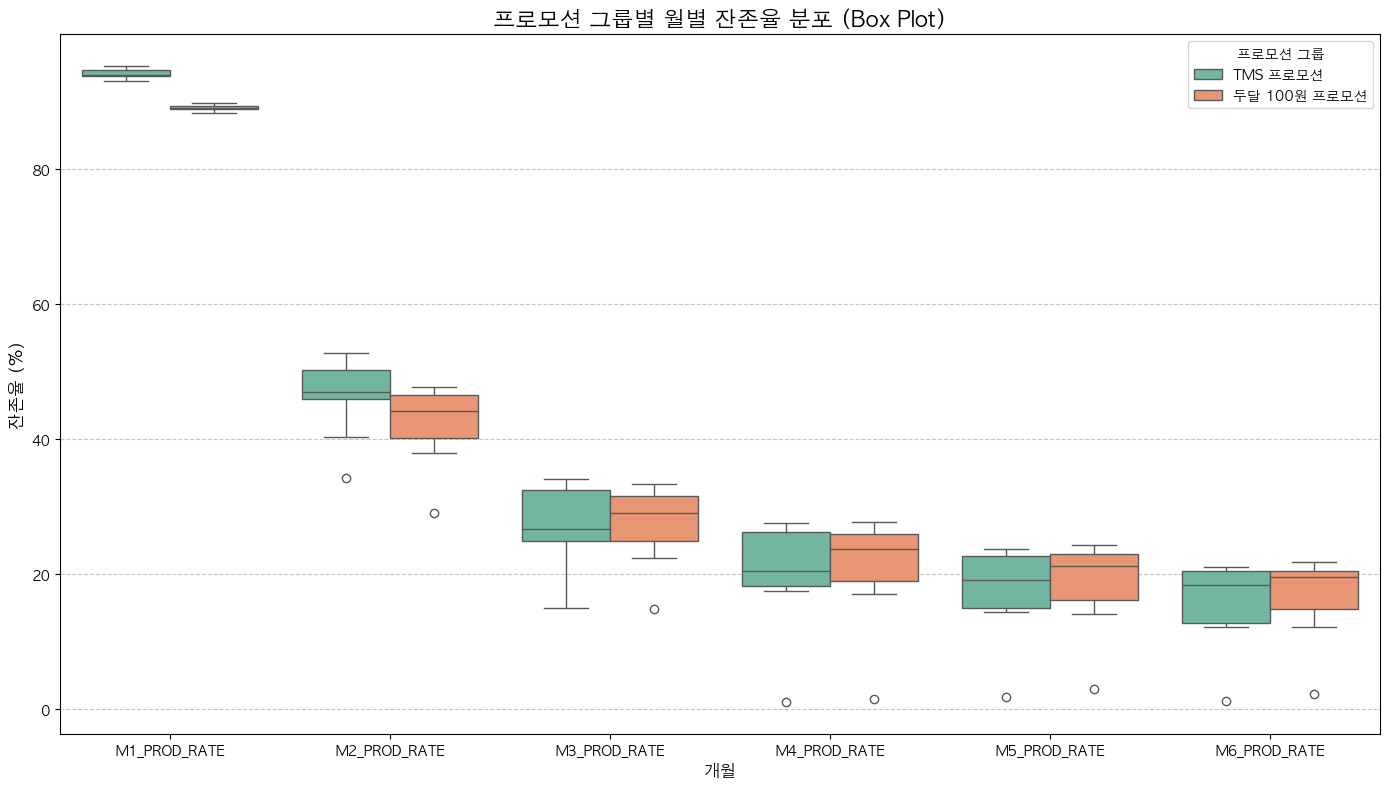

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 준비
# YM 단위 평균 잔존율 데이터에서 Box Plot을 그리기 위해 데이터 변환
boxplot_data = promo_2month_retention_df.melt(
    id_vars=["YM", "PROMO_GRP_NM"], 
    value_vars=["M1_PROD_RATE", "M2_PROD_RATE", "M3_PROD_RATE", "M4_PROD_RATE", "M5_PROD_RATE", "M6_PROD_RATE"],
    var_name="Month", 
    value_name="Retention Rate"
)

# Month 열의 순서를 정렬
boxplot_data["Month"] = pd.Categorical(
    boxplot_data["Month"], 
    categories=["M1_PROD_RATE", "M2_PROD_RATE", "M3_PROD_RATE", "M4_PROD_RATE", "M5_PROD_RATE", "M6_PROD_RATE"], 
    ordered=True
)

# 2. Box Plot 그리기
plt.figure(figsize=(14, 8))
sns.boxplot(
    data=boxplot_data, 
    x="Month", 
    y="Retention Rate", 
    hue="PROMO_GRP_NM", 
    palette="Set2"
)

# 그래프 설정
plt.title("프로모션 그룹별 월별 잔존율 분포 (Box Plot)", fontsize=16)
plt.xlabel("개월", fontsize=12)
plt.ylabel("잔존율 (%)", fontsize=12)
plt.legend(title="프로모션 그룹", loc="upper right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

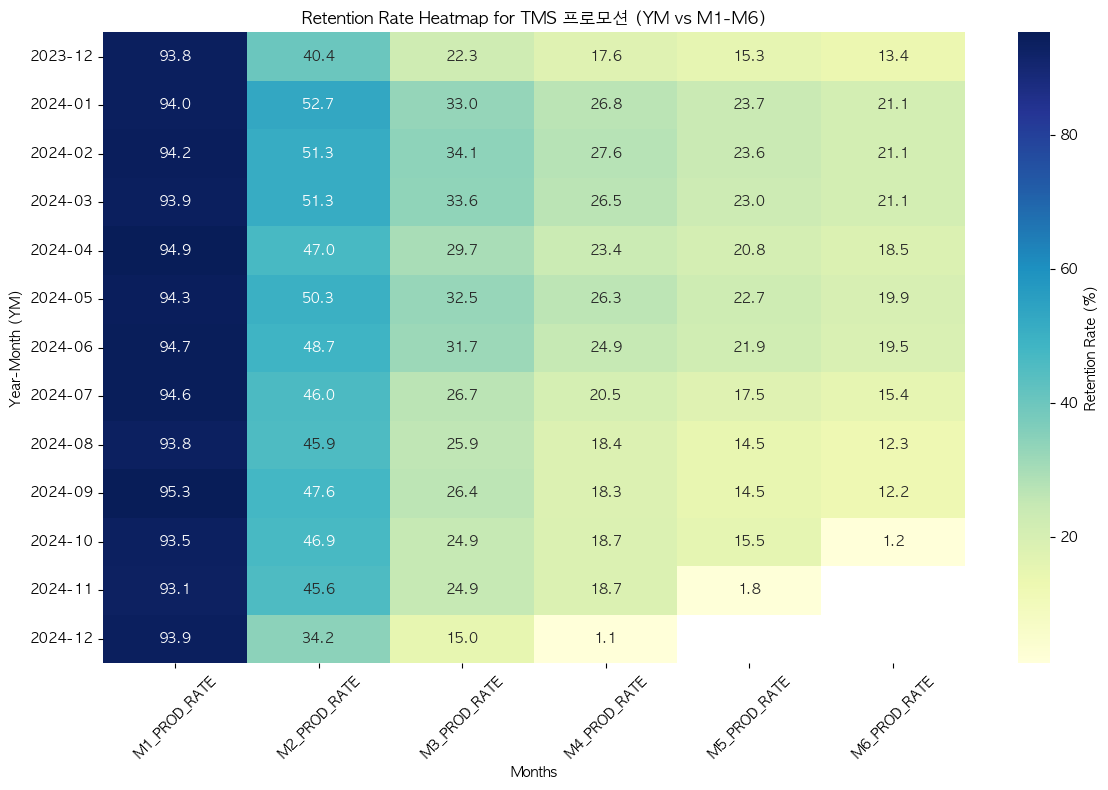

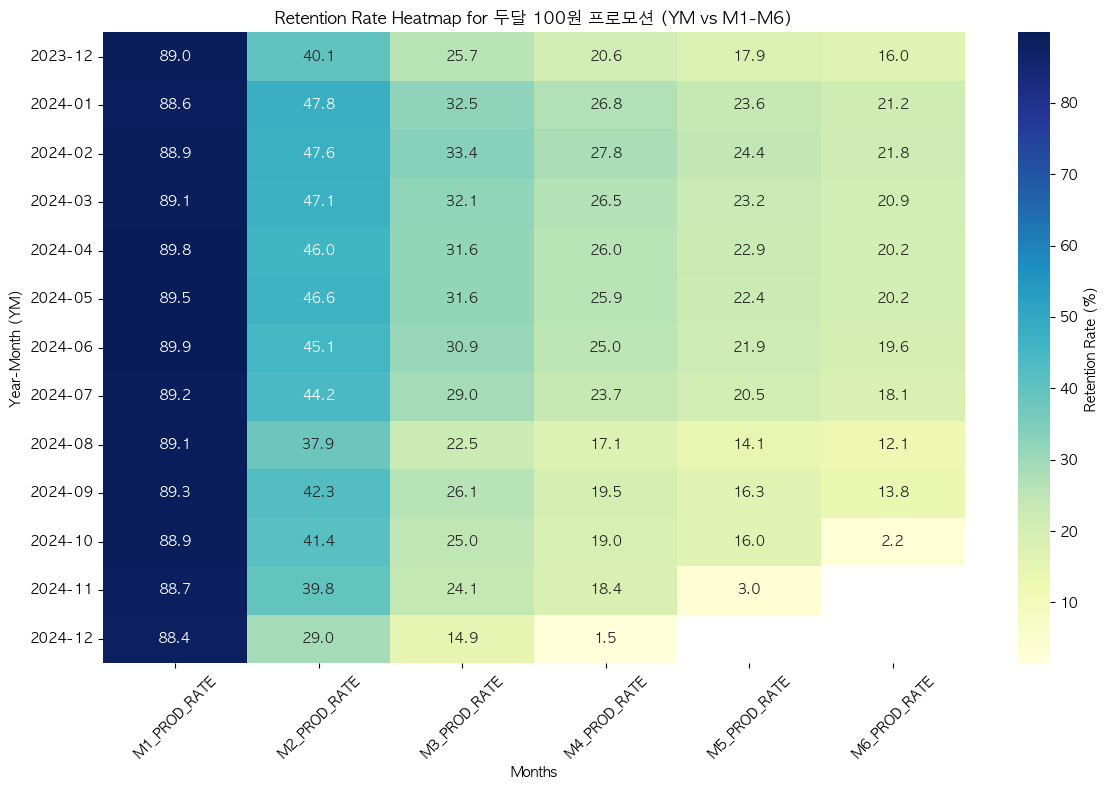

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 데이터 준비
# promo_2month_retention_df에서 필요한 열만 선택
heatmap_data = promo_2month_retention_df.melt(
    id_vars=["YM", "PROMO_GRP_NM"],  # PROMO_GRP_NM 추가
    value_vars=["M1_PROD_RATE", "M2_PROD_RATE", "M3_PROD_RATE", "M4_PROD_RATE", "M5_PROD_RATE", "M6_PROD_RATE"],
    var_name="Month", 
    value_name="Retention Rate"
)

# Month 열의 순서를 정렬
heatmap_data["Month"] = pd.Categorical(heatmap_data["Month"], categories=["M1_PROD_RATE", "M2_PROD_RATE", "M3_PROD_RATE", "M4_PROD_RATE", "M5_PROD_RATE", "M6_PROD_RATE"], ordered=True)

# 2. 프로모션 그룹별로 Heatmap 생성
promo_groups = heatmap_data["PROMO_GRP_NM"].unique()  # 프로모션 그룹 리스트

for promo_grp in promo_groups:
    # 특정 프로모션 그룹 데이터 필터링
    promo_data = heatmap_data[heatmap_data["PROMO_GRP_NM"] == promo_grp]
    
    # 피벗 테이블 생성 (YM을 Y축, Month를 X축으로 설정)
    heatmap_pivot = promo_data.pivot(index="YM", columns="Month", values="Retention Rate")
    
    # Heatmap 그리기
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_pivot, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Retention Rate (%)'})
    plt.title(f"Retention Rate Heatmap for {promo_grp} (YM vs M1-M6)")
    plt.xlabel("Months")
    plt.ylabel("Year-Month (YM)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

프로모션 그룹별 잔존율 표준편차:
              M1_PROD_RATE  M2_PROD_RATE  M3_PROD_RATE  M4_PROD_RATE  \
PROMO_GRP_NM                                                           
TMS 프로모션           0.61056      4.943542      5.460911      6.999612   
두달 100원 프로모션       0.43409      5.235541      5.289010      7.010697   

              M5_PROD_RATE  M6_PROD_RATE  
PROMO_GRP_NM                              
TMS 프로모션          6.286924      6.034938  
두달 100원 프로모션      6.047251      5.803693  


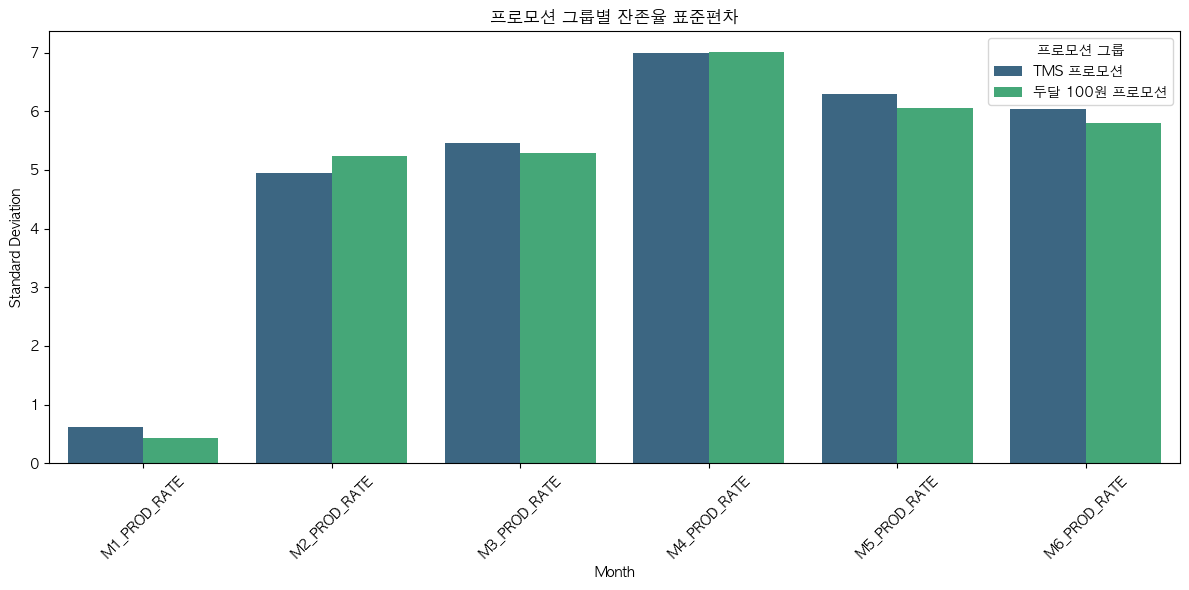

In [43]:
# 1. 프로모션 그룹별 잔존율 표준편차 계산
std_dev = promo_2month_retention_df.groupby("PROMO_GRP_NM")[["M1_PROD_RATE", "M2_PROD_RATE", "M3_PROD_RATE", "M4_PROD_RATE", "M5_PROD_RATE", "M6_PROD_RATE"]].std()

# 표준편차 결과 출력
print("프로모션 그룹별 잔존율 표준편차:")
print(std_dev)

# 2. 시각화를 위해 데이터 변환
std_dev = std_dev.reset_index()  # 인덱스를 열로 변환
std_dev_melted = std_dev.melt(id_vars="PROMO_GRP_NM", var_name="Month", value_name="Standard Deviation")

# 3. 시각화: 프로모션 그룹별 잔존율 표준편차
plt.figure(figsize=(12, 6))
sns.barplot(data=std_dev_melted, x="Month", y="Standard Deviation", hue="PROMO_GRP_NM", palette="viridis")
plt.title("프로모션 그룹별 잔존율 표준편차")
plt.ylabel("Standard Deviation")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.legend(title="프로모션 그룹")
plt.tight_layout()
plt.show()

In [57]:
## 프로모션 그룹 및 할인율 그룹에 따른 정상가 전환 상품 비율
normal_price_prod_query = '''
    WITH term_data as(
        SELECT
            DATE_FORMAT(FST_DT, '%Y-%m') AS FST_DT
          , FIRST_BUY_NO
          , PROMO_GRP_NM
          , PROMO_DC_GRP
          , DT
          , BUY_NO
          , normal_price_yn 
          , IF(NEW_TERM = LAG(NEW_TERM) OVER (PARTITION BY FST_DT, FIRST_BUY_NO, MEMBER_KEY ORDER BY DT), NEW_TERM+1, NEW_TERM) AS TERM
        FROM (
            SELECT 
                FST_DT
              , FIRST_BUY_NO
              , PROMO_GRP_NM
              , PROMO_DC_GRP
              , MEMBER_KEY
              , DT
              , BUY_NO
              , normal_price_yn
              , CASE
                    WHEN (BF_TERM + 1) = TERM THEN TERM
                    WHEN (BF_TERM + 1) <> TERM AND (MONTH(BF_DT) = MONTH(DT)) THEN (TERM + 1)
                    ELSE TERM
                END AS NEW_TERM
            FROM (
                SELECT
                    FST_DT
                  , FIRST_BUY_NO
                  , PROMO_GRP_NM
                  , PROMO_DC_GRP
                  , MEMBER_KEY
                  , DT
                  , BUY_NO
                  , normal_price_yn
                  , TERM
                  , COALESCE(LAG(DT)     OVER (PARTITION BY FST_DT, FIRST_BUY_NO, MEMBER_KEY ORDER BY DT), FST_DT) AS BF_DT
                  , COALESCE(LAG(BUY_NO) OVER (PARTITION BY FST_DT, FIRST_BUY_NO, MEMBER_KEY ORDER BY DT), FIRST_BUY_NO) AS BF_BUY_NO
                  , COALESCE(LAG(TERM)   OVER (PARTITION BY FST_DT, FIRST_BUY_NO, MEMBER_KEY ORDER BY DT), 0) AS BF_TERM
                FROM (
                    SELECT F1.DT AS FST_DT
                         , F1.FIRST_BUY_NO
                         , F1.PROMO_GRP_NM
                         , F1.PROMO_DC_GRP
                         , F1.MEMBER_KEY
                         , F2.BUY_NO
                         , F2.normal_price_yn
                         , F2.DT
                         , DATE_DIFF('MONTH', F1.DT, F2.DT) AS TERM
                    FROM (
                        SELECT T1.DT
                             , T1.FIRST_BUY_NO
                             , T1.BUY_NO
                             , T1.USER_MKEY AS MEMBER_KEY
                             , T5.PROMO_DC_GRP
                             , T3.PROMO_GRP_CD
                             , T6.PROMO_GRP_NM
                        FROM HADOOP_KENT.MELON_MA_STAT_PRODUCTION.F_PROD_USER_FXMT_DT T1
                        JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROD T2  ON (T1.PROD_ID = T2.PROD_ID)
                        JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROMO T3 ON (T1.PROMO_ID = T3.PROMO_ID)
                        JOIN HADOOP_KENT.MELON_ODS_COMMERCE_PRODUCTION.CPT_PROD_TB_RO T4 ON (T1.PROD_ID = T4.PROD_ID)
                        JOIN(
                            SELECT PROMO_DC_GRP_CD
                                 , PROMO_DC_GRP_NM
                                 , CASE
                                    WHEN PROMO_DC_GRP_CD IN (2,3,4) THEN '1개월 0원 + 장기할인'
                                    WHEN PROMO_DC_GRP_CD IN (5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,83,86,87,88,91,93,94,98,109) THEN '1개월 100원 + 할인'
                                    WHEN PROMO_DC_GRP_CD IN (95,101,102) THEN '1개월 할인'
                                    WHEN PROMO_DC_GRP_CD IN (28,29,30,31,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51) THEN '2개월 할인'
                                    WHEN PROMO_DC_GRP_CD IN (33,103) THEN '2개월 100원 + 할인'
                                    WHEN PROMO_DC_GRP_CD IN (54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,70,71,72,73,74,75,76,77,78,81,82,84,85,89,90,92,96,97,99,100,104,110,107,108) THEN '장기할인(3개월이상)'
                                    ELSE PROMO_DC_GRP_NM
                                   END AS PROMO_DC_GRP
                            FROM HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROMO_DC_GRP
                        ) T5 ON T3.PROMO_DC_GRP_CD = T5.PROMO_DC_GRP_CD
                        left join hadoop_kent.melon_ma_stat_production.d_promo_grp t6 on t3.promo_grp_cd = t6.promo_grp_cd
                        WHERE T1.LOG_DATE BETWEEN '20231201' AND '20241231'
                          AND DATE_FORMAT(T1.DT, '%Y%m%d') BETWEEN '20231201' AND '20241231'
                          AND PF_YN = 1
                          AND T2.PROD_ATTR_CD NOT IN (10040, 10050)
                          AND T1.PROD_JOIN_PRT_CD = 1100 --IN (1100, 1200, 1201, 1205, 1203,1206,1207) /*신규 로직에서 1206 제외*/ 
                          AND T2.PROD_SELL_PRT_CD IN (60000) /*B2C*/
                          AND PROD_PRT_CD = 20000  /*클럽 상품*/
                          AND T3.PROMO_GRP_CD NOT IN (49,9999,41,68)
                          AND T5.PROMO_DC_GRP IN ('2개월 100원','3개월 100원','1개월 100원 + 할인','2개월 0원')
                        GROUP BY 1, 2, 3, 4,5, 6, 7

                    ) F1
                    LEFT OUTER JOIN (
                        SELECT DT
                             , FIRST_BUY_NO
                             , BUY_NO
                             , USER_MKEY AS MEMBER_KEY
                             , t2.sale_amt
                             , t1.prim_bill_mthd_bill_amt
                             , if(t1.prim_bill_mthd_bill_amt = t2.sale_amt,'Y','N') as normal_price_yn
                        FROM HADOOP_KENT.MELON_MA_STAT_PRODUCTION.F_PROD_USER_FXMT_DT  T1
                        JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROD               T2 ON (T1.PROD_ID = T2.PROD_ID)
                        JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROMO              T3 ON (T1.PROMO_ID = T3.PROMO_ID)
                        JOIN HADOOP_KENT.MELON_ODS_COMMERCE_PRODUCTION.CPT_PROD_TB_RO     T4 ON (T1.PROD_ID = T4.PROD_ID)
                        WHERE T1.LOG_DATE >= '20231201'
                          AND DATE_FORMAT(T1.DT, '%Y%m%d') >= '20231201'
                          AND PF_YN = 1
                          AND T2.PROD_ATTR_CD NOT IN (10040, 10050)
                          AND T1.PROD_JOIN_PRT_CD IN (1202) /*자결*/
                          AND T2.PROD_SELL_PRT_CD IN (60000) /*B2C*/
                          AND SELL_TYPE_CODE = 'ON1300'
                        GROUP BY 1, 2, 3, 4, 5, 6
                    ) F2 ON (F1.FIRST_BUY_NO = F2.FIRST_BUY_NO AND F1.MEMBER_KEY = F2.MEMBER_KEY AND F2.BUY_NO > F1.BUY_NO)
                ) F3
            ) DF1
        ) DF2
)

SELECT F1.PROMO_GRP_NM
     , F1.PROMO_DC_GRP
     , F1.FST_DT
     , F1.FST_PROD_CNT
     , F1.fst_normal_price_term
     , F2.prod_cnt as normal_termm_prod_cnt
     , F3.prod_cnt as normal_term_1m_prod_cnt
     , cast(F2.prod_cnt as double)/cast(f1.fst_prod_cnt as double)*100 as normal_term_prod_ratio
     , cast(F3.prod_cnt as double)/cast(f1.fst_prod_cnt as double)*100 as normal_term_1m_prod_ratio
FROM(
    SELECT
        PROMO_GRP_NM
      , PROMO_DC_GRP
      , FST_DT
      , COUNT(DISTINCT FIRST_BUY_NO) AS FST_PROD_CNT
      , min(if(normal_price_yn = 'Y',term)) as fst_normal_price_term
    FROM term_data
    GROUP BY 1,2,3
    HAVING(COUNT(DISTINCT FIRST_BUY_NO) > 1000)
    ORDER BY 1,2,3
) F1
LEFT JOIN(
    SELECT 
        PROMO_GRP_NM
      , PROMO_DC_GRP
      , FST_DT
      , term
      , count(distinct buy_no) as prod_cnt
    FROM term_data
    GROUP BY 1,2,3,4
) F2 ON F1.PROMO_GRP_NM = F2.PROMO_GRP_NM AND F1.PROMO_DC_GRP = F2.PROMO_DC_GRP AND F1.FST_DT = F2.FST_DT AND F2.TERM = F1.fst_normal_price_term
LEFT JOIN(
    SELECT 
        PROMO_GRP_NM
      , PROMO_DC_GRP
      , FST_DT
      , term
      , count(distinct buy_no) as prod_cnt
    FROM term_data
    GROUP BY 1,2,3,4
) F3 ON F1.PROMO_GRP_NM = F3.PROMO_GRP_NM AND F1.PROMO_DC_GRP = F3.PROMO_DC_GRP AND F1.FST_DT = F3.FST_DT AND F3.TERM = F1.fst_normal_price_term + 1
order by 2,1,3
'''

cur.execute(normal_price_prod_query)

results = cur.fetchall()
colnames = [part[0] for part in cur.description]

normal_price_prod_df = pd.DataFrame(results, columns=colnames)

cur.cancel()
conn.close()
normal_price_prod_df.head()

,promo_grp_nm,promo_dc_grp,fst_dt,fst_prod_cnt,fst_normal_price_term,normal_termm_prod_cnt,normal_term_1m_prod_cnt,normal_term_prod_ratio,normal_term_1m_prod_ratio
0,N개월 N원 프로모션,1개월 100원 + 할인,2023-12,45543,3,13709,11143,30.101223,24.466987
1,N개월 N원 프로모션,1개월 100원 + 할인,2024-01,85031,3,26859,21703,31.587303,25.523633
2,N개월 N원 프로모션,1개월 100원 + 할인,2024-02,80107,3,25687,20541,32.065862,25.641954
3,N개월 N원 프로모션,1개월 100원 + 할인,2024-03,76402,3,24909,20069,32.602550,26.267637
4,N개월 N원 프로모션,1개월 100원 + 할인,2024-04,67975,3,22473,17780,33.060684,26.156675


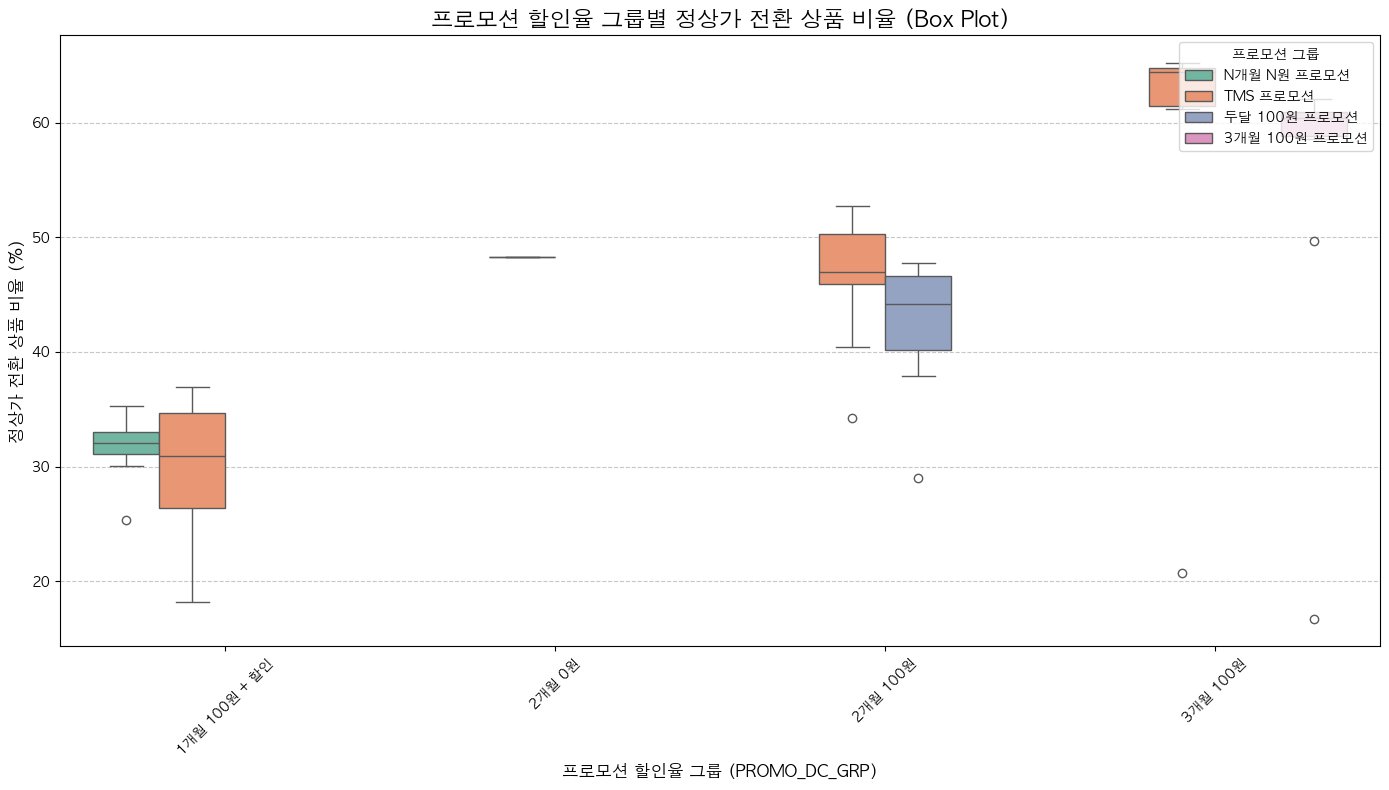

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Box Plot 그리기
plt.figure(figsize=(14, 8))
sns.boxplot(
    data=normal_price_prod_df,
    x="promo_dc_grp",
    y="normal_term_prod_ratio",
    hue="promo_grp_nm",  # PROMO_GRP_NM 기준으로 나눔
    palette="Set2"  # 색상 팔레트 설정
)

# 2. 그래프 설정
plt.title("프로모션 할인율 그룹별 정상가 전환 상품 비율 (Box Plot)", fontsize=16)
plt.xlabel("프로모션 할인율 그룹 (PROMO_DC_GRP)", fontsize=12)
plt.ylabel("정상가 전환 상품 비율 (%)", fontsize=12)
plt.xticks(rotation=45)  # X축 레이블 회전
plt.legend(title="프로모션 그룹", loc="upper right")
plt.grid(axis="y", linestyle="--", alpha=0.7)  # Y축 격자 추가
plt.tight_layout()
plt.show()

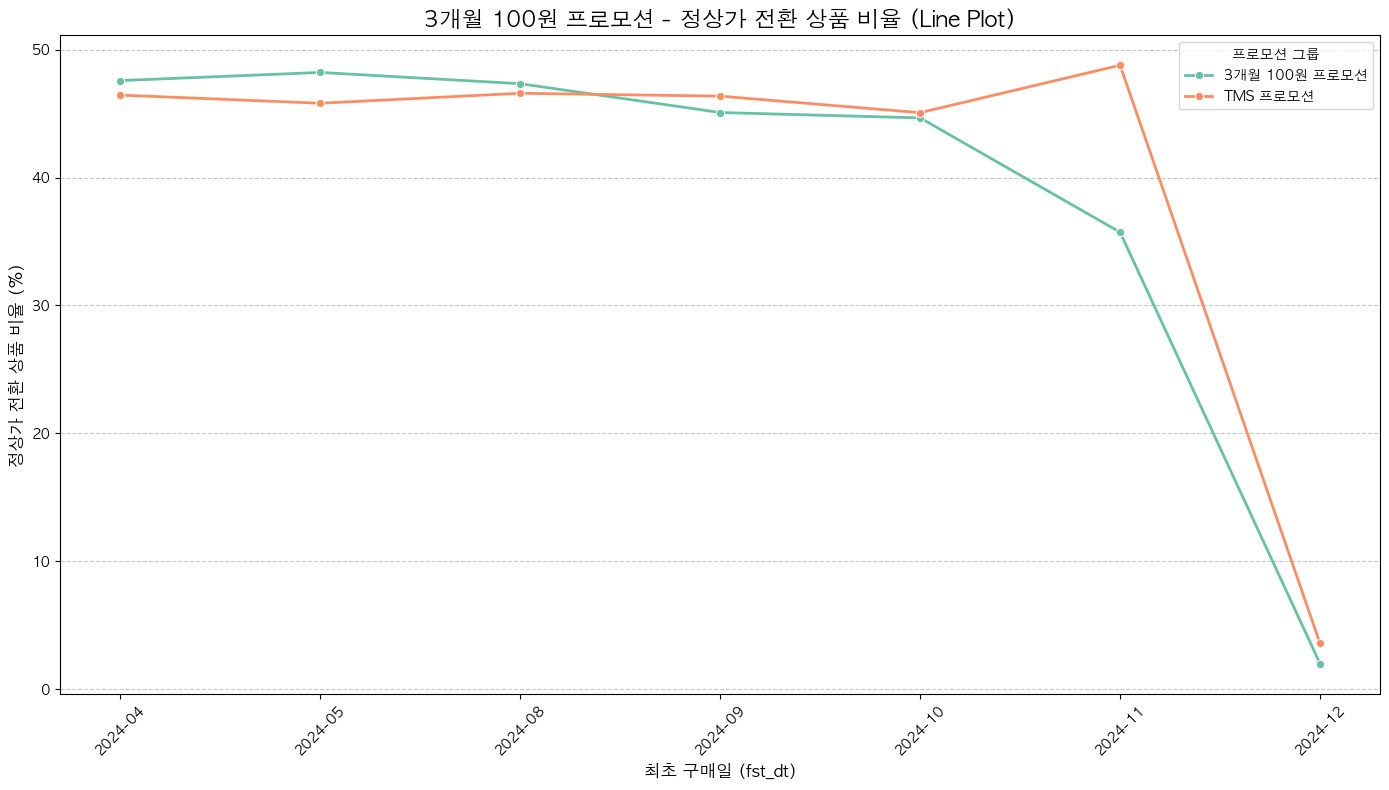

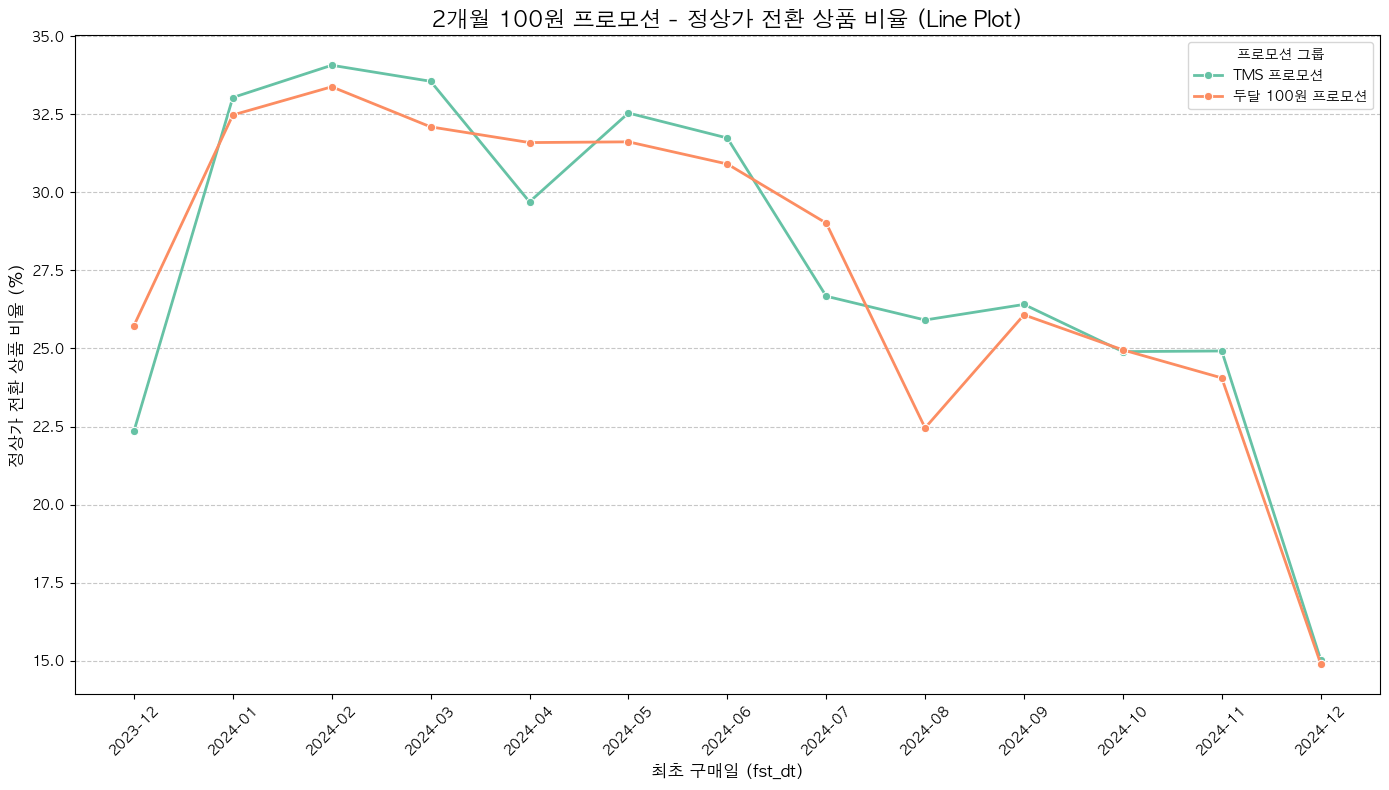

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 필터링
filtered_data = normal_price_prod_df[normal_price_prod_df["promo_dc_grp"] == "3개월 100원"]

# 1. TMS 프로모션이 포함된 년월 필터링
tms_months = filtered_data[filtered_data["promo_grp_nm"] == "TMS 프로모션"]["fst_dt"].unique()
filtered_data = filtered_data[filtered_data["fst_dt"].isin(tms_months)]


# 2. Line Plot 그리기
plt.figure(figsize=(14, 8))
sns.lineplot(
    data=filtered_data,
    x="fst_dt",  # X축: 최초 구매일
    y="normal_term_1m_prod_ratio",  # Y축: 정상가 전환 상품 비율
    hue="promo_grp_nm",  # 프로모션 그룹별로 나눔
    marker="o",
    palette="Set2",
    linewidth=2
)

# 3. 그래프 설정
plt.title("3개월 100원 프로모션 - 정상가 전환 상품 비율 (Line Plot)", fontsize=16)
plt.xlabel("최초 구매일 (fst_dt)", fontsize=12)
plt.ylabel("정상가 전환 상품 비율 (%)", fontsize=12)
plt.xticks(rotation=45)  # X축 레이블 회전
plt.legend(title="프로모션 그룹", loc="upper right")
plt.grid(axis="y", linestyle="--", alpha=0.7)  # Y축 격자 추가
plt.tight_layout()
plt.show()


# 1. 데이터 필터링
filtered_data = normal_price_prod_df[normal_price_prod_df["promo_dc_grp"] == "2개월 100원"]

# 1. TMS 프로모션이 포함된 년월 필터링
tms_months = filtered_data[filtered_data["promo_grp_nm"] == "TMS 프로모션"]["fst_dt"].unique()
filtered_data = filtered_data[filtered_data["fst_dt"].isin(tms_months)]


# 2. Line Plot 그리기
plt.figure(figsize=(14, 8))
sns.lineplot(
    data=filtered_data,
    x="fst_dt",  # X축: 최초 구매일
    y="normal_term_1m_prod_ratio",  # Y축: 정상가 전환 상품 비율
    hue="promo_grp_nm",  # 프로모션 그룹별로 나눔
    marker="o",
    palette="Set2",
    linewidth=2
)

# 3. 그래프 설정
plt.title("2개월 100원 프로모션 - 정상가 전환 상품 비율 (Line Plot)", fontsize=16)
plt.xlabel("최초 구매일 (fst_dt)", fontsize=12)
plt.ylabel("정상가 전환 상품 비율 (%)", fontsize=12)
plt.xticks(rotation=45)  # X축 레이블 회전
plt.legend(title="프로모션 그룹", loc="upper right")
plt.grid(axis="y", linestyle="--", alpha=0.7)  # Y축 격자 추가
plt.tight_layout()
plt.show()

In [63]:
normal_price_prod_df.head()

,promo_grp_nm,promo_dc_grp,fst_dt,fst_prod_cnt,fst_normal_price_term,normal_termm_prod_cnt,normal_term_1m_prod_cnt,normal_term_prod_ratio,normal_term_1m_prod_ratio
0,N개월 N원 프로모션,1개월 100원 + 할인,2023-12,45543,3,13709,11143,30.101223,24.466987
1,N개월 N원 프로모션,1개월 100원 + 할인,2024-01,85031,3,26859,21703,31.587303,25.523633
2,N개월 N원 프로모션,1개월 100원 + 할인,2024-02,80107,3,25687,20541,32.065862,25.641954
3,N개월 N원 프로모션,1개월 100원 + 할인,2024-03,76402,3,24909,20069,32.602550,26.267637
4,N개월 N원 프로모션,1개월 100원 + 할인,2024-04,67975,3,22473,17780,33.060684,26.156675


In [112]:
from scipy.stats import f_oneway

# 1. PROMO_DC_GRP별 ANOVA 분석
# "2개월 0원" 제외
promo_dc_grps = normal_price_prod_df["promo_dc_grp"].unique()
promo_dc_grps = [grp for grp in promo_dc_grps if grp != "2개월 0원"]  # "2개월 0원" 제거

for promo_dc_grp in promo_dc_grps:
    # 특정 PROMO_DC_GRP 데이터 필터링
    filtered_data = normal_price_prod_df[normal_price_prod_df["promo_dc_grp"] == promo_dc_grp]
    
    # 각 프로모션 그룹별 데이터 추출
    tms_data = filtered_data[filtered_data["promo_grp_nm"] == "TMS 프로모션"]["normal_term_prod_ratio"]
    other_groups = filtered_data[filtered_data["promo_grp_nm"] != "TMS 프로모션"]["promo_grp_nm"].unique()
    
    # 다른 프로모션 그룹 데이터 추출
    group_data = [filtered_data[filtered_data["promo_grp_nm"] == group]["normal_term_prod_ratio"] for group in other_groups]
    
    # ANOVA 수행
    f_stat, p_value = f_oneway(tms_data, *group_data)
    
    # 결과 출력
    print(f"promo_dc_grp: {promo_dc_grp}")
    print(f"프로모션 그룹 구성: {filtered_data['promo_grp_nm'].unique()}")
    print(f"F-statistic: {f_stat:.4f}, P-value: {p_value:.4f}")
    print("-" * 50)

# 추가로 특정 그룹 간 ANOVA 수행 (예시)
tms_data = normal_price_prod_df[normal_price_prod_df["promo_grp_nm"] == "TMS 프로모션"]["normal_term_prod_ratio"]
group1_data = normal_price_prod_df[normal_price_prod_df["promo_grp_nm"] == "3개월 100원 프로모션"]["normal_term_prod_ratio"]
group2_data = normal_price_prod_df[normal_price_prod_df["promo_grp_nm"] == "2개월 100원 프로모션"]["normal_term_prod_ratio"]

f_stat, p_value = f_oneway(tms_data, group1_data, group2_data)
print(f"F-statistic: {f_stat}, P-value: {p_value}")

promo_dc_grp: 1개월 100원 + 할인
프로모션 그룹 구성: ['N개월 N원 프로모션' 'TMS 프로모션']
F-statistic: 0.6661, P-value: 0.4225
--------------------------------------------------
promo_dc_grp: 2개월 100원
프로모션 그룹 구성: ['TMS 프로모션' '두달 100원 프로모션']
F-statistic: 4.1605, P-value: 0.0525
--------------------------------------------------
promo_dc_grp: 3개월 100원
프로모션 그룹 구성: ['3개월 100원 프로모션' 'TMS 프로모션']
F-statistic: 0.0601, P-value: 0.8093
--------------------------------------------------
F-statistic: nan, P-value: nan


/var/folders/qw/6lks7c5d14scf7qtctm8m6jh0000gn/T/ipykernel_80999/212327643.py:33: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  f_stat, p_value = f_oneway(tms_data, group1_data, group2_data)


In [69]:
from scipy.stats import f_oneway

# 1. PROMO_DC_GRP별 ANOVA 분석
# "2개월 0원" 제외
promo_dc_grps = normal_price_prod_df["promo_dc_grp"].unique()
promo_dc_grps = [grp for grp in promo_dc_grps if grp != "2개월 0원"]  # "2개월 0원" 제거

for promo_dc_grp in promo_dc_grps:
    # 특정 PROMO_DC_GRP 데이터 필터링
    filtered_data = normal_price_prod_df[normal_price_prod_df["promo_dc_grp"] == promo_dc_grp]
    
    # 각 프로모션 그룹별 데이터 추출
    tms_data = filtered_data[filtered_data["promo_grp_nm"] == "TMS 프로모션"]["normal_term_1m_prod_ratio"]
    other_groups = filtered_data[filtered_data["promo_grp_nm"] != "TMS 프로모션"]["promo_grp_nm"].unique()
    
    # 다른 프로모션 그룹 데이터 추출
    group_data = [filtered_data[filtered_data["promo_grp_nm"] == group]["normal_term_1m_prod_ratio"] for group in other_groups]
    
    # ANOVA 수행
    f_stat, p_value = f_oneway(tms_data, *group_data)
    
    # 결과 출력
    print(f"promo_dc_grp: {promo_dc_grp}")
    print(f"프로모션 그룹 구성: {filtered_data['promo_grp_nm'].unique()}")
    print(f"F-statistic: {f_stat:.4f}, P-value: {p_value:.4f}")
    print("-" * 50)

# 추가로 특정 그룹 간 ANOVA 수행 (예시)
tms_data = normal_price_prod_df[normal_price_prod_df["promo_grp_nm"] == "TMS 프로모션"]["normal_term_1m_prod_ratio"]
group1_data = normal_price_prod_df[normal_price_prod_df["promo_grp_nm"] == "3개월 100원 프로모션"]["normal_term_1m_prod_ratio"]
group2_data = normal_price_prod_df[normal_price_prod_df["promo_grp_nm"] == "2개월 100원 프로모션"]["normal_term_1m_prod_ratio"]

f_stat, p_value = f_oneway(tms_data, group1_data, group2_data)
print(f"F-statistic: {f_stat}, P-value: {p_value}")

promo_dc_grp: 1개월 100원 + 할인
프로모션 그룹 구성: ['N개월 N원 프로모션' 'TMS 프로모션']
F-statistic: 0.9418, P-value: 0.3415
--------------------------------------------------
promo_dc_grp: 2개월 100원
프로모션 그룹 구성: ['TMS 프로모션' '두달 100원 프로모션']
F-statistic: 0.0033, P-value: 0.9548
--------------------------------------------------
promo_dc_grp: 3개월 100원
프로모션 그룹 구성: ['3개월 100원 프로모션' 'TMS 프로모션']
F-statistic: 0.1211, P-value: 0.7321
--------------------------------------------------
F-statistic: nan, P-value: nan


/var/folders/qw/6lks7c5d14scf7qtctm8m6jh0000gn/T/ipykernel_80999/2200878888.py:33: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  f_stat, p_value = f_oneway(tms_data, group1_data, group2_data)


In [ ]:
## 프로모션 그룹 및 할인율 기준에 따른 정상가 전환 상품 비율
normal_price_prod_query_2 = '''
WITH term_data as(
        SELECT
            DATE_FORMAT(FST_DT, '%Y-%m') AS FST_DT
          , FIRST_BUY_NO
          , PROMO_DC_GRP
          , DT
          , AGE
          , GENDER
          , MEMBER_KEY
          , BUY_NO
          , normal_price_yn 
          , IF(NEW_TERM = LAG(NEW_TERM) OVER (PARTITION BY FST_DT, FIRST_BUY_NO, MEMBER_KEY ORDER BY DT), NEW_TERM+1, NEW_TERM) AS TERM
        FROM (
            SELECT 
                FST_DT
              , FIRST_BUY_NO
              , PROMO_DC_GRP
              , MEMBER_KEY
              , AGE
              , GENDER
              , DT
              , BUY_NO
              , normal_price_yn
              , CASE
                    WHEN (BF_TERM + 1) = TERM THEN TERM
                    WHEN (BF_TERM + 1) <> TERM AND (MONTH(BF_DT) = MONTH(DT)) THEN (TERM + 1)
                    ELSE TERM
                END AS NEW_TERM
            FROM (
                SELECT
                    FST_DT
                  , FIRST_BUY_NO
                  , PROMO_DC_GRP
                  , MEMBER_KEY
                  , AGE
                  , GENDER
                  , DT
                  , BUY_NO
                  , normal_price_yn
                  , TERM
                  , COALESCE(LAG(DT)     OVER (PARTITION BY FST_DT, FIRST_BUY_NO, MEMBER_KEY ORDER BY DT), FST_DT) AS BF_DT
                  , COALESCE(LAG(BUY_NO) OVER (PARTITION BY FST_DT, FIRST_BUY_NO, MEMBER_KEY ORDER BY DT), FIRST_BUY_NO) AS BF_BUY_NO
                  , COALESCE(LAG(TERM)   OVER (PARTITION BY FST_DT, FIRST_BUY_NO, MEMBER_KEY ORDER BY DT), 0) AS BF_TERM
                FROM (
                    SELECT F1.DT AS FST_DT
                         , F1.FIRST_BUY_NO
                         , F1.PROMO_DC_GRP
                         , F1.MEMBER_KEY
                         , CASE
                            WHEN AGE_ENT_PRT_CD IN (1,2) THEN '10대이하'
                            WHEN AGE_ENT_PRT_CD IN (3,4) THEN '20대'
                            WHEN AGE_ENT_PRT_CD IN (5,6) THEN '30대'
                            WHEN AGE_ENT_PRT_CD IN (7,8) THEN '40대'
                            WHEN AGE_ENT_PRT_CD IN (9,10) THEN '50대'
                            WHEN AGE_ENT_PRT_CD = 11 THEN '60대이상'
                            ELSE '정보없음'
                           END AS AGE
                         , CASE
                            WHEN MEMBER_GNDR = '1' THEN '남성'
                            WHEN MEMBER_GNDR = '2' THEN '여성'
                            ELSE '정보없음'
                           END AS GENDER
                         , F2.BUY_NO
                         , F2.normal_price_yn
                         , F2.DT
                         , DATE_DIFF('MONTH', F1.DT, F2.DT) AS TERM
                    FROM (
                        SELECT T1.DT
                             , T1.FIRST_BUY_NO
                             , T1.BUY_NO
                             , T1.USER_MKEY AS MEMBER_KEY
                             , T5.PROMO_DC_GRP
                             , T3.PROMO_GRP_CD
                             , T6.PROMO_GRP_NM
                             , T1.LOG_DATE
                        FROM HADOOP_KENT.MELON_MA_STAT_PRODUCTION.F_PROD_USER_FXMT_DT T1
                        JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROD T2  ON (T1.PROD_ID = T2.PROD_ID)
                        JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROMO T3 ON (T1.PROMO_ID = T3.PROMO_ID)
                        JOIN HADOOP_KENT.MELON_ODS_COMMERCE_PRODUCTION.CPT_PROD_TB_RO T4 ON (T1.PROD_ID = T4.PROD_ID)
                        JOIN(
                            SELECT PROMO_DC_GRP_CD
                                 , PROMO_DC_GRP_NM
                                 , CASE
                                    WHEN PROMO_DC_GRP_CD IN (2,3,4) THEN '1개월 0원 + 장기할인'
                                    WHEN PROMO_DC_GRP_CD IN (5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,83,86,87,88,91,93,94,98,109) THEN '1개월 100원 + 할인'
                                    WHEN PROMO_DC_GRP_CD IN (95,101,102) THEN '1개월 할인'
                                    WHEN PROMO_DC_GRP_CD IN (28,29,30,31,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51) THEN '2개월 할인'
                                    WHEN PROMO_DC_GRP_CD IN (33,103) THEN '2개월 100원 + 할인'
                                    WHEN PROMO_DC_GRP_CD IN (54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,70,71,72,73,74,75,76,77,78,81,82,84,85,89,90,92,96,97,99,100,104,110,107,108) THEN '장기할인(3개월이상)'
                                    ELSE PROMO_DC_GRP_NM
                                   END AS PROMO_DC_GRP
                            FROM HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROMO_DC_GRP
                        ) T5 ON T3.PROMO_DC_GRP_CD = T5.PROMO_DC_GRP_CD
                        left join hadoop_kent.melon_ma_stat_production.d_promo_grp t6 on t3.promo_grp_cd = t6.promo_grp_cd
                        WHERE T1.LOG_DATE BETWEEN '20220101' AND '20241231'
                          AND DATE_FORMAT(T1.DT, '%Y%m%d') BETWEEN '20220101' AND '20241231'
                          AND PF_YN = 1
                          AND T2.PROD_ATTR_CD NOT IN (10040, 10050)
                          AND T1.PROD_JOIN_PRT_CD = 1100 --IN (1100, 1200, 1201, 1205, 1203,1206,1207) /*신규 로직에서 1206 제외*/ 
                          AND T2.PROD_SELL_PRT_CD IN (60000) /*B2C*/
                          AND PROD_PRT_CD = 20000  /*클럽 상품*/
                          AND T3.PROMO_GRP_CD NOT IN (49,9999,41,68)
                          --AND T5.PROMO_DC_GRP IN ('2개월 100원')
                        GROUP BY 1, 2, 3, 4,5, 6, 7, 8

                    ) F1
                    LEFT OUTER JOIN (
                        SELECT DT
                             , FIRST_BUY_NO
                             , BUY_NO
                             , USER_MKEY AS MEMBER_KEY
                             , t2.sale_amt
                             , t1.prim_bill_mthd_bill_amt
                             , if(t1.prim_bill_mthd_bill_amt = t2.sale_amt,'Y','N') as normal_price_yn
                        FROM HADOOP_KENT.MELON_MA_STAT_PRODUCTION.F_PROD_USER_FXMT_DT  T1
                        JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROD               T2 ON (T1.PROD_ID = T2.PROD_ID)
                        JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROMO              T3 ON (T1.PROMO_ID = T3.PROMO_ID)
                        JOIN HADOOP_KENT.MELON_ODS_COMMERCE_PRODUCTION.CPT_PROD_TB_RO     T4 ON (T1.PROD_ID = T4.PROD_ID)
                        WHERE T1.LOG_DATE >= '20220101'
                          AND DATE_FORMAT(T1.DT, '%Y%m%d') >= '20220101'
                          AND PF_YN = 1
                          AND T2.PROD_ATTR_CD NOT IN (10040, 10050)
                          AND T1.PROD_JOIN_PRT_CD IN (1202) /*자결*/
                          AND T2.PROD_SELL_PRT_CD IN (60000) /*B2C*/
                          AND SELL_TYPE_CODE = 'ON1300'
                        GROUP BY 1, 2, 3, 4, 5, 6
                    ) F2 ON (F1.FIRST_BUY_NO = F2.FIRST_BUY_NO AND F1.MEMBER_KEY = F2.MEMBER_KEY AND F2.BUY_NO > F1.BUY_NO)
                    LEFT OUTER JOIN(                        
                        SELECT MEMBER_KEY
                             , ipin_gender as MEMBER_GNDR
                             , AGE_ENT_PRT_CD
                        from HADOOP_KENT.melon_ods_poc_production.po_ps_members_tb_ro
                        group by 1,2,3
                    ) F3 ON F1.MEMBER_KEY = F3.MEMBER_KEY
                ) F3
            ) DF1
        ) DF2
)

SELECT F1.FST_DT
     , sum(F1.FST_PROD_CNT) as fst_prod_cnt
     , sum(F2.prod_cnt) as normal_termm_prod_cnt
     , sum(F3.prod_cnt) as normal_term_1m_prod_cnt
     , cast(sum(F2.prod_cnt) as double)/cast(sum(F1.FST_PROD_CNT) as double)*100 as normal_term_prod_ratio
     , cast(sum(F3.prod_cnt) as double)/cast(sum(F1.FST_PROD_CNT) as double)*100 as normal_term_1m_prod_ratio
FROM(
    SELECT
        PROMO_DC_GRP
      , FST_DT
      , COUNT(DISTINCT FIRST_BUY_NO) AS FST_PROD_CNT
      , min(if(normal_price_yn = 'Y',term)) as fst_normal_price_term
    FROM term_data
    GROUP BY 1,2
) F1
LEFT JOIN(
    SELECT 
        PROMO_DC_GRP
      , FST_DT
      , term
      , count(distinct buy_no) as prod_cnt
    FROM term_data
    GROUP BY 1,2,3
) F2 ON F1.PROMO_DC_GRP = F2.PROMO_DC_GRP AND F1.FST_DT = F2.FST_DT AND F2.TERM = F1.fst_normal_price_term 
LEFT JOIN(
    SELECT 
        PROMO_DC_GRP
      , FST_DT
      , term
      , count(distinct buy_no) as prod_cnt
    FROM term_data
    GROUP BY 1,2,3
) F3 ON F1.PROMO_DC_GRP = F3.PROMO_DC_GRP AND F1.FST_DT = F3.FST_DT AND F3.TERM = F1.fst_normal_price_term + 1
group by 1
order by 1
'''

cur.execute(normal_price_prod_query_2)

results = cur.fetchall()
colnames = [part[0] for part in cur.description]

normal_price_prod_2_df = pd.DataFrame(results, columns=colnames)

cur.cancel()
conn.close()
normal_price_prod_2_df.head()

,fst_dt,fst_prod_cnt,normal_termm_prod_cnt,normal_term_1m_prod_cnt,normal_term_prod_ratio,normal_term_1m_prod_ratio
0,2022-01,289858,167033,119813,57.625803,41.335068
1,2022-02,245472,153536,112513,62.547256,45.835370
2,2022-03,307158,180272,134175,58.690316,43.682730
3,2022-04,294636,181354,139042,61.551881,47.191110
4,2022-05,282806,169804,130310,60.042573,46.077523


In [127]:
normal_price_prod_2_df.tail()

,fst_dt,fst_prod_cnt,normal_termm_prod_cnt,normal_term_1m_prod_cnt,normal_term_prod_ratio,normal_term_1m_prod_ratio,non_normal_prod_cnt,year_month
31,2024-08-01,218731,95000,74800,43.432344,34.197256,123731,2024-08
32,2024-09-01,218179,93278,71746,42.752969,32.884008,124901,2024-09
33,2024-10-01,221820,93991,72727,42.372644,32.786494,127829,2024-10
34,2024-11-01,217899,89316,67691,40.989633,31.065310,128583,2024-11
35,2024-12-01,235052,70568,29722,30.022293,12.644862,164484,2024-12


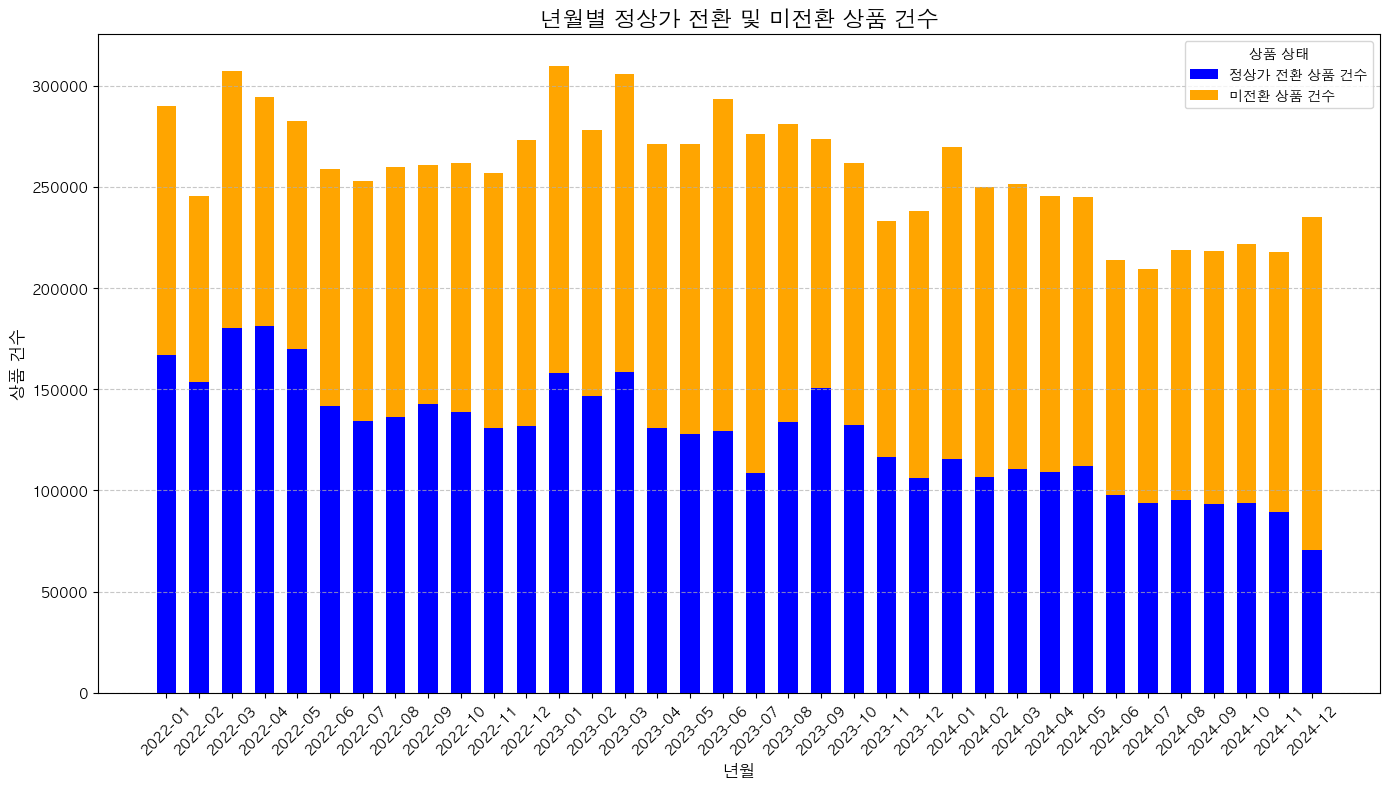

In [122]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 데이터 준비
# fst_dt를 날짜 형식으로 변환
normal_price_prod_2_df["fst_dt"] = pd.to_datetime(normal_price_prod_2_df["fst_dt"])

# 년월 단위로 그룹화
normal_price_prod_2_df["year_month"] = normal_price_prod_2_df["fst_dt"].dt.to_period("M")

# 미전환 상품건수 계산
normal_price_prod_2_df["non_normal_prod_cnt"] = normal_price_prod_2_df["fst_prod_cnt"] - normal_price_prod_2_df["normal_termm_prod_cnt"]

# 년월별 데이터 집계 (datetime64 타입 제외)
grouped_data = normal_price_prod_2_df.groupby("year_month")[["normal_termm_prod_cnt", "non_normal_prod_cnt"]].sum().reset_index()

# 2. Stacked Bar Plot 그리기
plt.figure(figsize=(14, 8))

# 정상가 전환 상품 건수
plt.bar(
    grouped_data["year_month"].astype(str),  # X축을 문자열로 변환
    grouped_data["normal_termm_prod_cnt"],
    label="정상가 전환 상품 건수",
    color="blue",
    width=0.6  # 막대 너비 조정
)

# 미전환 상품 건수
plt.bar(
    grouped_data["year_month"].astype(str),
    grouped_data["non_normal_prod_cnt"],
    bottom=grouped_data["normal_termm_prod_cnt"],
    label="미전환 상품 건수",
    color="orange",
    width=0.6  # 막대 너비 조정
)

# 3. 그래프 설정
plt.title("년월별 정상가 전환 및 미전환 상품 건수", fontsize=16)
plt.xlabel("년월", fontsize=12)
plt.ylabel("상품 건수", fontsize=12)
plt.xticks(rotation=45)  # X축 레이블 회전
plt.legend(title="상품 상태", loc="upper right")
plt.grid(axis="y", linestyle="--", alpha=0.7)  # Y축 격자 추가
plt.tight_layout()
plt.show()

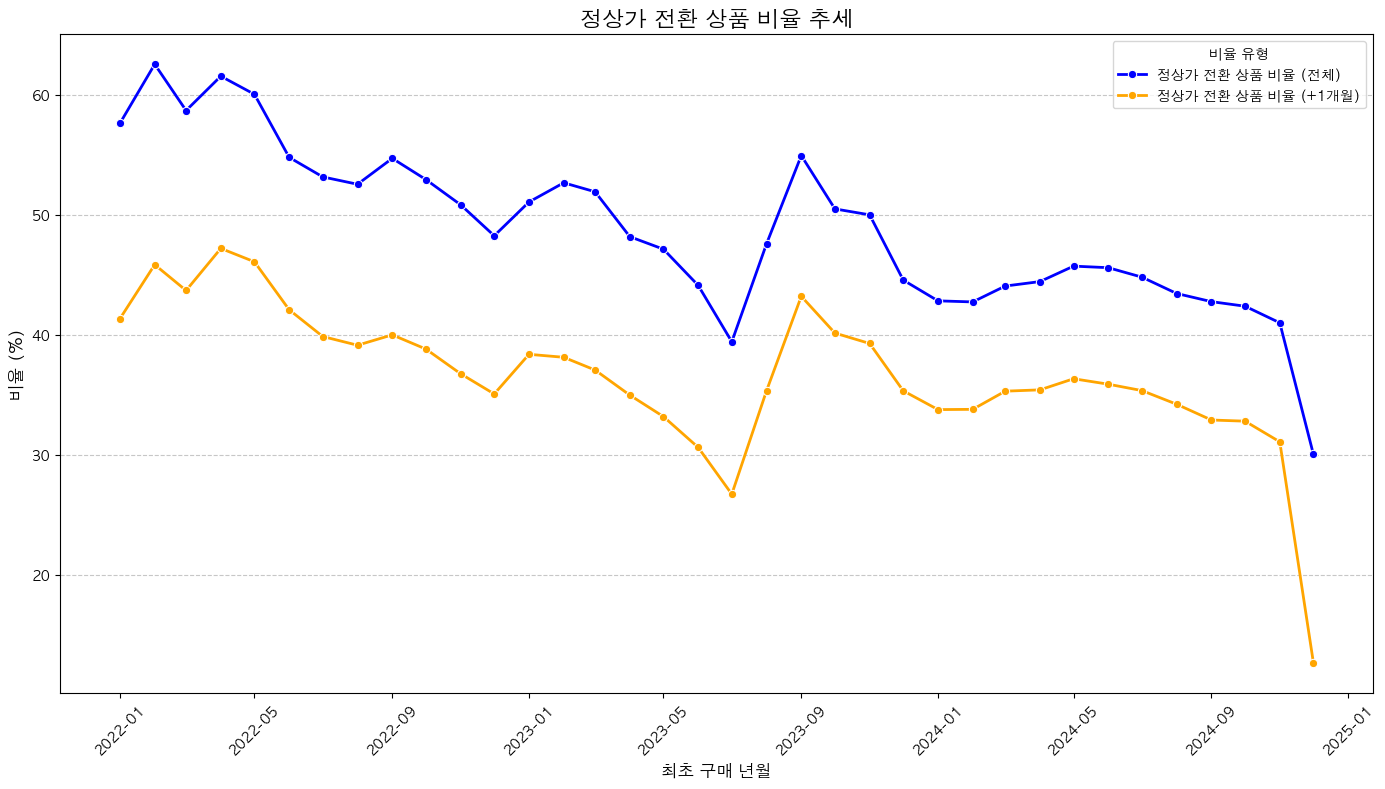

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 준비
# fst_dt를 날짜 형식으로 변환
normal_price_prod_2_df["fst_dt"] = pd.to_datetime(normal_price_prod_2_df["fst_dt"])

# 2. Line Plot 그리기
plt.figure(figsize=(14, 8))

# normal_term_prod_ratio 라인
sns.lineplot(
    data=normal_price_prod_2_df,
    x="fst_dt",
    y="normal_term_prod_ratio",
    label="정상가 전환 상품 비율 (전체)",
    color="blue",
    marker="o",
    linewidth=2
)

# normal_term_1m_prod_ratio 라인
sns.lineplot(
    data=normal_price_prod_2_df,
    x="fst_dt",
    y="normal_term_1m_prod_ratio",
    label="정상가 전환 상품 비율 (+1개월)",
    color="orange",
    marker="o",
    linewidth=2
)

# 3. 그래프 설정
plt.title("정상가 전환 상품 비율 추세", fontsize=16)
plt.xlabel("최초 구매 년월", fontsize=12)
plt.ylabel("비율 (%)", fontsize=12)
plt.xticks(rotation=45)  # X축 레이블 회전
plt.legend(title="비율 유형", loc="upper right")  # 범례 설정
plt.grid(axis="y", linestyle="--", alpha=0.7)  # Y축 격자 추가
plt.tight_layout()
plt.show()

In [ ]:
## 연령대,성별(po_ps_members_tb_ro 사용)에 따른 정상가 전환 상품 비율 
normal_price_prod_query_3 = '''
WITH term_data as(
        SELECT
            DATE_FORMAT(FST_DT, '%Y-%m') AS FST_DT
          , FIRST_BUY_NO
          , PROMO_DC_GRP
          , DT
          , AGE
          , GENDER
          , MEMBER_KEY
          , BUY_NO
          , normal_price_yn 
          , IF(NEW_TERM = LAG(NEW_TERM) OVER (PARTITION BY FST_DT, FIRST_BUY_NO, MEMBER_KEY ORDER BY DT), NEW_TERM+1, NEW_TERM) AS TERM
        FROM (
            SELECT 
                FST_DT
              , FIRST_BUY_NO
              , PROMO_DC_GRP
              , MEMBER_KEY
              , AGE
              , GENDER
              , DT
              , BUY_NO
              , normal_price_yn
              , CASE
                    WHEN (BF_TERM + 1) = TERM THEN TERM
                    WHEN (BF_TERM + 1) <> TERM AND (MONTH(BF_DT) = MONTH(DT)) THEN (TERM + 1)
                    ELSE TERM
                END AS NEW_TERM
            FROM (
                SELECT
                    FST_DT
                  , FIRST_BUY_NO
                  , PROMO_DC_GRP
                  , MEMBER_KEY
                  , AGE
                  , GENDER
                  , DT
                  , BUY_NO
                  , normal_price_yn
                  , TERM
                  , COALESCE(LAG(DT)     OVER (PARTITION BY FST_DT, FIRST_BUY_NO, MEMBER_KEY ORDER BY DT), FST_DT) AS BF_DT
                  , COALESCE(LAG(BUY_NO) OVER (PARTITION BY FST_DT, FIRST_BUY_NO, MEMBER_KEY ORDER BY DT), FIRST_BUY_NO) AS BF_BUY_NO
                  , COALESCE(LAG(TERM)   OVER (PARTITION BY FST_DT, FIRST_BUY_NO, MEMBER_KEY ORDER BY DT), 0) AS BF_TERM
                FROM (
                    SELECT F1.DT AS FST_DT
                         , F1.FIRST_BUY_NO
                         , F1.PROMO_DC_GRP
                         , F1.MEMBER_KEY
                         , CASE
                            WHEN AGE_ENT_PRT_CD IN (1,2) THEN '10대이하'
                            WHEN AGE_ENT_PRT_CD IN (3,4) THEN '20대'
                            WHEN AGE_ENT_PRT_CD IN (5,6) THEN '30대'
                            WHEN AGE_ENT_PRT_CD IN (7,8) THEN '40대'
                            WHEN AGE_ENT_PRT_CD IN (9,10) THEN '50대'
                            WHEN AGE_ENT_PRT_CD = 11 THEN '60대이상'
                            ELSE '정보없음'
                           END AS AGE
                         , CASE
                            WHEN MEMBER_GNDR = '1' THEN '남성'
                            WHEN MEMBER_GNDR = '2' THEN '여성'
                            ELSE '정보없음'
                           END AS GENDER
                         , F2.BUY_NO
                         , F2.normal_price_yn
                         , F2.DT
                         , DATE_DIFF('MONTH', F1.DT, F2.DT) AS TERM
                    FROM (
                        SELECT T1.DT
                             , T1.FIRST_BUY_NO
                             , T1.BUY_NO
                             , T1.USER_MKEY AS MEMBER_KEY
                             , T5.PROMO_DC_GRP
                             , T3.PROMO_GRP_CD
                             , T6.PROMO_GRP_NM
                             , T1.LOG_DATE
                        FROM HADOOP_KENT.MELON_MA_STAT_PRODUCTION.F_PROD_USER_FXMT_DT T1
                        JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROD T2  ON (T1.PROD_ID = T2.PROD_ID)
                        JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROMO T3 ON (T1.PROMO_ID = T3.PROMO_ID)
                        JOIN HADOOP_KENT.MELON_ODS_COMMERCE_PRODUCTION.CPT_PROD_TB_RO T4 ON (T1.PROD_ID = T4.PROD_ID)
                        JOIN(
                            SELECT PROMO_DC_GRP_CD
                                 , PROMO_DC_GRP_NM
                                 , CASE
                                    WHEN PROMO_DC_GRP_CD IN (2,3,4) THEN '1개월 0원 + 장기할인'
                                    WHEN PROMO_DC_GRP_CD IN (5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,83,86,87,88,91,93,94,98,109) THEN '1개월 100원 + 할인'
                                    WHEN PROMO_DC_GRP_CD IN (95,101,102) THEN '1개월 할인'
                                    WHEN PROMO_DC_GRP_CD IN (28,29,30,31,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51) THEN '2개월 할인'
                                    WHEN PROMO_DC_GRP_CD IN (33,103) THEN '2개월 100원 + 할인'
                                    WHEN PROMO_DC_GRP_CD IN (54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,70,71,72,73,74,75,76,77,78,81,82,84,85,89,90,92,96,97,99,100,104,110,107,108) THEN '장기할인(3개월이상)'
                                    ELSE PROMO_DC_GRP_NM
                                   END AS PROMO_DC_GRP
                            FROM HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROMO_DC_GRP
                        ) T5 ON T3.PROMO_DC_GRP_CD = T5.PROMO_DC_GRP_CD
                        left join hadoop_kent.melon_ma_stat_production.d_promo_grp t6 on t3.promo_grp_cd = t6.promo_grp_cd
                        WHERE T1.LOG_DATE BETWEEN '20230101' AND '20241231'
                          AND DATE_FORMAT(T1.DT, '%Y%m%d') BETWEEN '20230101' AND '20241231'
                          AND PF_YN = 1
                          AND T2.PROD_ATTR_CD NOT IN (10040, 10050)
                          AND T1.PROD_JOIN_PRT_CD = 1100 --IN (1100, 1200, 1201, 1205, 1203,1206,1207) /*신규 로직에서 1206 제외*/ 
                          AND T2.PROD_SELL_PRT_CD IN (60000) /*B2C*/
                          AND PROD_PRT_CD = 20000  /*클럽 상품*/
                          AND T3.PROMO_GRP_CD NOT IN (49,9999,41,68)
                          AND T5.PROMO_DC_GRP IN ('2개월 100원')
                        GROUP BY 1, 2, 3, 4,5, 6, 7, 8

                    ) F1
                    LEFT OUTER JOIN (
                        SELECT DT
                             , FIRST_BUY_NO
                             , BUY_NO
                             , USER_MKEY AS MEMBER_KEY
                             , t2.sale_amt
                             , t1.prim_bill_mthd_bill_amt
                             , if(t1.prim_bill_mthd_bill_amt = t2.sale_amt,'Y','N') as normal_price_yn
                        FROM HADOOP_KENT.MELON_MA_STAT_PRODUCTION.F_PROD_USER_FXMT_DT  T1
                        JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROD               T2 ON (T1.PROD_ID = T2.PROD_ID)
                        JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROMO              T3 ON (T1.PROMO_ID = T3.PROMO_ID)
                        JOIN HADOOP_KENT.MELON_ODS_COMMERCE_PRODUCTION.CPT_PROD_TB_RO     T4 ON (T1.PROD_ID = T4.PROD_ID)
                        WHERE T1.LOG_DATE >= '20230101'
                          AND DATE_FORMAT(T1.DT, '%Y%m%d') >= '20230101'
                          AND PF_YN = 1
                          AND T2.PROD_ATTR_CD NOT IN (10040, 10050)
                          AND T1.PROD_JOIN_PRT_CD IN (1202) /*자결*/
                          AND T2.PROD_SELL_PRT_CD IN (60000) /*B2C*/
                          AND SELL_TYPE_CODE = 'ON1300'
                        GROUP BY 1, 2, 3, 4, 5, 6
                    ) F2 ON (F1.FIRST_BUY_NO = F2.FIRST_BUY_NO AND F1.MEMBER_KEY = F2.MEMBER_KEY AND F2.BUY_NO > F1.BUY_NO)
                    LEFT OUTER JOIN(                        
                        SELECT MEMBER_KEY
                             , ipin_gender as MEMBER_GNDR
                             , AGE_ENT_PRT_CD
                        from HADOOP_KENT.melon_ods_poc_production.po_ps_members_tb_ro
                        group by 1,2,3
                    ) F3 ON F1.MEMBER_KEY = F3.MEMBER_KEY
                ) F3
                WHERE AGE <> '정보없음'
                AND GENDER <> '정보없음'
            ) DF1
        ) DF2
)

SELECT F1.PROMO_DC_GRP 
     , F1.AGE
     , F1.GENDER
     , F1.FST_DT
     , F1.FST_PROD_CNT
     , F1.fst_normal_price_term
     , F2.prod_cnt as normal_termm_prod_cnt
     , F3.prod_cnt as normal_term_1m_prod_cnt
     , cast(F2.prod_cnt as double)/cast(f1.fst_prod_cnt as double)*100 as normal_term_prod_ratio
     , cast(F3.prod_cnt as double)/cast(f1.fst_prod_cnt as double)*100 as normal_term_1m_prod_ratio
FROM(
    SELECT
        PROMO_DC_GRP
      , FST_DT
      , AGE
      , GENDER
      , COUNT(DISTINCT FIRST_BUY_NO) AS FST_PROD_CNT
      , min(if(normal_price_yn = 'Y',term)) as fst_normal_price_term
    FROM term_data
    GROUP BY 1,2,3,4
    HAVING(COUNT(DISTINCT FIRST_BUY_NO) > 1000)
) F1
LEFT JOIN(
    SELECT 
        PROMO_DC_GRP
      , FST_DT
      , AGE
      , GENDER
      , term
      , count(distinct buy_no) as prod_cnt
    FROM term_data
    GROUP BY 1,2,3,4,5
) F2 ON F1.PROMO_DC_GRP = F2.PROMO_DC_GRP AND F1.FST_DT = F2.FST_DT AND F2.TERM = F1.fst_normal_price_term AND F1.AGE = F2.AGE AND F1.GENDER = F2.GENDER
LEFT JOIN(
    SELECT 
        PROMO_DC_GRP
      , FST_DT
      , AGE
      , GENDER
      , term
      , count(distinct buy_no) as prod_cnt
    FROM term_data
    GROUP BY 1,2,3,4,5
) F3 ON F1.PROMO_DC_GRP = F3.PROMO_DC_GRP AND F1.FST_DT = F3.FST_DT AND F3.TERM = F1.fst_normal_price_term + 1 AND F1.AGE = F3.AGE AND F1.GENDER = F3.GENDER
order by 2,1,3
'''

cur.execute(normal_price_prod_query_3)

results = cur.fetchall()
colnames = [part[0] for part in cur.description]

normal_price_prod_3_df = pd.DataFrame(results, columns=colnames)

cur.cancel()
conn.close()
normal_price_prod_3_df.head()

,promo_dc_grp,age,gender,fst_dt,fst_prod_cnt,fst_normal_price_term,normal_termm_prod_cnt,normal_term_1m_prod_cnt,normal_term_prod_ratio,normal_term_1m_prod_ratio
0,2개월 100원,10대이하,남성,2023-11,1501,2,336,191,22.385077,12.724850
1,2개월 100원,10대이하,남성,2023-10,2261,2,482,252,21.318001,11.145511
2,2개월 100원,10대이하,남성,2024-11,1642,2,413,224,25.152253,13.641900
3,2개월 100원,10대이하,남성,2024-05,1758,2,448,261,25.483504,14.846416
4,2개월 100원,10대이하,남성,2024-09,1615,2,451,241,27.925697,14.922601


In [102]:
## 프로모션 그룹 및 할인율 그룹에 따른 정상가 전환 상품 비율 + 연령대,성별(po_ps_members_tb_ro 사용)
normal_price_prod_query_3 = '''
WITH term_data as(
        SELECT
            DATE_FORMAT(FST_DT, '%Y-%m') AS FST_DT
          , FIRST_BUY_NO
          , PROMO_DC_GRP
          , DT
          , AGE
          , GENDER
          , MEMBER_KEY
          , BUY_NO
          , normal_price_yn 
          , IF(NEW_TERM = LAG(NEW_TERM) OVER (PARTITION BY FST_DT, FIRST_BUY_NO, MEMBER_KEY ORDER BY DT), NEW_TERM+1, NEW_TERM) AS TERM
        FROM (
            SELECT 
                FST_DT
              , FIRST_BUY_NO
              , PROMO_DC_GRP
              , MEMBER_KEY
              , AGE
              , GENDER
              , DT
              , BUY_NO
              , normal_price_yn
              , CASE
                    WHEN (BF_TERM + 1) = TERM THEN TERM
                    WHEN (BF_TERM + 1) <> TERM AND (MONTH(BF_DT) = MONTH(DT)) THEN (TERM + 1)
                    ELSE TERM
                END AS NEW_TERM
            FROM (
                SELECT
                    FST_DT
                  , FIRST_BUY_NO
                  , PROMO_DC_GRP
                  , MEMBER_KEY
                  , AGE
                  , GENDER
                  , DT
                  , BUY_NO
                  , normal_price_yn
                  , TERM
                  , COALESCE(LAG(DT)     OVER (PARTITION BY FST_DT, FIRST_BUY_NO, MEMBER_KEY ORDER BY DT), FST_DT) AS BF_DT
                  , COALESCE(LAG(BUY_NO) OVER (PARTITION BY FST_DT, FIRST_BUY_NO, MEMBER_KEY ORDER BY DT), FIRST_BUY_NO) AS BF_BUY_NO
                  , COALESCE(LAG(TERM)   OVER (PARTITION BY FST_DT, FIRST_BUY_NO, MEMBER_KEY ORDER BY DT), 0) AS BF_TERM
                FROM (
                    SELECT F1.DT AS FST_DT
                         , F1.FIRST_BUY_NO
                         , F1.PROMO_DC_GRP
                         , F1.MEMBER_KEY
                         , CASE
                            WHEN AGE_ENT_PRT_CD IN (1,2) THEN '10대이하'
                            WHEN AGE_ENT_PRT_CD IN (3,4) THEN '20대'
                            WHEN AGE_ENT_PRT_CD IN (5,6) THEN '30대'
                            WHEN AGE_ENT_PRT_CD IN (7,8) THEN '40대'
                            WHEN AGE_ENT_PRT_CD IN (9,10) THEN '50대'
                            WHEN AGE_ENT_PRT_CD = 11 THEN '60대이상'
                            ELSE '정보없음'
                           END AS AGE
                         , CASE
                            WHEN MEMBER_GNDR = '1' THEN '남성'
                            WHEN MEMBER_GNDR = '2' THEN '여성'
                            ELSE '정보없음'
                           END AS GENDER
                         , F2.BUY_NO
                         , F2.normal_price_yn
                         , F2.DT
                         , DATE_DIFF('MONTH', F1.DT, F2.DT) AS TERM
                    FROM (
                        SELECT T1.DT
                             , T1.FIRST_BUY_NO
                             , T1.BUY_NO
                             , T1.USER_MKEY AS MEMBER_KEY
                             , T5.PROMO_DC_GRP
                             , T3.PROMO_GRP_CD
                             , T6.PROMO_GRP_NM
                             , T1.LOG_DATE
                        FROM HADOOP_KENT.MELON_MA_STAT_PRODUCTION.F_PROD_USER_FXMT_DT T1
                        JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROD T2  ON (T1.PROD_ID = T2.PROD_ID)
                        JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROMO T3 ON (T1.PROMO_ID = T3.PROMO_ID)
                        JOIN HADOOP_KENT.MELON_ODS_COMMERCE_PRODUCTION.CPT_PROD_TB_RO T4 ON (T1.PROD_ID = T4.PROD_ID)
                        JOIN(
                            SELECT PROMO_DC_GRP_CD
                                 , PROMO_DC_GRP_NM
                                 , CASE
                                    WHEN PROMO_DC_GRP_CD IN (2,3,4) THEN '1개월 0원 + 장기할인'
                                    WHEN PROMO_DC_GRP_CD IN (5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,83,86,87,88,91,93,94,98,109) THEN '1개월 100원 + 할인'
                                    WHEN PROMO_DC_GRP_CD IN (95,101,102) THEN '1개월 할인'
                                    WHEN PROMO_DC_GRP_CD IN (28,29,30,31,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51) THEN '2개월 할인'
                                    WHEN PROMO_DC_GRP_CD IN (33,103) THEN '2개월 100원 + 할인'
                                    WHEN PROMO_DC_GRP_CD IN (54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,70,71,72,73,74,75,76,77,78,81,82,84,85,89,90,92,96,97,99,100,104,110,107,108) THEN '장기할인(3개월이상)'
                                    ELSE PROMO_DC_GRP_NM
                                   END AS PROMO_DC_GRP
                            FROM HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROMO_DC_GRP
                        ) T5 ON T3.PROMO_DC_GRP_CD = T5.PROMO_DC_GRP_CD
                        left join hadoop_kent.melon_ma_stat_production.d_promo_grp t6 on t3.promo_grp_cd = t6.promo_grp_cd
                        WHERE T1.LOG_DATE BETWEEN '20220101' AND '20241231'
                          AND DATE_FORMAT(T1.DT, '%Y%m%d') BETWEEN '20220101' AND '20241231'
                          AND PF_YN = 1
                          AND T2.PROD_ATTR_CD NOT IN (10040, 10050)
                          AND T1.PROD_JOIN_PRT_CD = 1100 --IN (1100, 1200, 1201, 1205, 1203,1206,1207) /*신규 로직에서 1206 제외*/ 
                          AND T2.PROD_SELL_PRT_CD IN (60000) /*B2C*/
                          AND PROD_PRT_CD = 20000  /*클럽 상품*/
                          AND T3.PROMO_GRP_CD NOT IN (49,9999,41,68)
                          --AND T5.PROMO_DC_GRP IN ('2개월 100원')
                        GROUP BY 1, 2, 3, 4,5, 6, 7, 8

                    ) F1
                    LEFT OUTER JOIN (
                        SELECT DT
                             , FIRST_BUY_NO
                             , BUY_NO
                             , USER_MKEY AS MEMBER_KEY
                             , t2.sale_amt
                             , t1.prim_bill_mthd_bill_amt
                             , if(t1.prim_bill_mthd_bill_amt = t2.sale_amt,'Y','N') as normal_price_yn
                        FROM HADOOP_KENT.MELON_MA_STAT_PRODUCTION.F_PROD_USER_FXMT_DT  T1
                        JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROD               T2 ON (T1.PROD_ID = T2.PROD_ID)
                        JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROMO              T3 ON (T1.PROMO_ID = T3.PROMO_ID)
                        JOIN HADOOP_KENT.MELON_ODS_COMMERCE_PRODUCTION.CPT_PROD_TB_RO     T4 ON (T1.PROD_ID = T4.PROD_ID)
                        WHERE T1.LOG_DATE >= '20220101'
                          AND DATE_FORMAT(T1.DT, '%Y%m%d') >= '20220101'
                          AND PF_YN = 1
                          AND T2.PROD_ATTR_CD NOT IN (10040, 10050)
                          AND T1.PROD_JOIN_PRT_CD IN (1202) /*자결*/
                          AND T2.PROD_SELL_PRT_CD IN (60000) /*B2C*/
                          AND SELL_TYPE_CODE = 'ON1300'
                        GROUP BY 1, 2, 3, 4, 5, 6
                    ) F2 ON (F1.FIRST_BUY_NO = F2.FIRST_BUY_NO AND F1.MEMBER_KEY = F2.MEMBER_KEY AND F2.BUY_NO > F1.BUY_NO)
                    LEFT OUTER JOIN(                        
                        SELECT MEMBER_KEY
                             , ipin_gender as MEMBER_GNDR
                             , AGE_ENT_PRT_CD
                        from HADOOP_KENT.melon_ods_poc_production.po_ps_members_tb_ro
                        group by 1,2,3
                    ) F3 ON F1.MEMBER_KEY = F3.MEMBER_KEY
                ) F3
                WHERE AGE <> '정보없음'
                AND GENDER <> '정보없음'
            ) DF1
        ) DF2
)

SELECT F1.FST_DT
     , F1.GENDER
     , F1.AGE
     , sum(F1.FST_PROD_CNT) as fst_prod_cnt
     , sum(F2.prod_cnt) as normal_termm_prod_cnt
     , sum(F3.prod_cnt) as normal_term_1m_prod_cnt
     , cast(sum(F2.prod_cnt) as double)/cast(sum(F1.FST_PROD_CNT) as double)*100 as normal_term_prod_ratio
     , cast(sum(F3.prod_cnt) as double)/cast(sum(F1.FST_PROD_CNT) as double)*100 as normal_term_1m_prod_ratio
FROM(
    SELECT
        PROMO_DC_GRP
      , FST_DT
      , AGE
      , GENDER
      , COUNT(DISTINCT FIRST_BUY_NO) AS FST_PROD_CNT
      , min(if(normal_price_yn = 'Y',term)) as fst_normal_price_term
    FROM term_data
    GROUP BY 1,2,3,4
    HAVING(COUNT(DISTINCT FIRST_BUY_NO) > 1000)
) F1
LEFT JOIN(
    SELECT 
        PROMO_DC_GRP
      , FST_DT
      , AGE
      , GENDER
      , term
      , count(distinct buy_no) as prod_cnt
    FROM term_data
    GROUP BY 1,2,3,4,5
) F2 ON F1.PROMO_DC_GRP = F2.PROMO_DC_GRP AND F1.FST_DT = F2.FST_DT AND F2.TERM = F1.fst_normal_price_term AND F1.AGE = F2.AGE AND F1.GENDER = F2.GENDER
LEFT JOIN(
    SELECT 
        PROMO_DC_GRP
      , FST_DT
      , AGE
      , GENDER
      , term
      , count(distinct buy_no) as prod_cnt
    FROM term_data
    GROUP BY 1,2,3,4,5
) F3 ON F1.PROMO_DC_GRP = F3.PROMO_DC_GRP AND F1.FST_DT = F3.FST_DT AND F3.TERM = F1.fst_normal_price_term + 1 AND F1.AGE = F3.AGE AND F1.GENDER = F3.GENDER
group by 1,2,3
order by 1,2,3
'''

cur.execute(normal_price_prod_query_3)

results = cur.fetchall()
colnames = [part[0] for part in cur.description]

normal_price_prod_3_df = pd.DataFrame(results, columns=colnames)

cur.cancel()
conn.close()
normal_price_prod_3_df.head()

,fst_dt,gender,age,fst_prod_cnt,normal_termm_prod_cnt,normal_term_1m_prod_cnt,normal_term_prod_ratio,normal_term_1m_prod_ratio
0,2022-01,남성,10대이하,5526,2661,1880,48.154180,34.020992
1,2022-01,남성,20대,41414,23183,17213,55.978655,41.563239
2,2022-01,남성,30대,26582,16837,12428,63.339854,46.753442
3,2022-01,남성,40대,19123,12147,8695,63.520368,45.468807
4,2022-01,남성,50대,8145,5655,4359,69.429098,53.517495


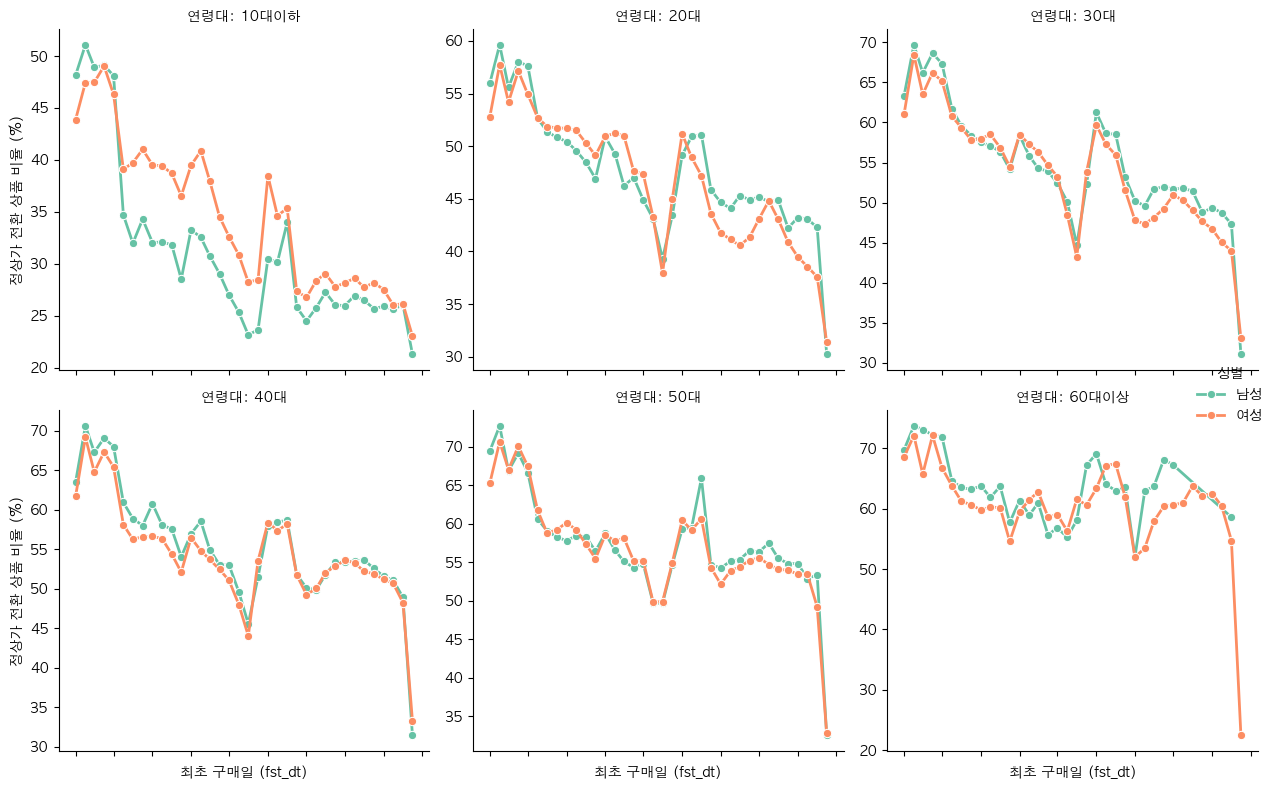

In [125]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 데이터 준비
# fst_dt가 없는 경우 제외
filtered_data = normal_price_prod_3_df.dropna(subset=["fst_dt"])
filtered_data["fst_dt"] = pd.to_datetime(filtered_data["fst_dt"])  # fst_dt를 날짜 형식으로 변환

# 2. FacetGrid를 사용한 연령대별 성별 추세
g = sns.FacetGrid(
    data=filtered_data, 
    col="age",  # 연령대별로 나눔
    hue="gender",  # 성별 구분
    col_wrap=3,  # 한 줄에 3개의 플롯
    height=4,  # 각 플롯의 높이
    palette="Set2",
    sharey=False,  # Y축 공유 여부
)
g.map(sns.lineplot, "fst_dt", "normal_term_prod_ratio", marker="o", linewidth=2)

# 3. 그래프 설정
g.set_titles(col_template="연령대: {col_name}")
g.set_axis_labels("최초 구매일 (fst_dt)", "정상가 전환 상품 비율 (%)")
g.add_legend(title="성별")
g.set_xticklabels(rotation=45)  # X축 레이블 회전
plt.tight_layout()
plt.show()

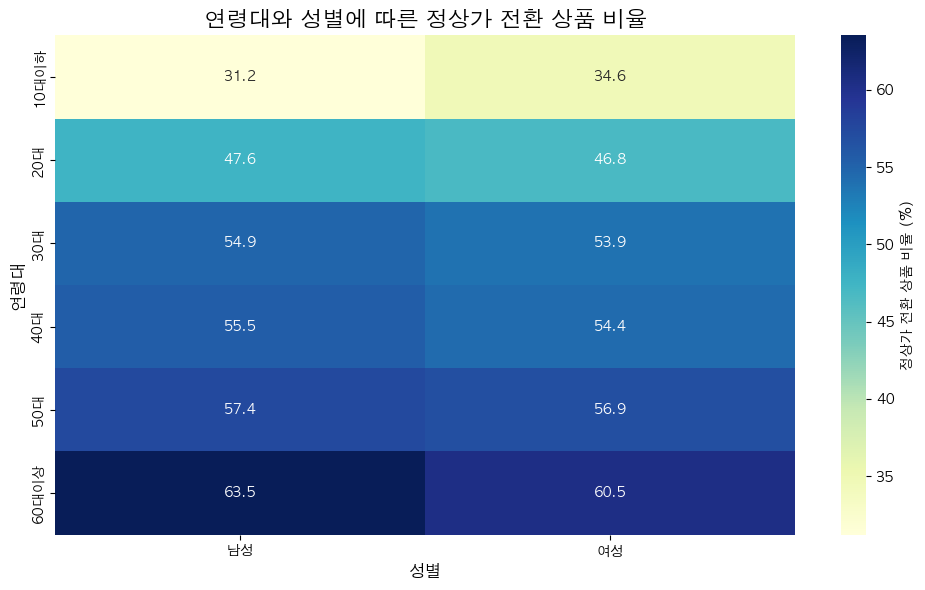

In [105]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 데이터 준비
# fst_dt가 없는 경우 제외
filtered_data = normal_price_prod_3_df.dropna(subset=["fst_dt"])

# 연령대와 성별별 평균 정상가 전환율 계산
heatmap_data = filtered_data.groupby(["age", "gender"])["normal_term_prod_ratio"].mean().unstack()

# 2. Heatmap 그리기
plt.figure(figsize=(10, 6))
sns.heatmap(
    data=heatmap_data, 
    annot=True,  # 셀에 값 표시
    fmt=".1f",  # 소수점 한 자리까지 표시
    cmap="YlGnBu",  # 색상 팔레트
    cbar_kws={"label": "정상가 전환 상품 비율 (%)"}
)

# 3. 그래프 설정
plt.title("연령대와 성별에 따른 정상가 전환 상품 비율", fontsize=16)
plt.xlabel("성별", fontsize=12)
plt.ylabel("연령대", fontsize=12)
plt.tight_layout()
plt.show()

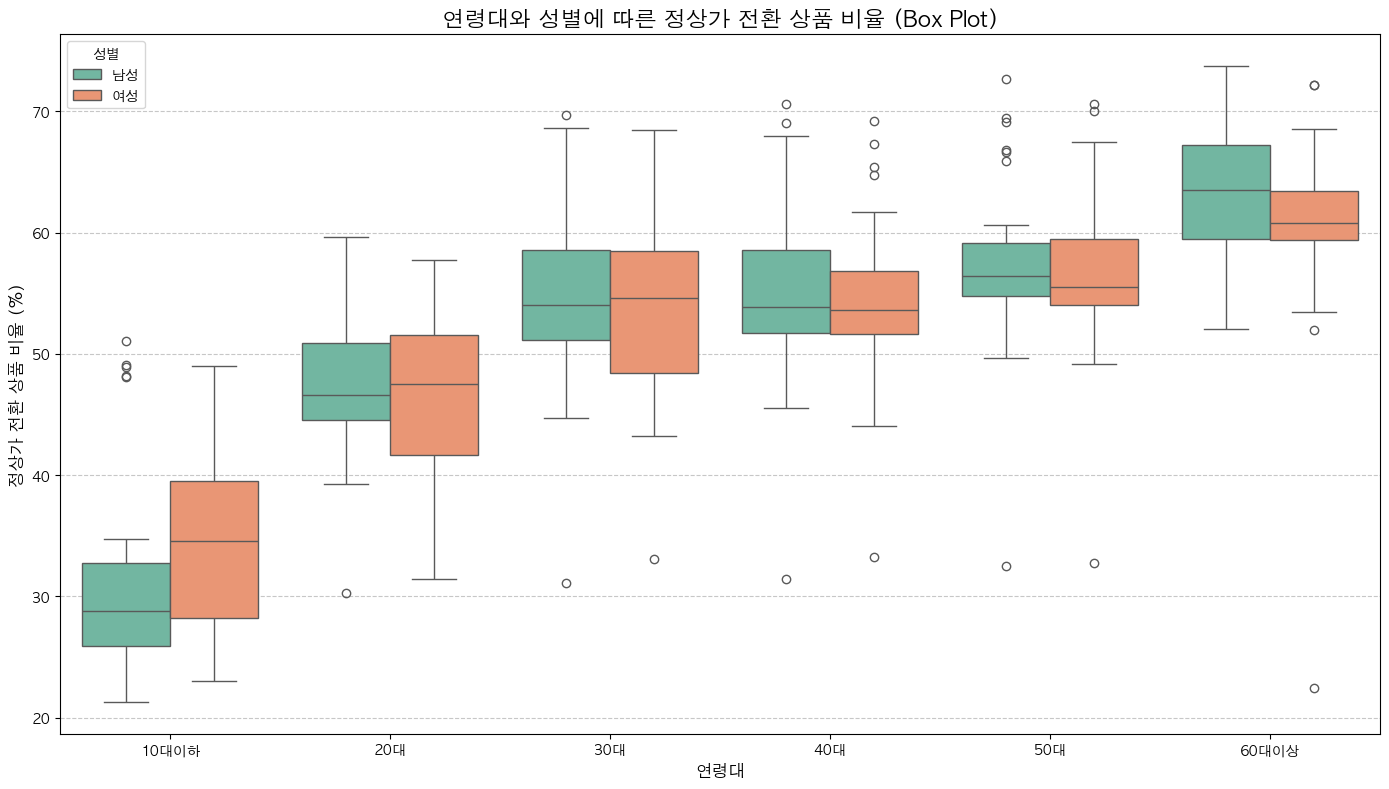

In [124]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 데이터 준비
# fst_dt가 없는 경우 제외
filtered_data = normal_price_prod_3_df.dropna(subset=["fst_dt"])

# 2. Box Plot 그리기
plt.figure(figsize=(14, 8))
sns.boxplot(
    data=filtered_data,
    x="age",  # X축: 연령대
    y="normal_term_prod_ratio",  # Y축: 정상가 전환 상품 비율
    hue="gender",  # 성별 구분
    palette="Set2"
)

# 3. 그래프 설정
plt.title("연령대와 성별에 따른 정상가 전환 상품 비율 (Box Plot)", fontsize=16)
plt.xlabel("연령대", fontsize=12)
plt.ylabel("정상가 전환 상품 비율 (%)", fontsize=12)
plt.legend(title="성별", loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)  # Y축 격자 추가
plt.tight_layout()
plt.show()

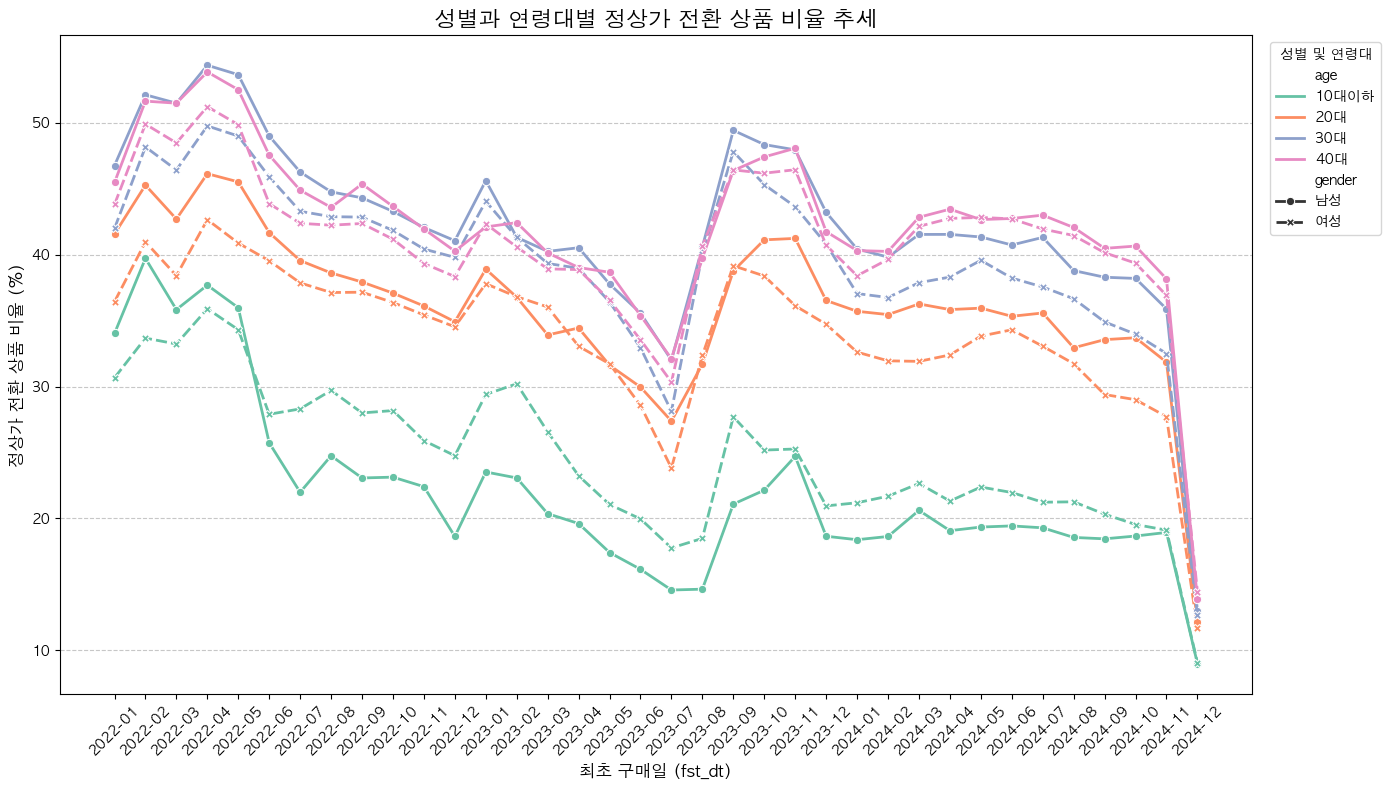

In [107]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 데이터 준비
# fst_dt가 없는 경우 제외
filtered_data = normal_price_prod_3_df.dropna(subset=["fst_dt"])

# 60대 이상 제외
filtered_data = filtered_data[filtered_data["age"] != "60대이상"]
filtered_data = filtered_data[filtered_data["age"] != "50대"]

# 연령대와 성별별 평균 정상가 전환율 계산
lineplot_data = filtered_data.groupby(["fst_dt", "age", "gender"])["normal_term_1m_prod_ratio"].mean().reset_index()

# 2. Line Plot 그리기
plt.figure(figsize=(14, 8))
sns.lineplot(
    data=lineplot_data,
    x="fst_dt",  # X축: 최초 구매일
    y="normal_term_1m_prod_ratio",  # Y축: 정상가 전환 상품 비율
    hue="age",  # 연령대 구분
    style="gender",  # 성별 구분
    markers=True,
    palette="Set2",
    linewidth=2
)

# 3. 그래프 설정
plt.title("성별과 연령대별 정상가 전환 상품 비율 추세", fontsize=16)
plt.xlabel("최초 구매일 (fst_dt)", fontsize=12)
plt.ylabel("정상가 전환 상품 비율 (%)", fontsize=12)
plt.xticks(rotation=45)  # X축 레이블 회전
plt.legend(title="성별 및 연령대", bbox_to_anchor=(1.01, 1), loc="upper left")  # 범례를 그래프 바깥으로 이동
plt.grid(axis="y", linestyle="--", alpha=0.7)  # Y축 격자 추가
plt.tight_layout()
plt.show()

전년 동월 대비 감소폭 (Pivot Table):
gender         남성         여성
age                         
10대이하   -7.934405  -9.184383
20대     -8.827558  -9.626625
30대    -11.207724 -11.961436
40대     -9.750462  -9.929386
50대    -12.521257 -11.456972
60대이상   -4.369300 -12.717130


/var/folders/qw/6lks7c5d14scf7qtctm8m6jh0000gn/T/ipykernel_80999/1400651739.py:47: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


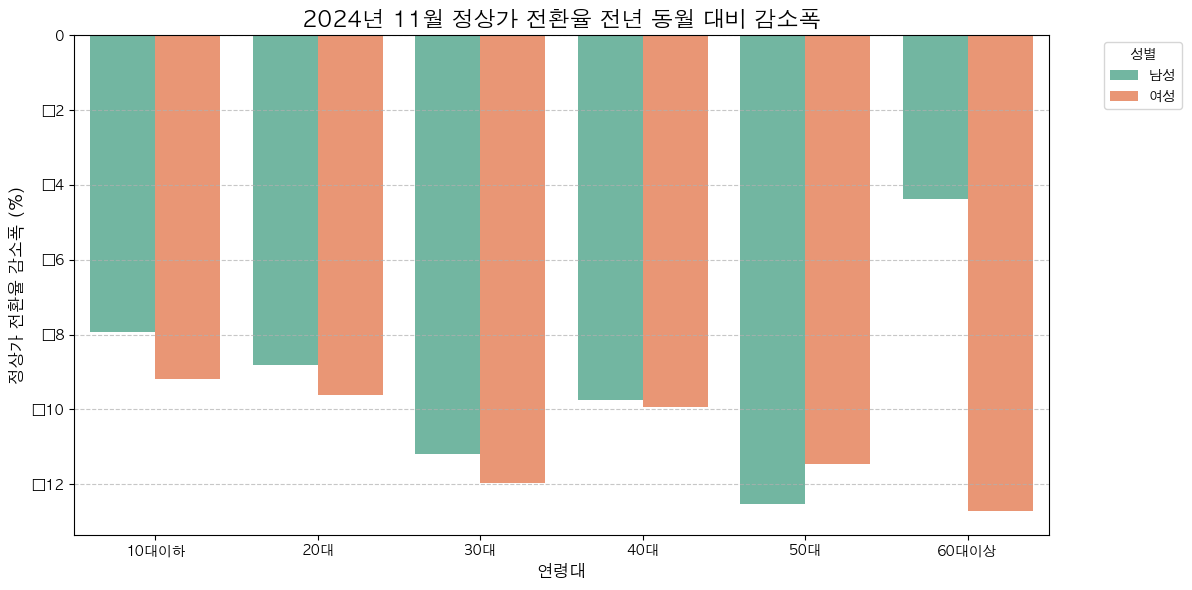

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 준비
# fst_dt가 없는 경우 제외
filtered_data = normal_price_prod_3_df.dropna(subset=["fst_dt"])

# fst_dt를 날짜 형식으로 변환
filtered_data["fst_dt"] = pd.to_datetime(filtered_data["fst_dt"])

# 2023년 11월과 2024년 11월 데이터 필터링
data_2023_11 = filtered_data[filtered_data["fst_dt"] == "2023-11"]
data_2024_11 = filtered_data[filtered_data["fst_dt"] == "2024-11"]

# 2. 연령대 및 성별 기준으로 평균 정상가 전환율 계산
avg_2023_11 = data_2023_11.groupby(["age", "gender"])["normal_term_prod_ratio"].mean().reset_index()
avg_2024_11 = data_2024_11.groupby(["age", "gender"])["normal_term_prod_ratio"].mean().reset_index()

# 3. 전년 동월 대비 감소폭 계산
comparison = pd.merge(
    avg_2024_11, avg_2023_11, on=["age", "gender"], suffixes=("_2024", "_2023")
)
comparison["decrease"] = comparison["normal_term_prod_ratio_2024"] - comparison["normal_term_prod_ratio_2023"]

# Pivot Table 생성
pivot_table = comparison.pivot(index="age", columns="gender", values="decrease")
print("전년 동월 대비 감소폭 (Pivot Table):")
print(pivot_table)

# 4. Bar Plot 그리기
plt.figure(figsize=(12, 6))
sns.barplot(
    data=comparison,
    x="age",
    y="decrease",
    hue="gender",
    palette="Set2"
)

# 그래프 설정
plt.title("2024년 11월 정상가 전환율 전년 동월 대비 감소폭", fontsize=16)
plt.xlabel("연령대", fontsize=12)
plt.ylabel("정상가 전환율 감소폭 (%)", fontsize=12)
plt.legend(title="성별", bbox_to_anchor=(1.05, 1), loc="upper left")  # 범례를 그래프 밖으로 배치
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


## 사용자 타겟(일반,체리피커,비리스트)에 따른 정상가 전환율

In [141]:
## 연령대,성별(po_ps_members_tb_ro 사용)에 따른 정상가 전환 상품 비율 
normal_price_prod_query_4 = '''
WITH term_data as(
        SELECT
            DATE_FORMAT(FST_DT, '%Y-%m') AS FST_DT
          , FIRST_BUY_NO
          , PROMO_DC_GRP
          , DT
          , MEMBER_KEY
          , USER_TRGT_NM
          , BUY_NO
          , normal_price_yn 
          , IF(NEW_TERM = LAG(NEW_TERM) OVER (PARTITION BY FST_DT, FIRST_BUY_NO, MEMBER_KEY ORDER BY DT), NEW_TERM+1, NEW_TERM) AS TERM
        FROM (
            SELECT 
                FST_DT
              , FIRST_BUY_NO
              , PROMO_DC_GRP
              , MEMBER_KEY
              , USER_TRGT_NM
              , DT
              , BUY_NO
              , normal_price_yn
              , CASE
                    WHEN (BF_TERM + 1) = TERM THEN TERM
                    WHEN (BF_TERM + 1) <> TERM AND (MONTH(BF_DT) = MONTH(DT)) THEN (TERM + 1)
                    ELSE TERM
                END AS NEW_TERM
            FROM (
                SELECT
                    FST_DT
                  , FIRST_BUY_NO
                  , PROMO_DC_GRP
                  , MEMBER_KEY
                  , DT
                  , BUY_NO
                  , normal_price_yn
                  , USER_TRGT_NM
                  , TERM
                  , COALESCE(LAG(DT)     OVER (PARTITION BY FST_DT, FIRST_BUY_NO, MEMBER_KEY ORDER BY DT), FST_DT) AS BF_DT
                  , COALESCE(LAG(BUY_NO) OVER (PARTITION BY FST_DT, FIRST_BUY_NO, MEMBER_KEY ORDER BY DT), FIRST_BUY_NO) AS BF_BUY_NO
                  , COALESCE(LAG(TERM)   OVER (PARTITION BY FST_DT, FIRST_BUY_NO, MEMBER_KEY ORDER BY DT), 0) AS BF_TERM
                FROM (
                    SELECT F1.DT AS FST_DT
                         , F1.FIRST_BUY_NO
                         , F1.PROMO_DC_GRP
                         , F1.MEMBER_KEY
                         , IF(F3.USER_TRGT_NM IS NULL,'일반',F3.USER_TRGT_NM) AS USER_TRGT_NM
                         , F2.BUY_NO
                         , F2.normal_price_yn
                         , F2.DT
                         , DATE_DIFF('MONTH', F1.DT, F2.DT) AS TERM
                    FROM (
                        SELECT T1.DT
                             , T1.FIRST_BUY_NO
                             , T1.BUY_NO
                             , T1.USER_MKEY AS MEMBER_KEY
                             , T5.PROMO_DC_GRP
                             , T3.PROMO_GRP_CD
                             , T6.PROMO_GRP_NM
                             , T1.LOG_DATE
                        FROM HADOOP_KENT.MELON_MA_STAT_PRODUCTION.F_PROD_USER_FXMT_DT T1
                        JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROD T2  ON (T1.PROD_ID = T2.PROD_ID)
                        JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROMO T3 ON (T1.PROMO_ID = T3.PROMO_ID)
                        JOIN HADOOP_KENT.MELON_ODS_COMMERCE_PRODUCTION.CPT_PROD_TB_RO T4 ON (T1.PROD_ID = T4.PROD_ID)
                        JOIN(
                            SELECT PROMO_DC_GRP_CD
                                 , PROMO_DC_GRP_NM
                                 , CASE
                                    WHEN PROMO_DC_GRP_CD IN (2,3,4) THEN '1개월 0원 + 장기할인'
                                    WHEN PROMO_DC_GRP_CD IN (5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,83,86,87,88,91,93,94,98,109) THEN '1개월 100원 + 할인'
                                    WHEN PROMO_DC_GRP_CD IN (95,101,102) THEN '1개월 할인'
                                    WHEN PROMO_DC_GRP_CD IN (28,29,30,31,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51) THEN '2개월 할인'
                                    WHEN PROMO_DC_GRP_CD IN (33,103) THEN '2개월 100원 + 할인'
                                    WHEN PROMO_DC_GRP_CD IN (54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,70,71,72,73,74,75,76,77,78,81,82,84,85,89,90,92,96,97,99,100,104,110,107,108) THEN '장기할인(3개월이상)'
                                    ELSE PROMO_DC_GRP_NM
                                   END AS PROMO_DC_GRP
                            FROM HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROMO_DC_GRP
                        ) T5 ON T3.PROMO_DC_GRP_CD = T5.PROMO_DC_GRP_CD
                        left join hadoop_kent.melon_ma_stat_production.d_promo_grp t6 on t3.promo_grp_cd = t6.promo_grp_cd
                        WHERE T1.LOG_DATE BETWEEN '20220101' AND '20241231'
                          AND DATE_FORMAT(T1.DT, '%Y%m%d') BETWEEN '20220101' AND '20241231'
                          AND PF_YN = 1
                          AND T2.PROD_ATTR_CD NOT IN (10040, 10050)
                          AND T1.PROD_JOIN_PRT_CD = 1100 --IN (1100, 1200, 1201, 1205, 1203,1206,1207) /*신규 로직에서 1206 제외*/ 
                          AND T2.PROD_SELL_PRT_CD IN (60000) /*B2C*/
                          AND PROD_PRT_CD = 20000  /*클럽 상품*/
                          AND T3.PROMO_GRP_CD NOT IN (49,9999,41,68)
                        GROUP BY 1, 2, 3, 4,5, 6, 7, 8
                    ) F1
                    LEFT OUTER JOIN (
                        SELECT DT
                             , FIRST_BUY_NO
                             , BUY_NO
                             , USER_MKEY AS MEMBER_KEY
                             , t2.sale_amt
                             , t1.prim_bill_mthd_bill_amt
                             , if(t1.prim_bill_mthd_bill_amt = t2.sale_amt,'Y','N') as normal_price_yn
                        FROM HADOOP_KENT.MELON_MA_STAT_PRODUCTION.F_PROD_USER_FXMT_DT  T1
                        JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROD               T2 ON (T1.PROD_ID = T2.PROD_ID)
                        JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROMO              T3 ON (T1.PROMO_ID = T3.PROMO_ID)
                        JOIN HADOOP_KENT.MELON_ODS_COMMERCE_PRODUCTION.CPT_PROD_TB_RO     T4 ON (T1.PROD_ID = T4.PROD_ID)
                        WHERE T1.LOG_DATE >= '20220101'
                          AND DATE_FORMAT(T1.DT, '%Y%m%d') >= '20220101'
                          AND PF_YN = 1
                          AND T2.PROD_ATTR_CD NOT IN (10040, 10050)
                          AND T1.PROD_JOIN_PRT_CD IN (1202) /*자결*/
                          AND T2.PROD_SELL_PRT_CD IN (60000) /*B2C*/
                          AND SELL_TYPE_CODE = 'ON1300'
                        GROUP BY 1, 2, 3, 4, 5, 6
                    ) F2 ON (F1.FIRST_BUY_NO = F2.FIRST_BUY_NO AND F1.MEMBER_KEY = F2.MEMBER_KEY AND F2.BUY_NO > F1.BUY_NO)
                    LEFT OUTER JOIN HADOOP_KENT.MELON_SYS_TEMP_PRODUCTION.samuel_user_trgt_day F3 ON (F1.MEMBER_KEY = F3.MEMBER_KEY AND F1.LOG_DATE = F3.LOG_DATE)
                ) 
            ) DF1
        ) DF2
)

SELECT F1.FST_DT
     , F1.USER_TRGT_NM
     , sum(F1.FST_PROD_CNT) as fst_prod_cnt
     , sum(F2.prod_cnt) as normal_termm_prod_cnt
     , sum(F3.prod_cnt) as normal_term_1m_prod_cnt
     , cast(sum(F2.prod_cnt) as double)/cast(sum(F1.FST_PROD_CNT) as double)*100 as normal_term_prod_ratio
     , cast(sum(F3.prod_cnt) as double)/cast(sum(F1.FST_PROD_CNT) as double)*100 as normal_term_1m_prod_ratio
FROM(
    SELECT
        PROMO_DC_GRP
      , FST_DT
      , USER_TRGT_NM
      , COUNT(DISTINCT FIRST_BUY_NO) AS FST_PROD_CNT
      , min(if(normal_price_yn = 'Y',term)) as fst_normal_price_term
    FROM term_data
    GROUP BY 1,2,3
) F1
LEFT JOIN(
    SELECT 
        PROMO_DC_GRP
      , FST_DT
      , USER_TRGT_NM
      , term
      , count(distinct buy_no) as prod_cnt
    FROM term_data
    GROUP BY 1,2,3,4
) F2 ON F1.PROMO_DC_GRP = F2.PROMO_DC_GRP AND F1.FST_DT = F2.FST_DT AND F2.TERM = F1.fst_normal_price_term AND F1.USER_TRGT_NM = F2.USER_TRGT_NM
LEFT JOIN(
    SELECT 
        PROMO_DC_GRP
      , FST_DT
      , USER_TRGT_NM
      , term
      , count(distinct buy_no) as prod_cnt
    FROM term_data
    GROUP BY 1,2,3,4
) F3 ON F1.PROMO_DC_GRP = F3.PROMO_DC_GRP AND F1.FST_DT = F3.FST_DT AND F3.TERM = F1.fst_normal_price_term + 1 AND F1.USER_TRGT_NM = F3.USER_TRGT_NM
group by 1,2
order by 1,2
'''

cur.execute(normal_price_prod_query_4)

results = cur.fetchall()
colnames = [part[0] for part in cur.description]

normal_price_prod_4_df = pd.DataFrame(results, columns=colnames)

cur.cancel()
conn.close()
normal_price_prod_4_df.head()

,fst_dt,user_trgt_nm,fst_prod_cnt,normal_termm_prod_cnt,normal_term_1m_prod_cnt,normal_term_prod_ratio,normal_term_1m_prod_ratio
0,2022-01,Blist,20749,8774,5373,42.286375,25.895224
1,2022-01,일반,173577,111279,88359,64.109300,50.904786
2,2022-01,체리피커,95532,47914,26886,50.154922,28.143449
3,2022-02,Blist,18691,7754,5295,41.485207,28.329142
4,2022-02,일반,150819,100643,81288,66.730982,53.897718


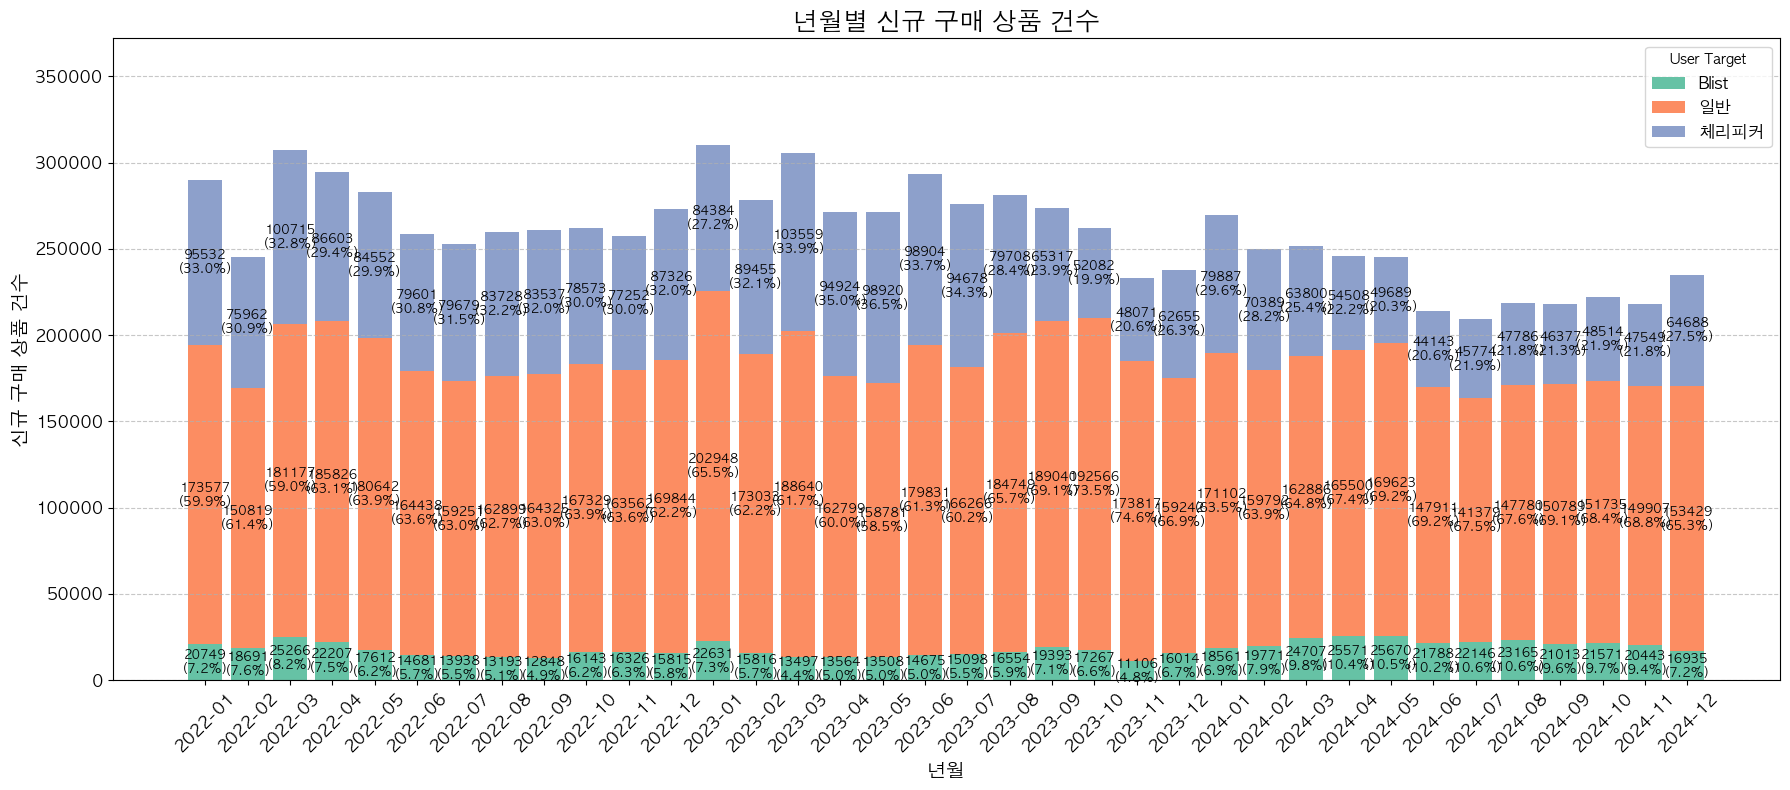

In [144]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 준비
# fst_dt를 날짜 형식으로 변환
normal_price_prod_4_df["fst_dt"] = pd.to_datetime(normal_price_prod_4_df["fst_dt"])

# 년월 단위로 변환
normal_price_prod_4_df["year_month"] = normal_price_prod_4_df["fst_dt"].dt.to_period("M")

# 년월 및 user_trgt_nm별 데이터 집계
grouped_data = normal_price_prod_4_df.groupby(["year_month", "user_trgt_nm"])["fst_prod_cnt"].sum().reset_index()

# 데이터를 Pivot 형태로 변환 (user_trgt_nm별로 열 생성)
pivot_data = grouped_data.pivot(index="year_month", columns="user_trgt_nm", values="fst_prod_cnt").fillna(0)

# 2. Stacked Bar Plot 그리기
plt.figure(figsize=(18, 8))

# Stacked Bar Plot 생성
bar_positions = range(len(pivot_data.index))  # X축 위치
bottom_values = [0] * len(pivot_data.index)  # 스택의 시작점 초기화

# 색상 팔레트 설정
colors = sns.color_palette("Set2", len(pivot_data.columns))

# 각 user_trgt_nm별로 스택된 바 생성
for i, column in enumerate(pivot_data.columns):
    plt.bar(
        bar_positions,
        pivot_data[column],
        bottom=bottom_values,
        label=column,
        color=colors[i],
        width=0.8
    )
    
    # 데이터 라벨링 (건수 및 비중)
    for j, value in enumerate(pivot_data[column]):
        if value > 0:  # 값이 0보다 큰 경우에만 라벨 표시
            total = pivot_data.iloc[j].sum()  # 해당 년월의 총합 계산
            percentage = (value / total) * 100  # 비중 계산
            plt.text(
                j,  # X축 위치
                bottom_values[j] + value / 2,  # Y축 위치 (스택의 중간)
                f"{int(value)}\n({percentage:.1f}%)",  # 건수 및 비중 표시
                ha="center",
                va="center",
                fontsize=9,
                color="black"
            )
    # 스택의 시작점 업데이트
    bottom_values = [bottom_values[k] + pivot_data[column].iloc[k] for k in range(len(bottom_values))]

# 3. 그래프 설정
plt.title("년월별 신규 구매 상품 건수", fontsize=18)
plt.xlabel("년월", fontsize=14)
plt.ylabel("신규 구매 상품 건수", fontsize=14)
plt.xticks(bar_positions, pivot_data.index.astype(str), rotation=45, fontsize=12)  # X축 레이블 설정
plt.yticks(fontsize=12)  # Y축 레이블 크기 조정
plt.legend(title="User Target", loc="upper right", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)  # Y축 격자 추가

# Y축 범위 확장 (라벨이 바깥으로 나오는 경우 대비)
plt.ylim(0, max(pivot_data.sum(axis=1)) * 1.2)

plt.tight_layout()
plt.show()

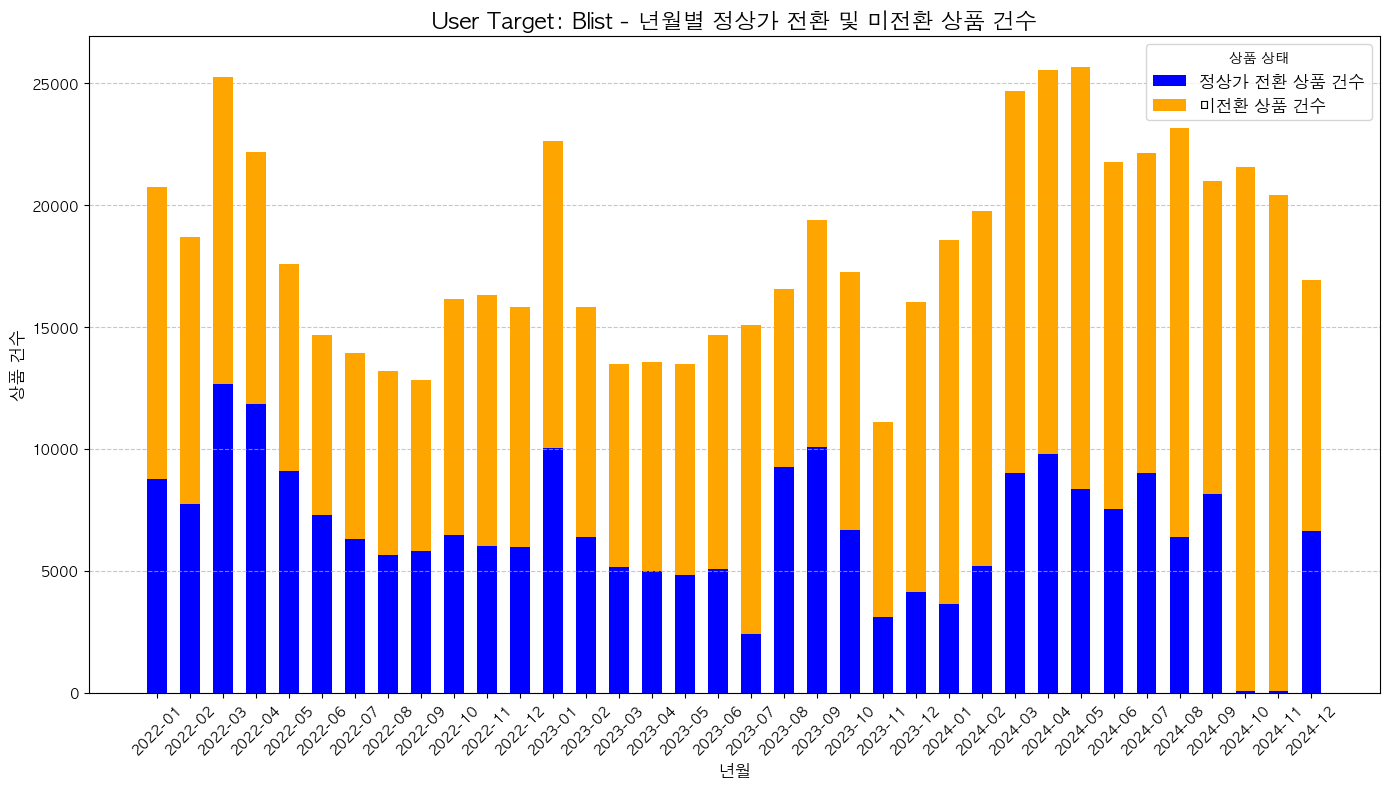

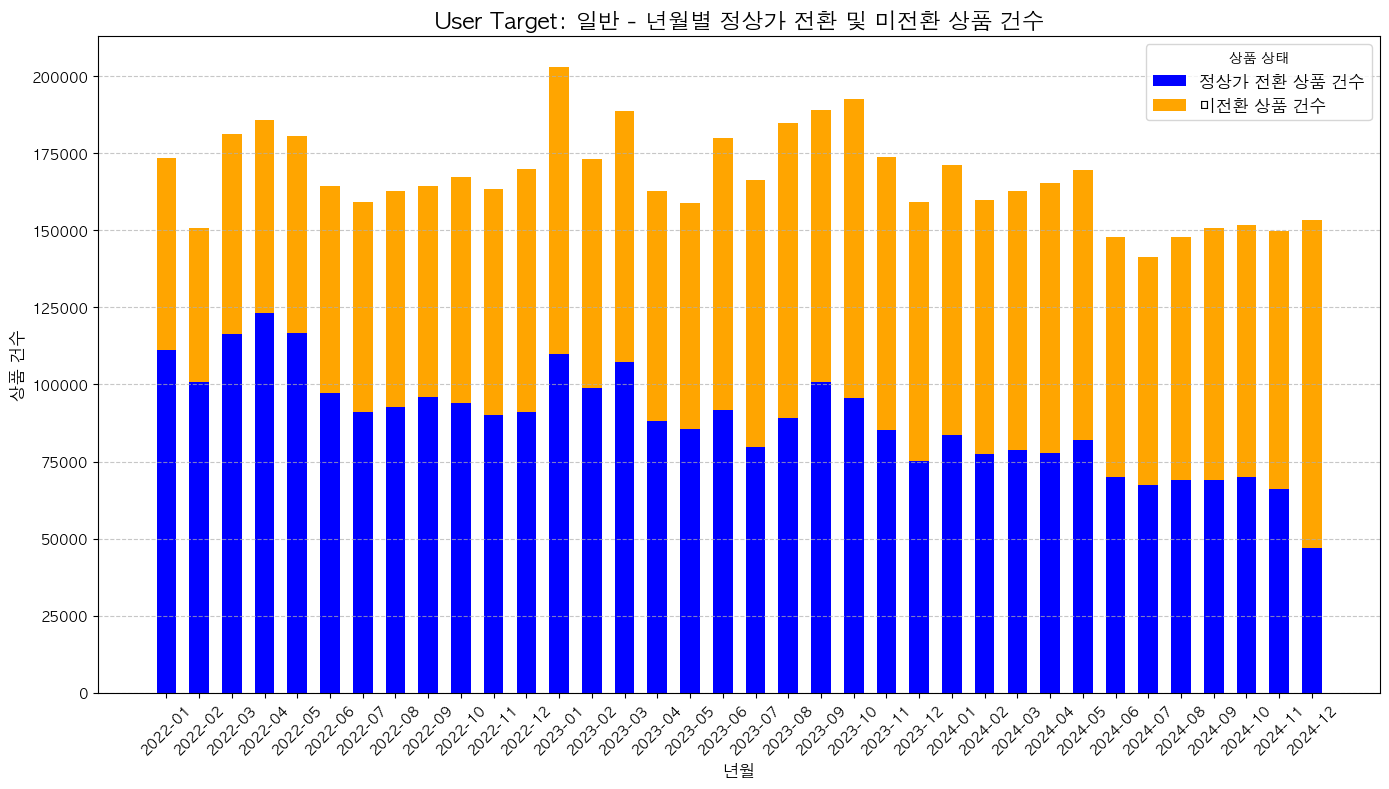

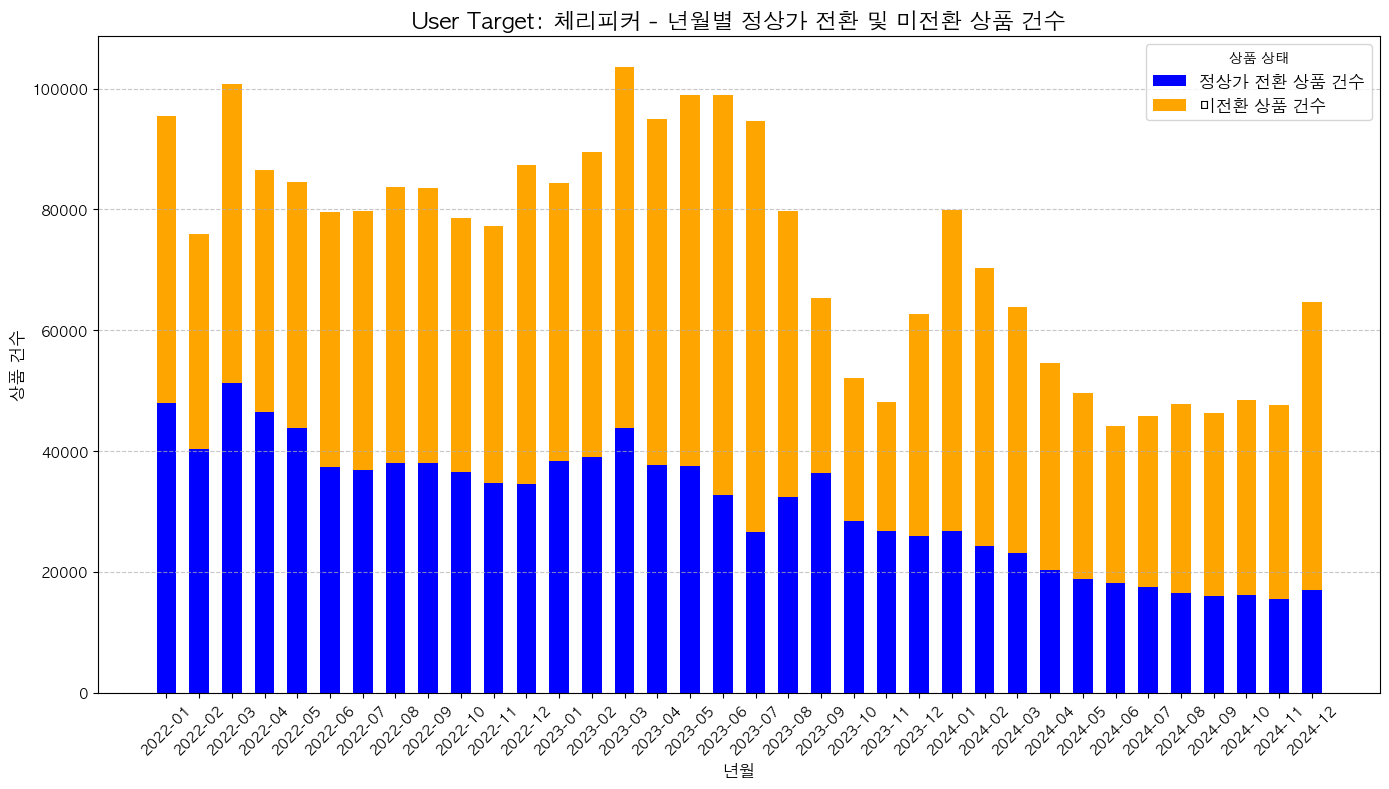

In [145]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 데이터 준비
# fst_dt를 날짜 형식으로 변환
normal_price_prod_4_df["fst_dt"] = pd.to_datetime(normal_price_prod_4_df["fst_dt"])

# 년월 단위로 변환
normal_price_prod_4_df["year_month"] = normal_price_prod_4_df["fst_dt"].dt.to_period("M")

# 미전환 상품건수 계산
normal_price_prod_4_df["non_normal_prod_cnt"] = normal_price_prod_4_df["fst_prod_cnt"] - normal_price_prod_4_df["normal_termm_prod_cnt"]

# user_trgt_nm의 고유값 추출
user_trgt_groups = normal_price_prod_4_df["user_trgt_nm"].unique()

# 2. user_trgt_nm별로 Stacked Bar Plot 생성
for user_trgt in user_trgt_groups:
    # 특정 user_trgt_nm 데이터 필터링
    group_data = normal_price_prod_4_df[normal_price_prod_4_df["user_trgt_nm"] == user_trgt]
    
    # 년월별 데이터 집계
    grouped_data = group_data.groupby("year_month")[["normal_termm_prod_cnt", "non_normal_prod_cnt"]].sum().reset_index()
    
    # 3. Stacked Bar Plot 그리기
    plt.figure(figsize=(14, 8))
    
    # 정상가 전환 상품 건수
    plt.bar(
        grouped_data["year_month"].astype(str),  # X축을 문자열로 변환
        grouped_data["normal_termm_prod_cnt"],
        label="정상가 전환 상품 건수",
        color="blue",
        width=0.6  # 막대 너비 조정
    )
    
    # 미전환 상품 건수
    plt.bar(
        grouped_data["year_month"].astype(str),
        grouped_data["non_normal_prod_cnt"],
        bottom=grouped_data["normal_termm_prod_cnt"],
        label="미전환 상품 건수",
        color="orange",
        width=0.6  # 막대 너비 조정
    )
    
    # 4. 그래프 설정
    plt.title(f"User Target: {user_trgt} - 년월별 정상가 전환 및 미전환 상품 건수", fontsize=16)
    plt.xlabel("년월", fontsize=12)
    plt.ylabel("상품 건수", fontsize=12)
    plt.xticks(rotation=45)  # X축 레이블 회전
    plt.legend(title="상품 상태", loc="upper right", fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)  # Y축 격자 추가
    plt.tight_layout()
    plt.show()

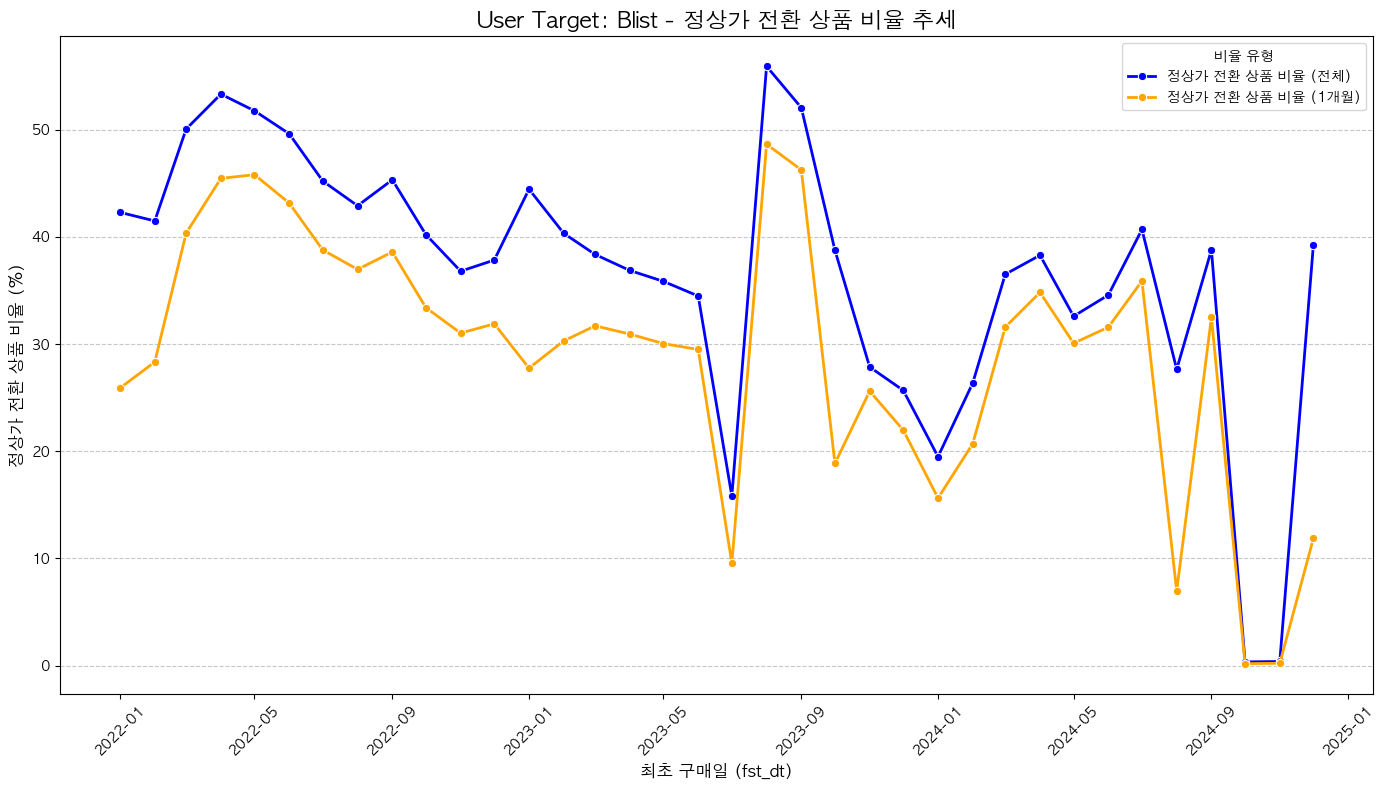

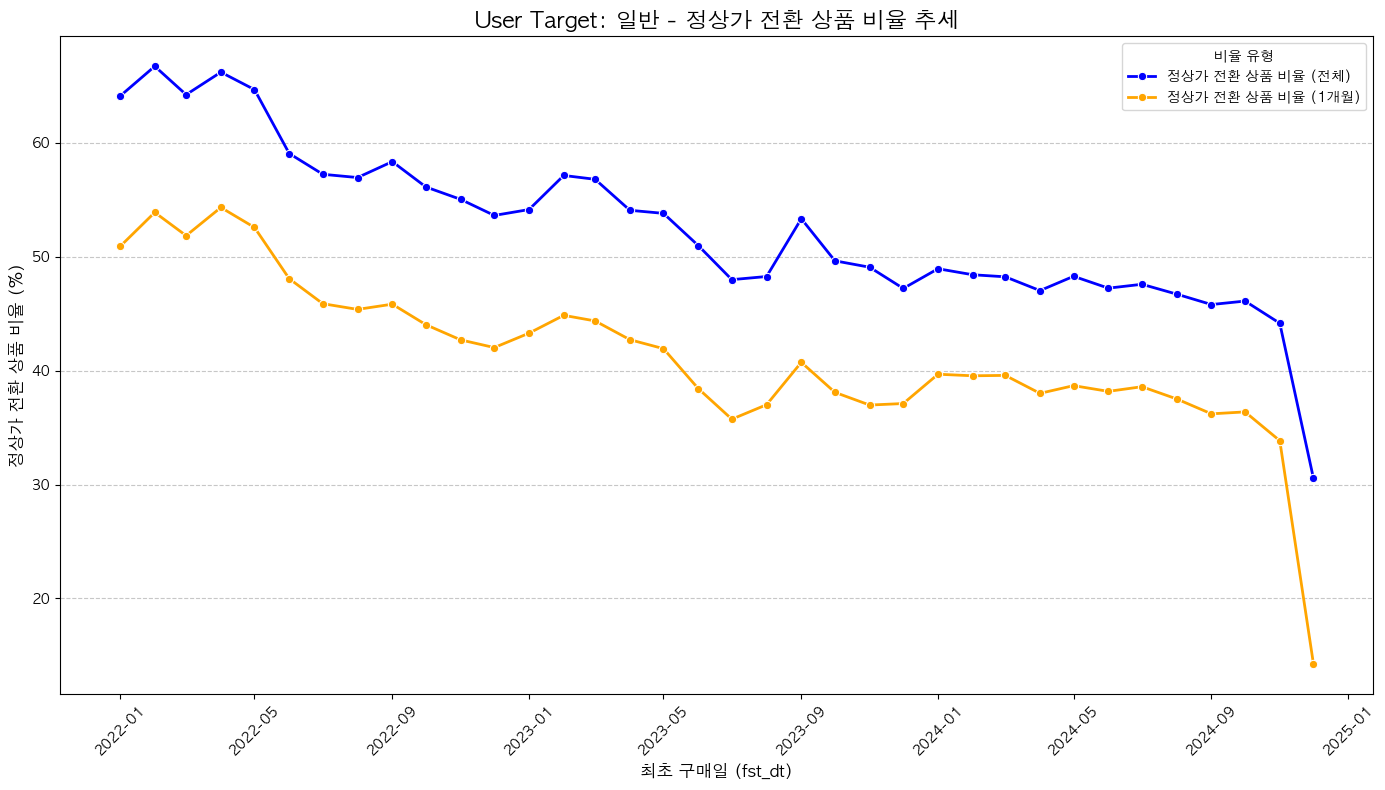

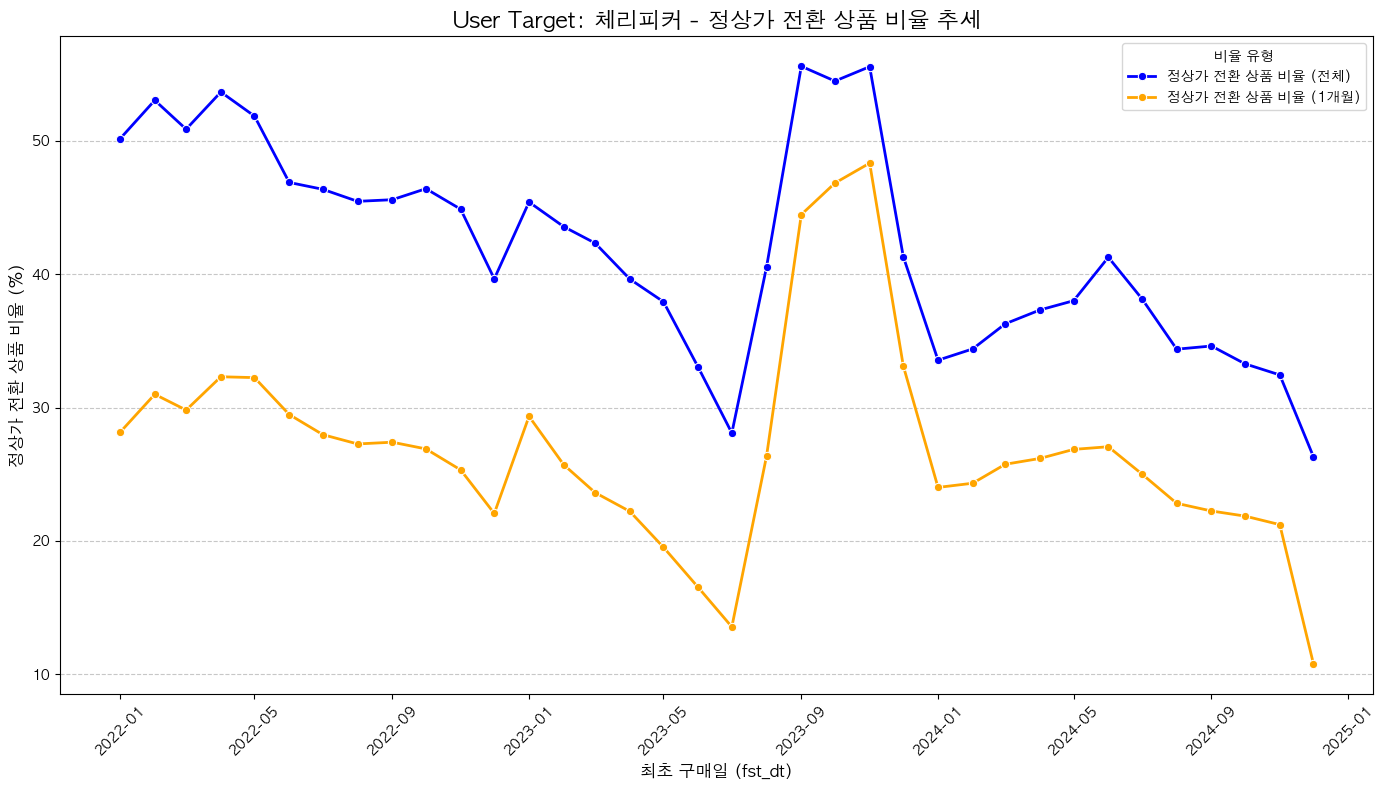

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 준비
# fst_dt를 날짜 형식으로 변환
normal_price_prod_4_df["fst_dt"] = pd.to_datetime(normal_price_prod_4_df["fst_dt"])

# user_trgt_nm의 고유값 추출
user_trgt_groups = normal_price_prod_4_df["user_trgt_nm"].unique()

# 2. user_trgt_nm별로 Line Plot 생성
for user_trgt in user_trgt_groups:
    # 특정 user_trgt_nm 데이터 필터링
    group_data = normal_price_prod_4_df[normal_price_prod_4_df["user_trgt_nm"] == user_trgt]
    
    # Line Plot 그리기
    plt.figure(figsize=(14, 8))
    
    # normal_term_prod_ratio 라인
    sns.lineplot(
        data=group_data,
        x="fst_dt",
        y="normal_term_prod_ratio",
        label="정상가 전환 상품 비율 (전체)",
        color="blue",
        marker="o",
        linewidth=2
    )
    
    # normal_term_1m_prod_ratio 라인
    sns.lineplot(
        data=group_data,
        x="fst_dt",
        y="normal_term_1m_prod_ratio",
        label="정상가 전환 상품 비율 (1개월)",
        color="orange",
        marker="o",
        linewidth=2
    )
    
    # 그래프 설정
    plt.title(f"User Target: {user_trgt} - 정상가 전환 상품 비율 추세", fontsize=16)
    plt.xlabel("최초 구매일 (fst_dt)", fontsize=12)
    plt.ylabel("정상가 전환 상품 비율 (%)", fontsize=12)
    plt.xticks(rotation=45)  # X축 레이블 회전
    plt.legend(title="비율 유형", loc="upper right")  # 범례 설정
    plt.grid(axis="y", linestyle="--", alpha=0.7)  # Y축 격자 추가
    plt.tight_layout()
    plt.show()

In [147]:
from scipy.stats import f_oneway

# 1. user_trgt_nm별 데이터 분리
grouped_data = [normal_price_prod_4_df[normal_price_prod_4_df["user_trgt_nm"] == group]["normal_term_prod_ratio"].dropna() 
                for group in normal_price_prod_4_df["user_trgt_nm"].unique()]

# 2. ANOVA 수행
f_stat, p_value = f_oneway(*grouped_data)

# 3. 결과 출력
print("ANOVA 결과:")
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# 유의미한 차이 여부 확인
if p_value < 0.05:
    print("P-value가 0.05보다 작으므로, user_trgt_nm 그룹 간 정상가 전환율에 유의미한 차이가 있습니다.")
else:
    print("P-value가 0.05보다 크므로, user_trgt_nm 그룹 간 정상가 전환율에 유의미한 차이가 없습니다.")

ANOVA 결과:
F-statistic: 25.8553
P-value: 0.0000
P-value가 0.05보다 작으므로, user_trgt_nm 그룹 간 정상가 전환율에 유의미한 차이가 있습니다.


                             OLS Regression Results                            
Dep. Variable:     cherry_picker_ratio   R-squared:                       0.503
Model:                             OLS   Adj. R-squared:                  0.488
Method:                  Least Squares   F-statistic:                     34.40
Date:                 Fri, 11 Apr 2025   Prob (F-statistic):           1.29e-06
Time:                         09:49:04   Log-Likelihood:                -96.018
No. Observations:                   36   AIC:                             196.0
Df Residuals:                       34   BIC:                             199.2
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         33.9265      1.171     28.98

/var/folders/qw/6lks7c5d14scf7qtctm8m6jh0000gn/T/ipykernel_80999/986020830.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cherry_picker_data["year_month"] = cherry_picker_data["fst_dt"].dt.to_period("M")


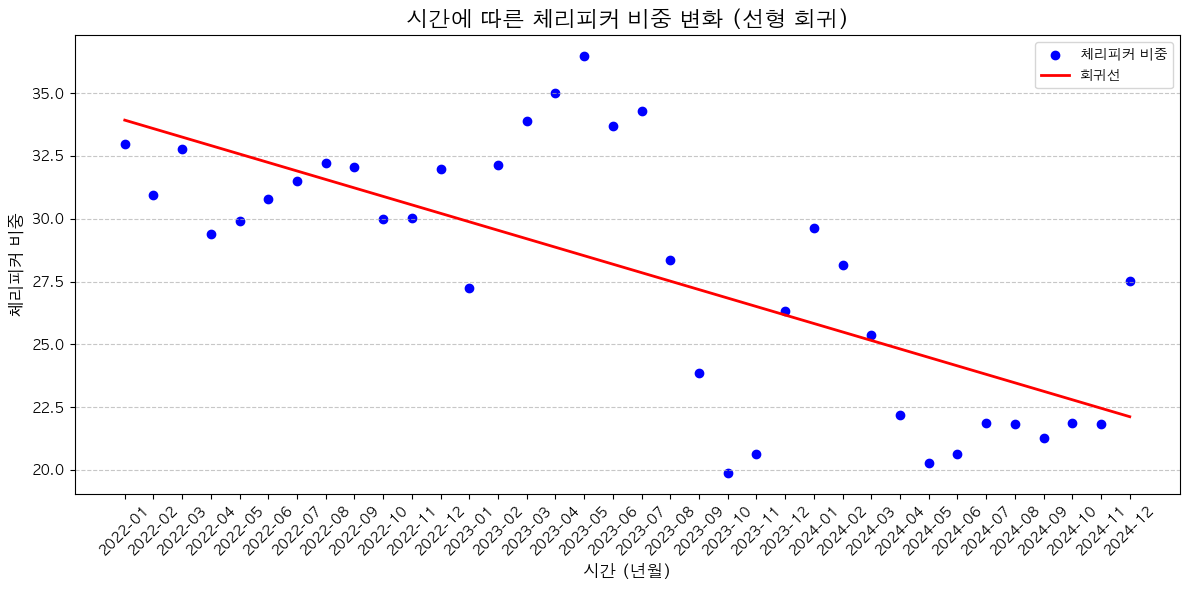

In [150]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# 1. 데이터 준비
# 체리피커 그룹만 필터링
cherry_picker_data = normal_price_prod_4_df[normal_price_prod_4_df["user_trgt_nm"] == "체리피커"]

# 년월 단위로 그룹화하여 체리피커 비중 계산
cherry_picker_data["year_month"] = cherry_picker_data["fst_dt"].dt.to_period("M")
monthly_data = cherry_picker_data.groupby("year_month")["fst_prod_cnt"].sum().reset_index()

# 전체 상품 건수 계산 (모든 그룹 포함)
normal_price_prod_4_df["year_month"] = normal_price_prod_4_df["fst_dt"].dt.to_period("M")
total_monthly_data = normal_price_prod_4_df.groupby("year_month")["fst_prod_cnt"].sum().reset_index()

# 체리피커 비중 계산
monthly_data = pd.merge(monthly_data, total_monthly_data, on="year_month", suffixes=("_cherry", "_total"))
monthly_data["cherry_picker_ratio"] = monthly_data["fst_prod_cnt_cherry"] / monthly_data["fst_prod_cnt_total"]*100

# 2. 선형 회귀 분석
# X축: 시간 (년월), Y축: 체리피커 비중
monthly_data["time"] = range(len(monthly_data))  # 시간 변수 생성
X = sm.add_constant(monthly_data["time"])  # 상수항 추가
y = monthly_data["cherry_picker_ratio"]

# 회귀 모델 적합
model = sm.OLS(y, X).fit()

# 결과 출력
print(model.summary())

# 3. 회귀선 시각화
plt.figure(figsize=(12, 6))
plt.scatter(monthly_data["time"], monthly_data["cherry_picker_ratio"], label="체리피커 비중", color="blue")
plt.plot(monthly_data["time"], model.predict(X), label="회귀선", color="red", linewidth=2)
plt.title("시간에 따른 체리피커 비중 변화 (선형 회귀)", fontsize=16)
plt.xlabel("시간 (년월)", fontsize=12)
plt.ylabel("체리피커 비중", fontsize=12)
plt.xticks(monthly_data["time"], monthly_data["year_month"].astype(str), rotation=45)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()